In [1]:
#https://github.com/wiseodd/generative-models/blob/master/GAN/wasserstein_gan/wgan_pytorch.py
#https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py
#https://www.kaggle.com/code/roblexnana/implementation-of-gan-for-beginners

In [2]:
import pandas as pd
import numpy as np
import wfdb
import ast
import matplotlib.pyplot as plt
import torch
#import torch.nn.functional as F
from torch import nn
#from scipy.stats import wasserstein_distance as ssw
from scipy.stats import kurtosis
from scipy.stats import skew
import warnings; warnings.filterwarnings('ignore')

In [3]:
sampling_rate=100
path = 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'

# function for loading data
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)
# Dimensions of the loaded signals
X.shape

(21837, 1000, 12)

In [4]:
dataset_samples = Y.shape[0]
print(dataset_samples)
#X.shape

21837


In [5]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [6]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [7]:
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [8]:
Y.diagnostic_superclass

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 21837, dtype: object

In [9]:
# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

In [10]:
#X_train[69]
(y_train)

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 19634, dtype: object

In [11]:
y_train.index.values

array([    1,     2,     3, ..., 21835, 21836, 21837])

In [12]:
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass
print(X_test.shape)
y_test

(2203, 1000, 12)


ecg_id
9        [NORM]
38       [NORM]
40       [NORM]
57       [NORM]
59       [NORM]
          ...  
21809    [NORM]
21812      [CD]
21818    [NORM]
21819      [CD]
21826      [MI]
Name: diagnostic_superclass, Length: 2203, dtype: object

In [13]:
torch.manual_seed(111)

In [14]:
train_data_length = 1024

In [15]:
# let's pick an arbitrary signal and it's information from Y index_column
ecg_record = 0  
#Lead_I_data = X[ecg_record][:,0] 
Lead_II_data = X[ecg_record][:,1] # Index of Lead. It is available in meta_data information
ecg_info = Y.iloc[ecg_record]
#pd.DataFrame(Lead_I_data).plot()
#Lead_I_data
print(ecg_info)

patient_id                                                       15709.0
age                                                                 56.0
sex                                                                    1
height                                                               NaN
weight                                                              63.0
nurse                                                                2.0
site                                                                 0.0
device                                                         CS-12   E
recording_date                                       1984-11-09 09:17:34
report                            sinusrhythmus periphere niederspannung
scp_codes                       {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
heart_axis                                                           NaN
infarction_stadium1                                                  NaN
infarction_stadium2                                

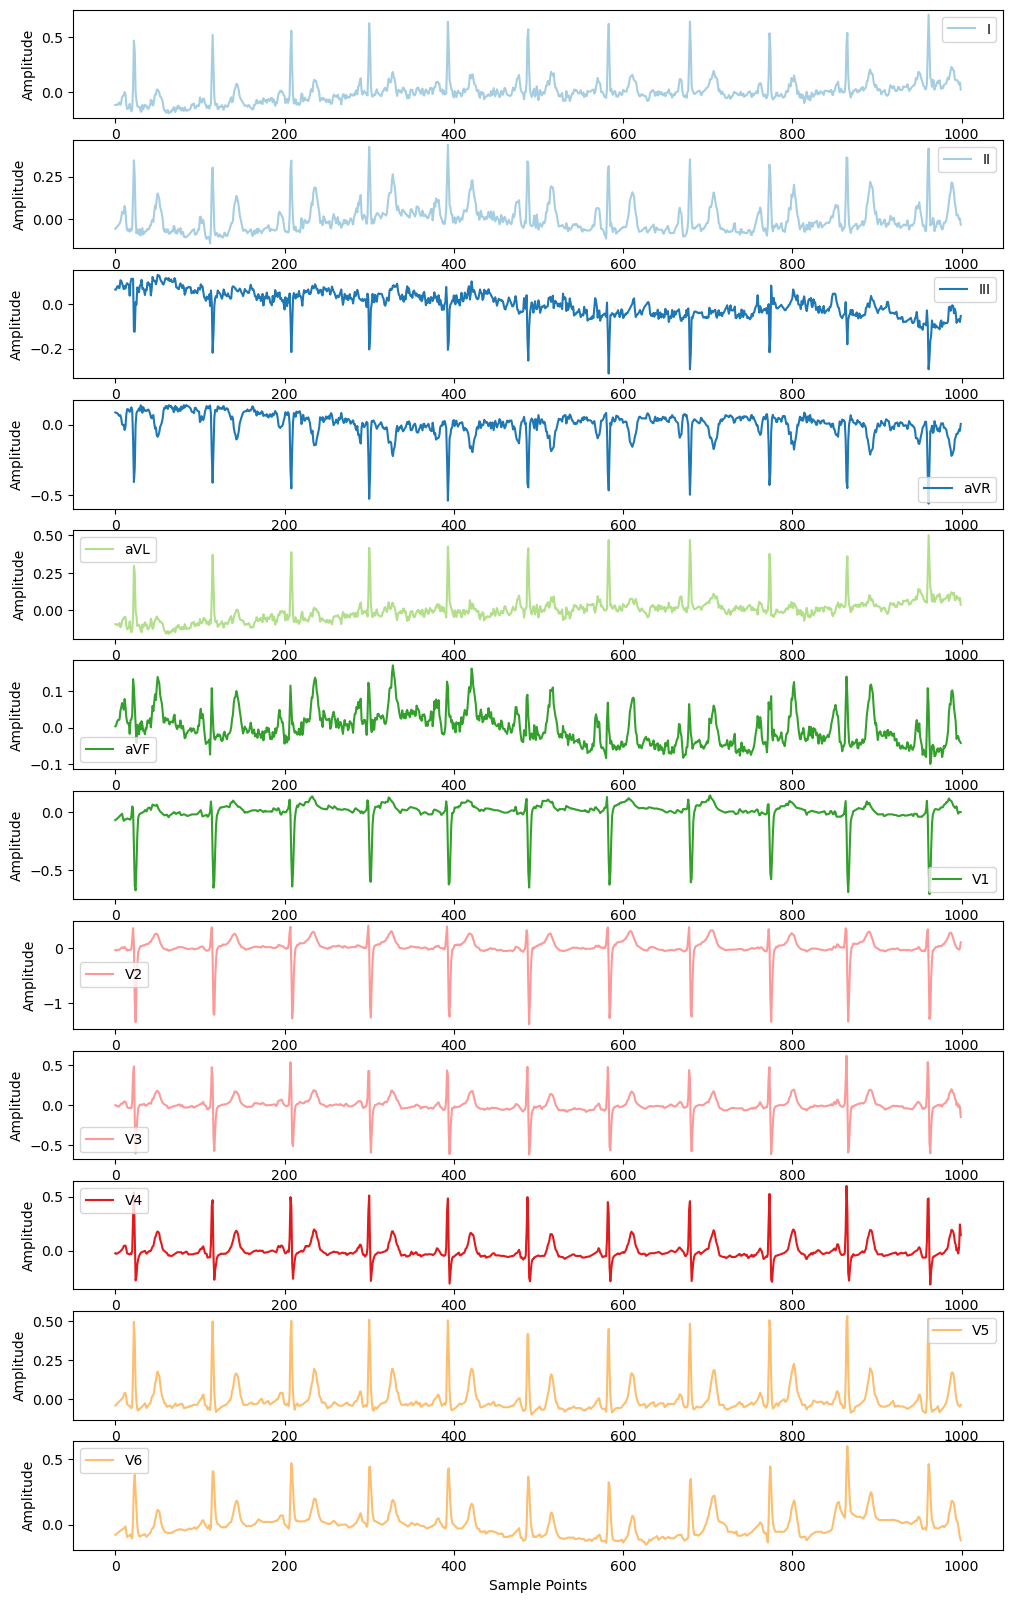

In [16]:
#plot as sub plots for all the 12 leads
leads = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
fig, axes = plt.subplots(12,1, figsize =(12,20))

for i, ax in enumerate(axes.flatten()):
    r= X[ecg_record][:,i]
    ax.plot(r,color=plt.cm.Paired(i/20.),label = leads[i])
    axes[i].set_ylabel('Amplitude')
    axes[i].set_xlabel('Sample Points')
    #axes[i].set_label(leads[i])
    axes[i].legend()
#plt.xlabel("Sample Points")
plt.savefig('ECG12leads.png')
plt.show()


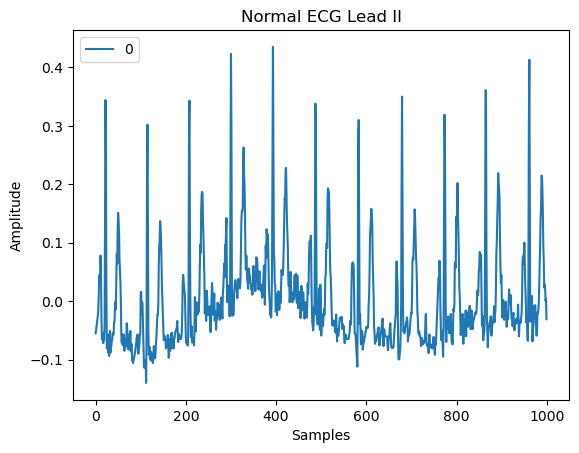

In [17]:
# Plot of Lead II signal.
ecg_record = 0  
## = X[ecg_record][:,1] # Index of Lead. It is available in meta_data information
pd.DataFrame(Lead_II_data).plot()
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Normal ECG Lead II')
plt.savefig('lead2normal.png')

In [18]:
#Mean
real_signal_mean = np.mean(Lead_II_data)
print('signal_mean:', real_signal_mean)
#Variance
real_signal_variance = np.var(Lead_II_data)
print('signal_variance:' ,real_signal_variance)
#Skewness
real_signal_skewness = skew(Lead_II_data)
print('signal_skewness:', real_signal_skewness)
#dataframe.skew()
#Kurtosis
real_signal_kurtosis = kurtosis(Lead_II_data, fisher=False)
print('signal_kurtosis:',real_signal_kurtosis)

signal_mean: 0.0007230000000000016
signal_variance: 0.006926120271
signal_skewness: 1.8237725507872897
signal_kurtosis: 7.3013208607080795


In [19]:
#plot as sub plots for all the 12 leads
#leads = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
#fig, axes = plt.subplots(12,1, figsize =(12,20))

#for i, ax in enumerate(axes.flatten()):
    #r= X[ecg_record][:,i]
    #ax.plot(r,color=plt.cm.Paired(i/20.),label = leads[i])
    #axes[i].set_ylabel('Amplitude')
    #axes[i].set_xlabel('Sample Points')
    #axes[i].set_label(leads[i])
    #axes[i].legend()
#plt.xlabel("Sample Points")
#plt.show()

In [20]:
#Logic to fetch 1024 Normal ECG records Lead_II data from the dataset
cls_normal = ['NORM']
count = 0
Lead_II_train_data = np.empty((1024,1000,))

for k in range(dataset_samples):
    if (k in y_train.index.values) :
        if (y_train[k] == cls_normal):
            if(count == 1024):
                break
            Lead_II_train_data[count] = X[k][:,1]
            count = count+1

train_data = Lead_II_train_data
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

In [21]:
#print(train_data.shape)
#max_value = np.max(train_data[0])
#min_value = np.min(train_data[0])
#print(min_value,max_value)
 
#plt.plot(train_data[0])
#pd.DataFrame(train_data[0]).plot()
#plt.show()
train_data.shape

(1024, 1000)

In [22]:
print(Lead_II_train_data.shape)
#pd.DataFrame(Lead_I_train_data[0]).plot()

(1024, 1000)


In [23]:
#Lead_I_train_data

In [24]:
eps = 0.0001

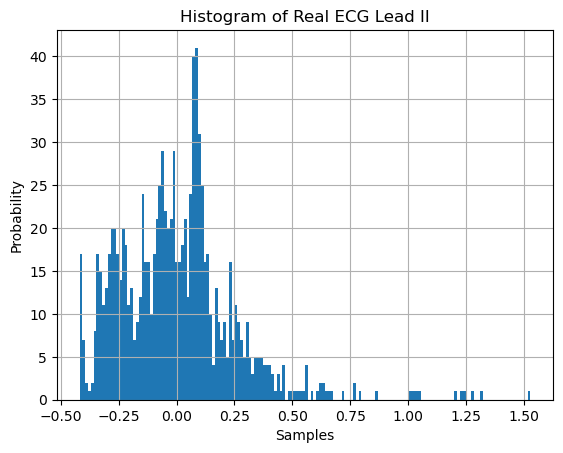

Real ECG Lead II [17.  7.  2.  1.  2.  8. 17. 15. 11. 13. 17. 20. 20. 17. 14. 20. 18. 11.
 13.  7.  9. 12. 24. 16. 16. 10. 17. 21. 25. 29. 22. 20. 21. 29. 16. 16.
 18. 21. 12. 24. 40. 41. 31. 25. 16. 17. 10.  4. 13.  9.  7.  9.  5. 16.
  7. 11.  9.  7.  5.  9.  5.  3.  5.  5.  5.  4.  4.  4.  3.  1.  3.  1.
  4.  0.  1.  1.  1.  1.  1.  1.  4.  0.  1.  0.  1.  2.  2.  1.  1.  1.
  0.  0.  0.  1.  0.  0.  0.  2.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
Real ECG Lead 1000.0


In [25]:
# the histogram of the data
n, bins, patches = plt.hist(train_data[0],160)
plt.xlabel('Samples')
plt.ylabel('Probability')
plt.title('Histogram of Real ECG Lead II')
plt.grid(True)
plt.savefig('realecghistogram.png')
plt.show()
print('Real ECG Lead II',n)
print('Real ECG Lead',np.sum(n))

In [26]:
#Probability calculations
#print(bins)
#print(n)

#prob_real = n/1000
#print(prob_real)

In [27]:
#Mean
#def dist_mean(bins,probs):
    #distmean = np.sum(bins*probs)
    #return distmean
#Variance
#def dist_var(results,dmean):
#var_res = sum((xi - dmean) ** 2 for xi in results) / len(results)
#Skewness
#Kurtosis

In [28]:
#bin_border = bins[0:len(bins)-1]
#mean_real_dist = dist_mean(bin_border,n)
#print(mean_real_dist) #-5.371406250000021

In [29]:
#pd.DataFrame(train_data[0]).plot(kind='kde');

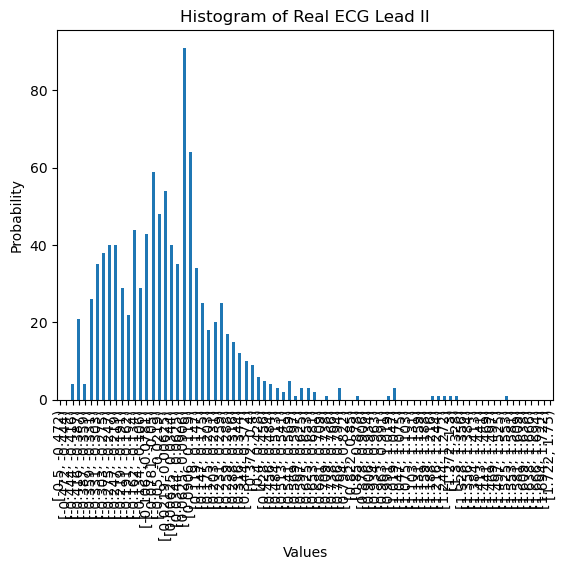

preal_sum 1.0


In [30]:
step = 0.028125
bin_range = np.arange(-0.5, 1.75+step, step)
outr, bins  = pd.cut(train_data[0], bins=bin_range, include_lowest=True, right=False, retbins=True)
outr.value_counts().plot.bar()
plt.xlabel('Values')
plt.ylabel('Probability')
plt.title('Histogram of Real ECG Lead II')
plt.grid(False)
#plt.axis('off')
plt.show()
#print(outr.value_counts())
df1 = outr.value_counts().rename_axis('values').reset_index(name='counts')
real = df1.counts.values
#print(df1)
#print(real)
#print(np.sum(real))
preal = real/1000
preal_sum = np.sum(preal)
print('preal_sum',preal_sum)
#print(preal)
#print(type(preal))
nonzero_preal = np.count_nonzero(preal)
#print(nonzero_preal)
preal_eps = eps/nonzero_preal
#print(preal_eps)
smooth_preal = np.where(preal != 0, preal - preal_eps, preal_eps)
#print(smooth_preal)
#print('Probability of the Real data distribution-',preal)

In [31]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [32]:
#https://github.com/wiseodd/generative-models/blob/master/GAN/wasserstein_gan/wgan_pytorch.py
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
             nn.Linear(1000, 256),
             nn.ReLU(),
             nn.Dropout(0.3),
             nn.Linear(256, 128),
             nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            #nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [33]:
discriminator = Discriminator()

In [34]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1000, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1000)
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [35]:
lr = 0.0005
num_epochs = 200

In [36]:
#optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
#optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

optimizer_discriminator = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.RMSprop(generator.parameters(), lr=lr)

In [37]:
batches_per_epoch = (train_data_length / batch_size)
n_steps = batches_per_epoch * num_epochs
print('batches_per_epoch',batches_per_epoch)
print('total_iterations',n_steps)

batches_per_epoch 32.0
total_iterations 6400.0


In [38]:
def reset_grad():
    generator.zero_grad()
    discriminator.zero_grad()

In [39]:
def generate_data():
    latent_space_samples = torch.randn(1, 1000)
    generated_samples = generator(latent_space_samples)
#print(generated_samples)

In [40]:
def prob_generated(generated_samples):
    step = 0.028125
    bin_range = np.arange(-0.5, 1.75+step, step)
    outg, bins  = pd.cut(generated_samples[0].detach(), bins=bin_range, include_lowest=True, right=False, retbins=True)
    df = outg.value_counts().rename_axis('values').reset_index(name='counts')
    gen = df.counts.values
    #print('generated',gen)
    pgen = gen/1000
    #pgen_sum = np.sum(pgen)
    #print('pgen_sum',pgen_sum)
    #print('prob_generated',pgen)
    nonzero_pgen = np.count_nonzero(pgen)
    #print(nonzero_pgen)
    pgen_eps = eps/nonzero_pgen
    #print(pgen_eps)
    smooth_pgen = np.where(pgen != 0, pgen - pgen_eps, pgen_eps)
    #print(smooth_pgen)
    #return pgen
    return smooth_pgen

In [41]:
#Validation
#1. Kullback-Leibler divergence 

In [42]:
#calculate the KLD between real and sample  distributions
def kl_divergence_calc(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

Epoch: 0 Loss D.: -0.09568044543266296 Loss G.: 0.027809392660856247 KL Divergence RG: 1.937529953482638 KL Divergence GR: 0.5459421695166734
Epoch 0


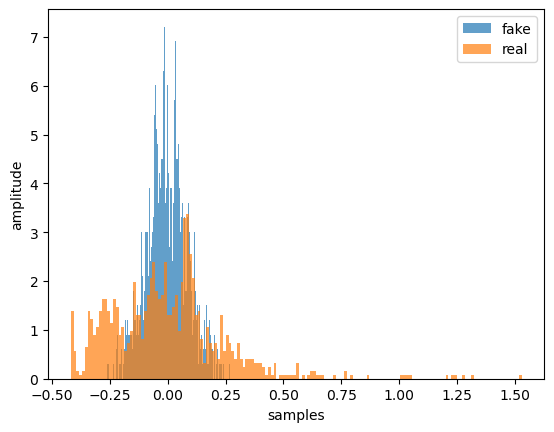

Epoch 1


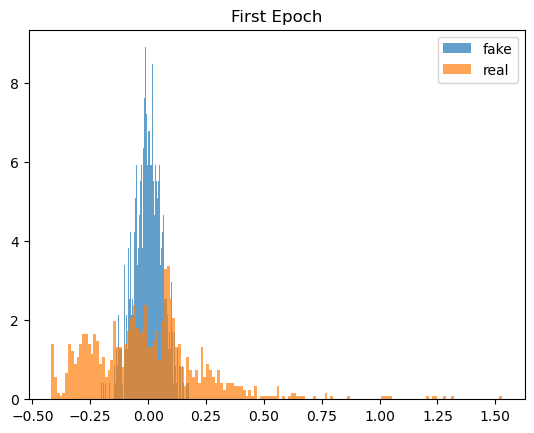

Epoch: 1 Loss D.: -0.0695071667432785 Loss G.: 0.01850157417356968 KL Divergence RG: 3.0837296531511753 KL Divergence GR: 0.8207980176346875
Epoch 1


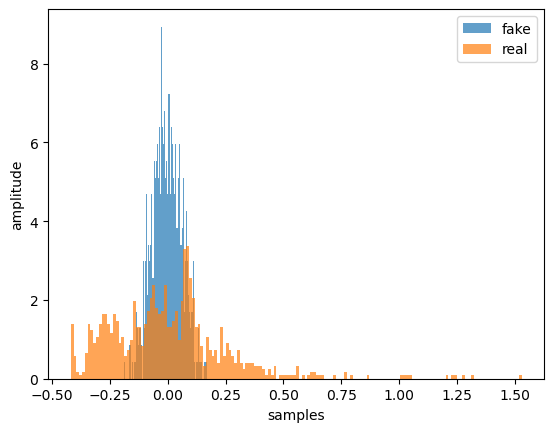

Epoch: 2 Loss D.: -0.10500926524400711 Loss G.: 0.012082505971193314 KL Divergence RG: 4.114317340612132 KL Divergence GR: 1.3142734851968383
Epoch 2


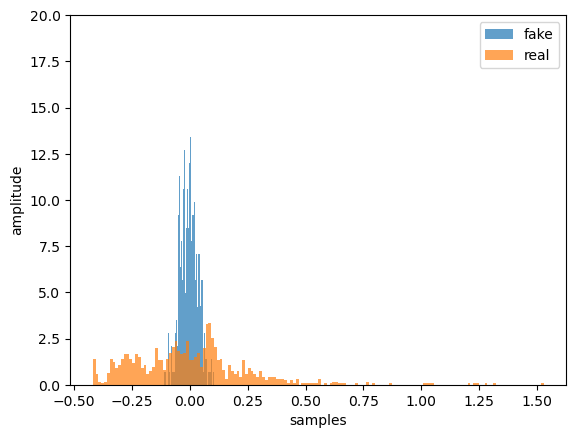

Epoch: 3 Loss D.: -0.07463853061199188 Loss G.: 0.016437850892543793 KL Divergence RG: 2.7870479352567044 KL Divergence GR: 0.6713215192291421
Epoch 3


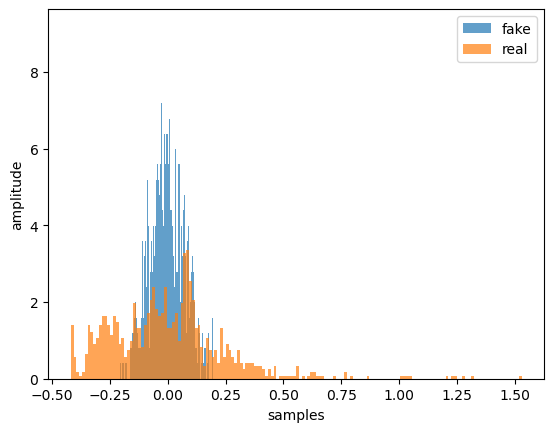

Epoch: 4 Loss D.: -0.05721505358815193 Loss G.: 0.0029459733050316572 KL Divergence RG: 2.19367305060186 KL Divergence GR: 0.6230608839067707
Epoch 4


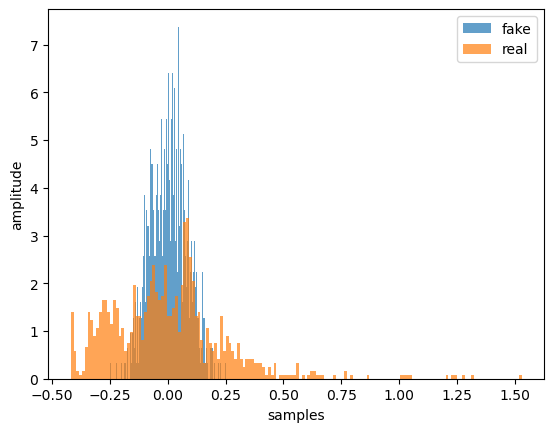

Epoch: 5 Loss D.: -0.04980878904461861 Loss G.: 0.014782325364649296 KL Divergence RG: 3.5851959365891366 KL Divergence GR: 1.1920880047113445
Epoch 5


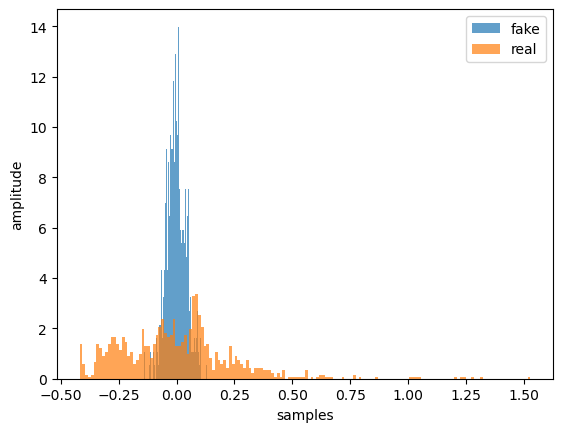

Epoch: 6 Loss D.: -0.061648473143577576 Loss G.: 0.011041892692446709 KL Divergence RG: 4.543771543445523 KL Divergence GR: 1.445316113360772
Epoch 6


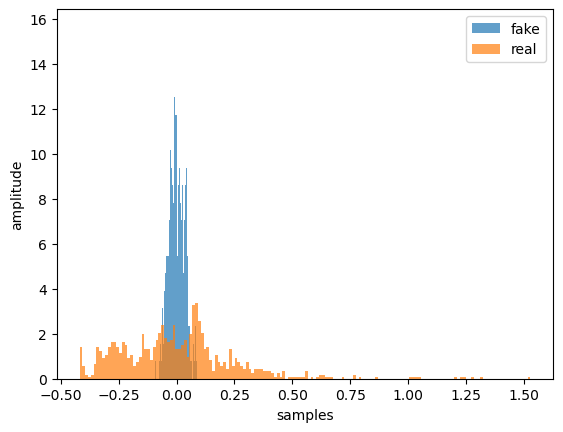

Epoch: 7 Loss D.: -0.045960355550050735 Loss G.: 0.010510831139981747 KL Divergence RG: 3.3486428605085194 KL Divergence GR: 0.950125632839281
Epoch 7


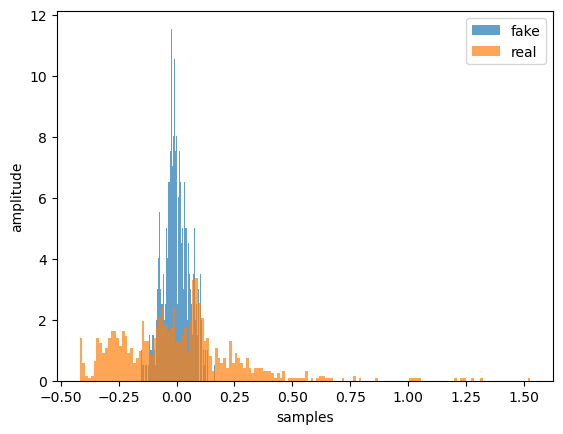

Epoch: 8 Loss D.: -0.04423791542649269 Loss G.: 0.007830754853785038 KL Divergence RG: 3.1695165518916566 KL Divergence GR: 0.8644526777511886
Epoch 8


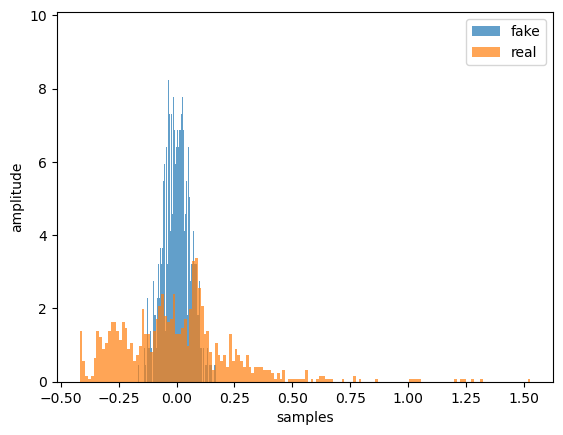

Epoch: 9 Loss D.: -0.04602796584367752 Loss G.: 0.00665487814694643 KL Divergence RG: 3.8332290848258 KL Divergence GR: 1.170888625708759
Epoch 9


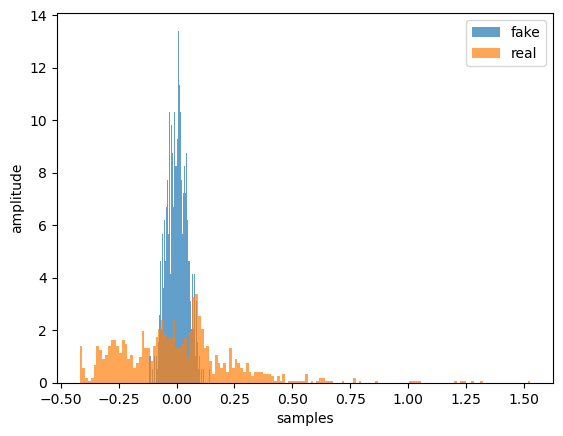

Epoch: 10 Loss D.: -0.044449333101511 Loss G.: 0.006255563348531723 KL Divergence RG: 3.1838086524122513 KL Divergence GR: 0.9148291244723504
Epoch 10


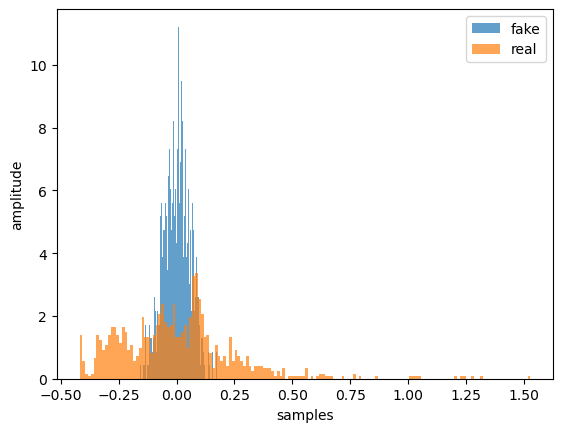

Epoch: 11 Loss D.: -0.0363873615860939 Loss G.: 0.011597350239753723 KL Divergence RG: 3.2290111631288623 KL Divergence GR: 0.9876216752335748
Epoch 11


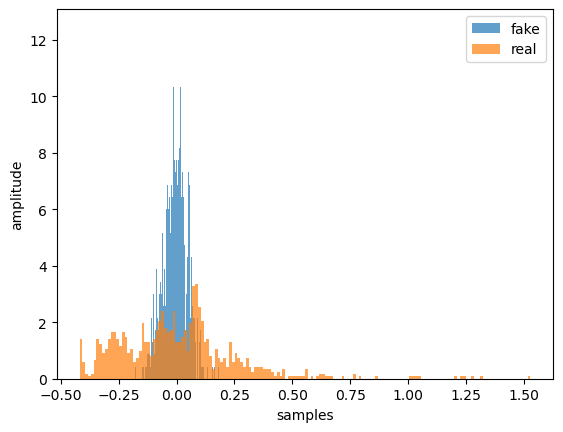

Epoch: 12 Loss D.: -0.05338158458471298 Loss G.: 0.0055028414353728294 KL Divergence RG: 4.5077223177085335 KL Divergence GR: 1.5547581273550566
Epoch 12


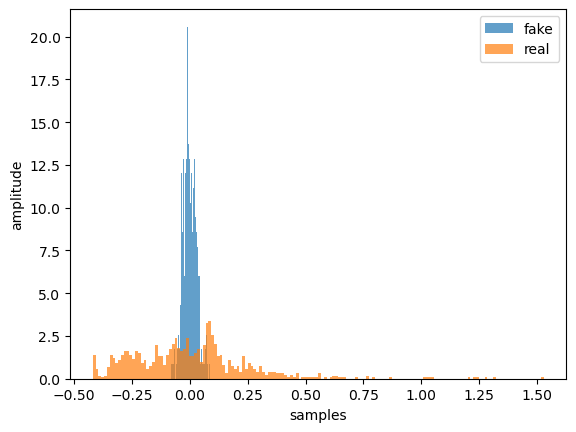

Epoch: 13 Loss D.: -0.042125679552555084 Loss G.: 0.0034760520793497562 KL Divergence RG: 4.839869032356649 KL Divergence GR: 1.5679310201645638
Epoch 13


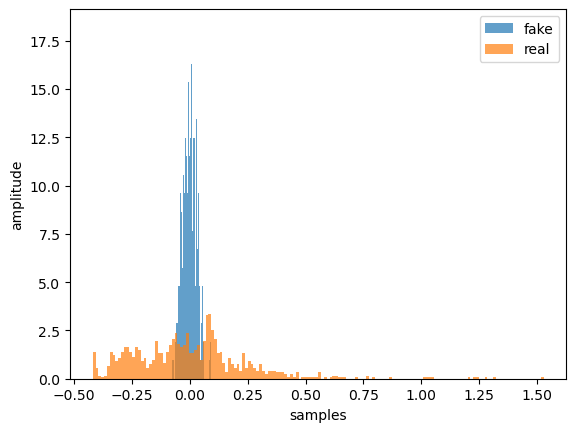

Epoch: 14 Loss D.: -0.04576844722032547 Loss G.: 0.007985897362232208 KL Divergence RG: 4.320988995682697 KL Divergence GR: 1.4671890199202202
Epoch 14


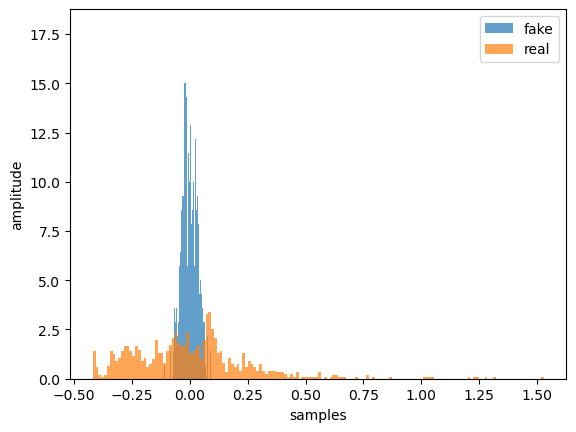

Epoch: 15 Loss D.: -0.03650614619255066 Loss G.: 0.0053353034891188145 KL Divergence RG: 4.143043586577535 KL Divergence GR: 1.3414326249350823
Epoch 15


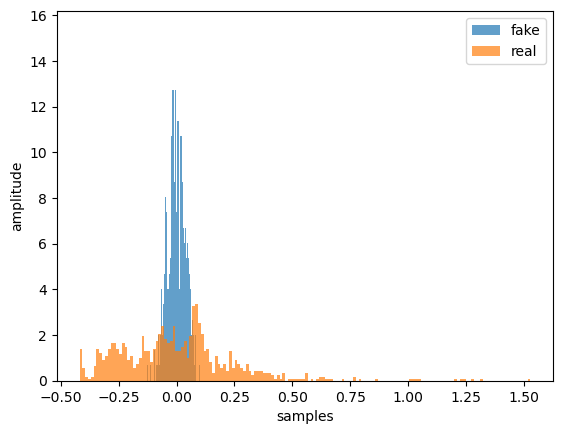

Epoch: 16 Loss D.: -0.03820105269551277 Loss G.: 0.007663978263735771 KL Divergence RG: 3.3835270334837904 KL Divergence GR: 1.0205860374935665
Epoch 16


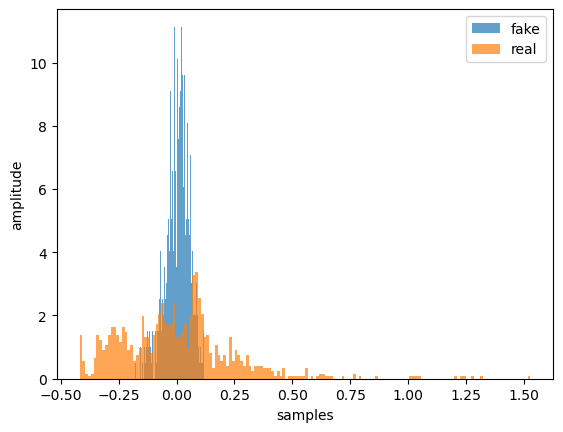

Epoch: 17 Loss D.: -0.040330030024051666 Loss G.: 0.006721092388033867 KL Divergence RG: 4.1310102060909 KL Divergence GR: 1.3891064767818875
Epoch 17


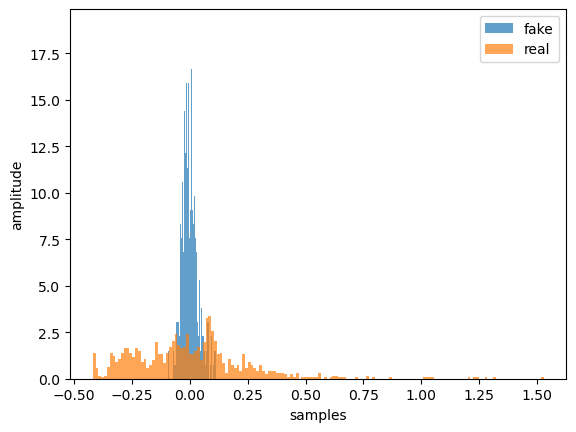

Epoch: 18 Loss D.: -0.03856392577290535 Loss G.: 0.0044706398621201515 KL Divergence RG: 4.304288239650014 KL Divergence GR: 1.3767438631204356
Epoch 18


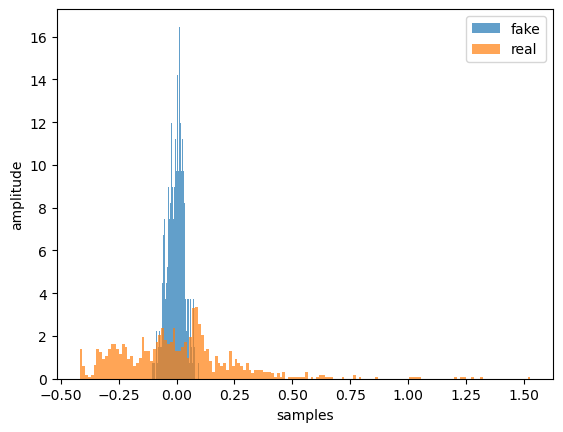

Epoch: 19 Loss D.: -0.037273384630680084 Loss G.: 0.0038085798732936382 KL Divergence RG: 4.369526188359668 KL Divergence GR: 1.4608281314437643
Epoch 19


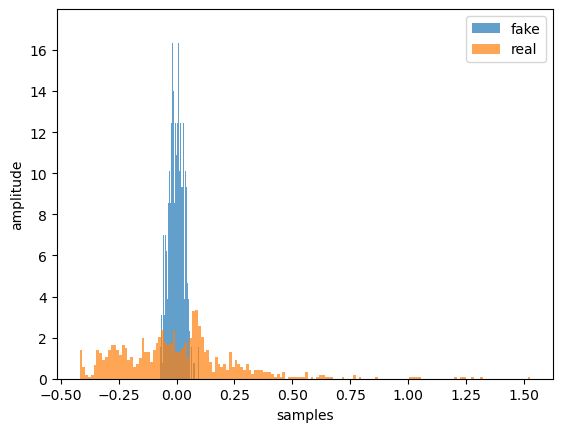

Epoch: 20 Loss D.: -0.0326269306242466 Loss G.: 0.0034883725456893444 KL Divergence RG: 3.6769632312360834 KL Divergence GR: 1.1023283301516593
Epoch 20


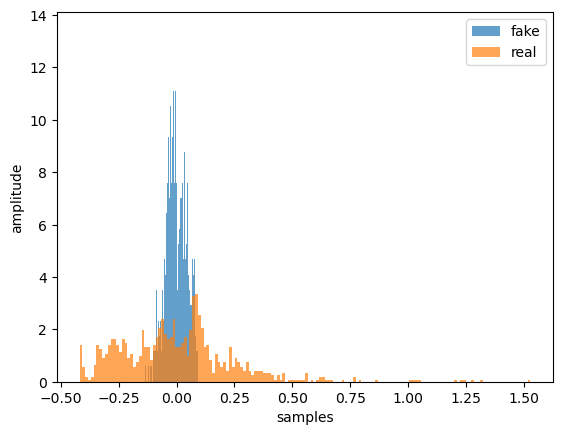

Epoch: 21 Loss D.: -0.04517368599772453 Loss G.: -0.0034633486066013575 KL Divergence RG: 3.5895882355405675 KL Divergence GR: 1.073877413397895
Epoch 21


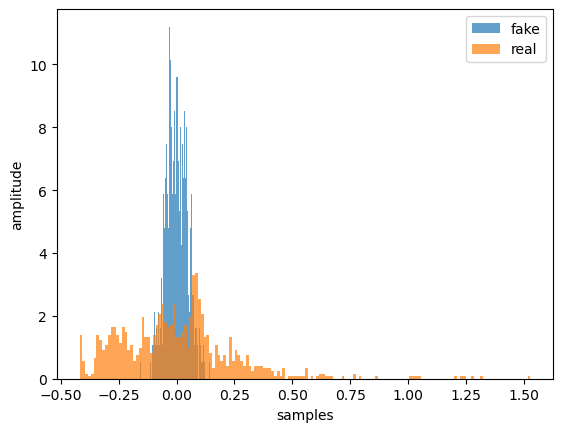

Epoch: 22 Loss D.: -0.03260185196995735 Loss G.: 0.005938880145549774 KL Divergence RG: 4.9243282166838425 KL Divergence GR: 1.6980348149379727
Epoch 22


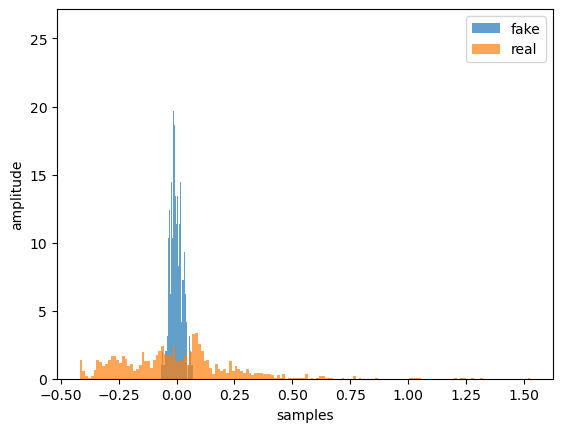

Epoch: 23 Loss D.: -0.03982074558734894 Loss G.: 0.0011447621509432793 KL Divergence RG: 3.6681022804631547 KL Divergence GR: 1.031934719724376
Epoch 23


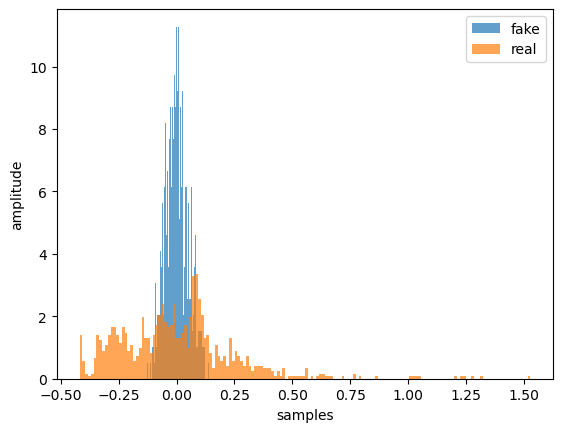

Epoch: 24 Loss D.: -0.035014502704143524 Loss G.: 0.004060229752212763 KL Divergence RG: 3.8942539434542898 KL Divergence GR: 1.3195828385469597
Epoch 24


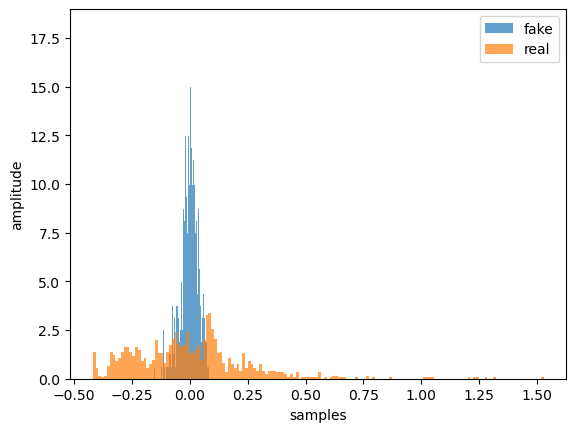

Epoch: 25 Loss D.: -0.034377291798591614 Loss G.: 0.004069790709763765 KL Divergence RG: 4.334762892766517 KL Divergence GR: 1.4825786829854766
Epoch 25


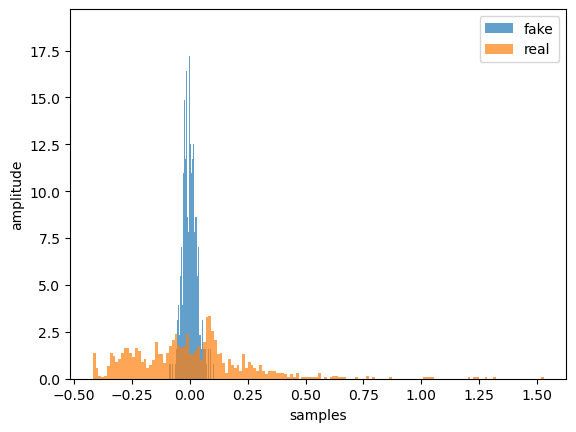

Epoch: 26 Loss D.: -0.03256600722670555 Loss G.: 0.003843813668936491 KL Divergence RG: 5.172319433785188 KL Divergence GR: 1.8326723975488013
Epoch 26


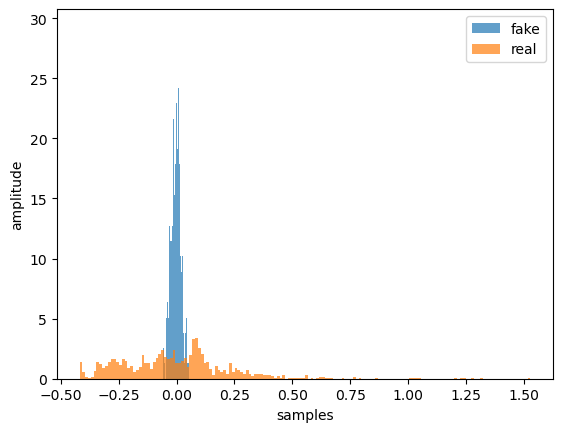

Epoch: 27 Loss D.: -0.04000813141465187 Loss G.: 0.003767716232687235 KL Divergence RG: 3.991045879139715 KL Divergence GR: 1.3272652285026916
Epoch 27


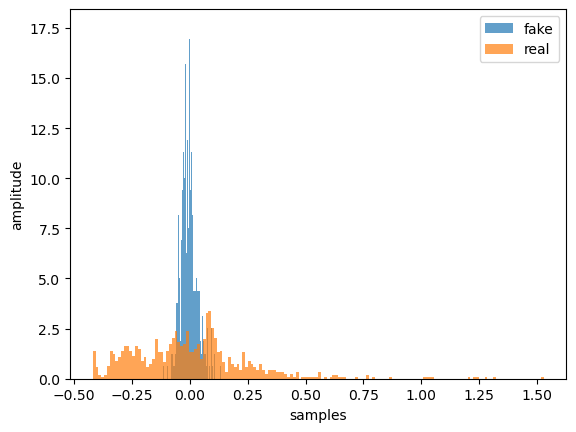

Epoch: 28 Loss D.: -0.0333108976483345 Loss G.: 0.006085279397666454 KL Divergence RG: 5.053293967647274 KL Divergence GR: 1.8139948306094054
Epoch 28


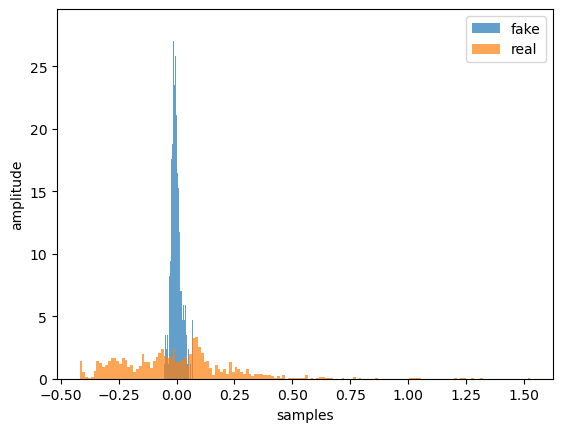

Epoch: 29 Loss D.: -0.04556133598089218 Loss G.: -0.001629645237699151 KL Divergence RG: 3.793914972998124 KL Divergence GR: 1.1304418116133284
Epoch 29


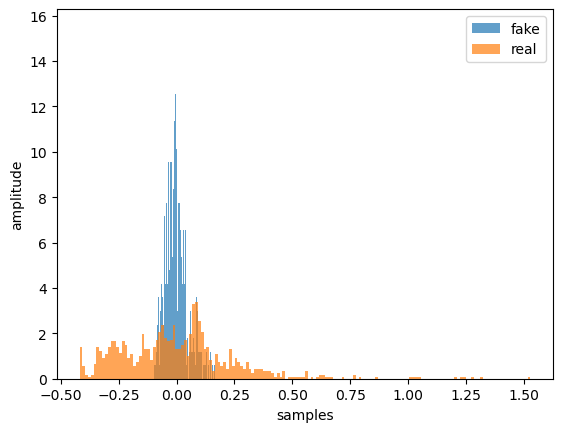

Epoch: 30 Loss D.: -0.03147668018937111 Loss G.: 0.0009839695412665606 KL Divergence RG: 4.482431936497182 KL Divergence GR: 1.6125478934416047
Epoch 30


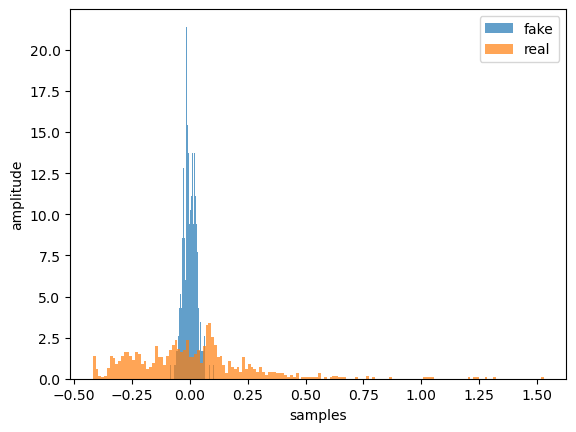

Epoch: 31 Loss D.: -0.05107496306300163 Loss G.: 0.0019722930155694485 KL Divergence RG: 4.4199621890634075 KL Divergence GR: 1.5392669843919462
Epoch 31


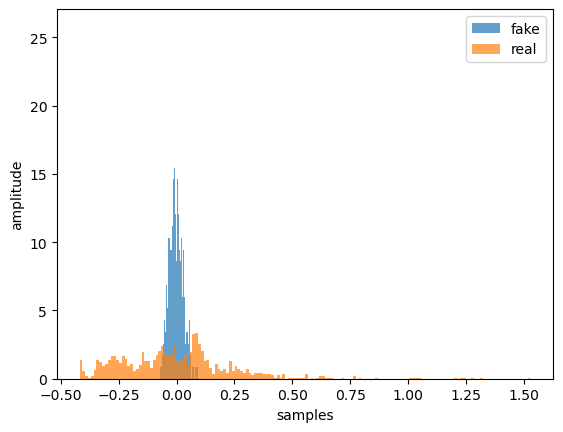

Epoch: 32 Loss D.: -0.0353323332965374 Loss G.: 0.003803200088441372 KL Divergence RG: 2.5898741619154886 KL Divergence GR: 0.6846221314860188
Epoch 32


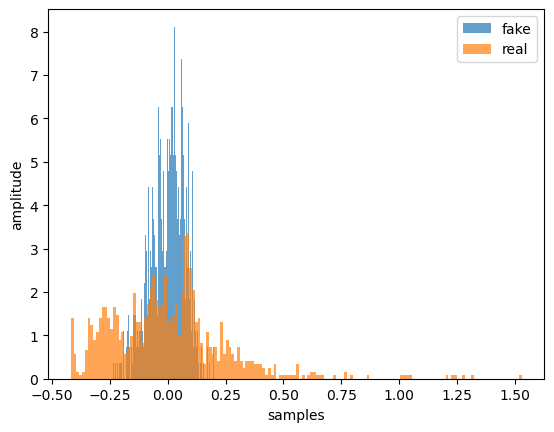

Epoch: 33 Loss D.: -0.03638646379113197 Loss G.: 0.009559947066009045 KL Divergence RG: 3.8945867646544086 KL Divergence GR: 1.2093224223841408
Epoch 33


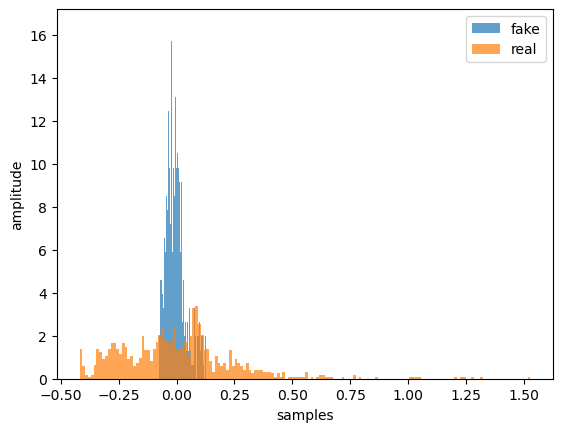

Epoch: 34 Loss D.: -0.03803771734237671 Loss G.: 0.0018946584314107895 KL Divergence RG: 3.541233964347593 KL Divergence GR: 0.976170851776326
Epoch 34


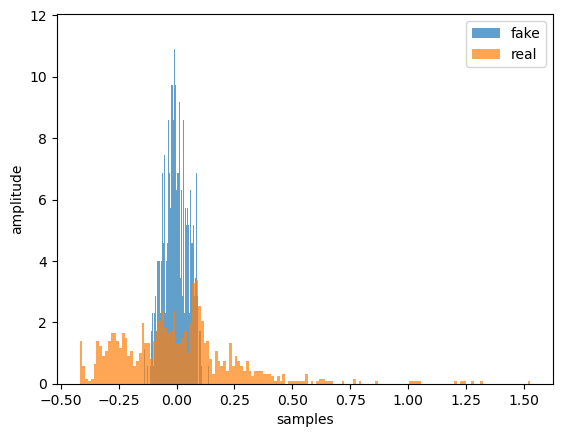

Epoch: 35 Loss D.: -0.031053995713591576 Loss G.: 0.00437706196680665 KL Divergence RG: 1.8876106861712705 KL Divergence GR: 0.439674872907596
Epoch 35


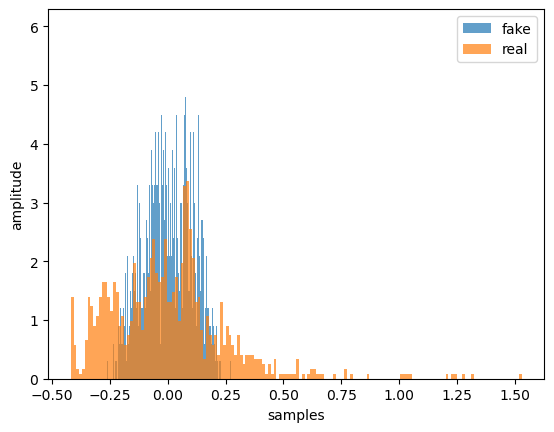

Epoch: 36 Loss D.: -0.025381069630384445 Loss G.: -0.005154907703399658 KL Divergence RG: 5.0978331628296605 KL Divergence GR: 1.8490439008223518
Epoch 36


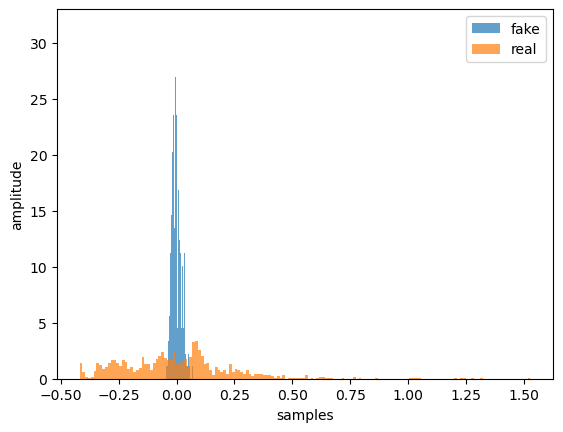

Epoch: 37 Loss D.: -0.034135933965444565 Loss G.: 0.0028213541954755783 KL Divergence RG: 4.901975405898552 KL Divergence GR: 1.6671633219588895
Epoch 37


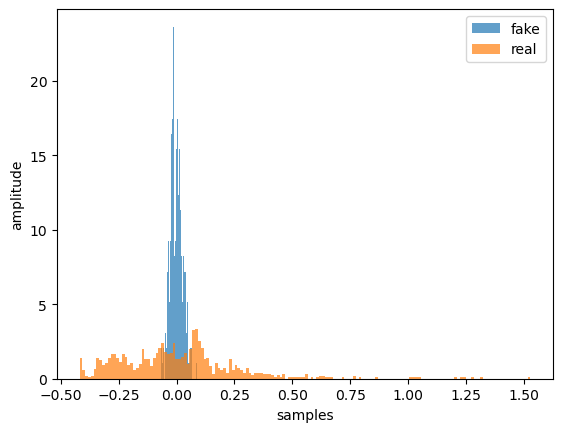

Epoch: 38 Loss D.: -0.02973848581314087 Loss G.: 0.00030329200671985745 KL Divergence RG: 4.870436538377639 KL Divergence GR: 1.5877688022626637
Epoch 38


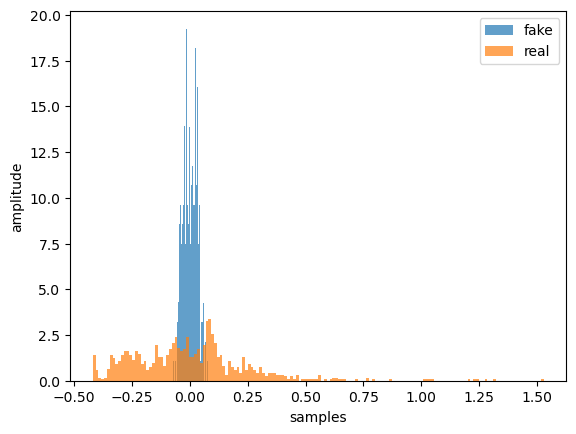

Epoch: 39 Loss D.: -0.03333716467022896 Loss G.: 0.004496775101870298 KL Divergence RG: 2.2193253673607956 KL Divergence GR: 0.5693215611133228
Epoch 39


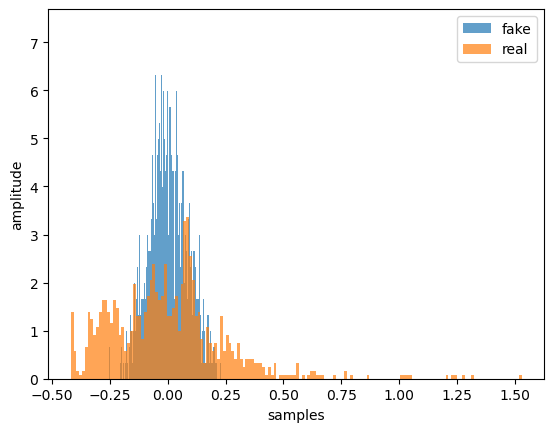

Epoch: 40 Loss D.: -0.03588928282260895 Loss G.: -0.002609953284263611 KL Divergence RG: 4.979963297699815 KL Divergence GR: 1.7300240378208522
Epoch 40


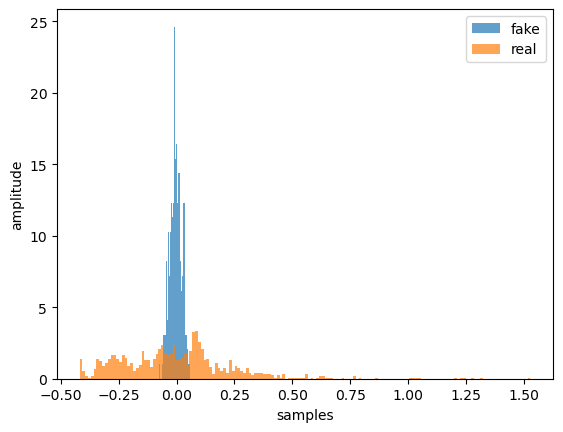

Epoch: 41 Loss D.: -0.036892861127853394 Loss G.: 0.006709984038025141 KL Divergence RG: 2.8289580189999546 KL Divergence GR: 0.6986698477811267
Epoch 41


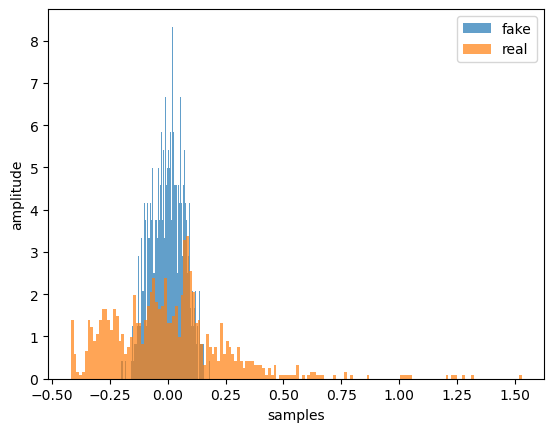

Epoch: 42 Loss D.: -0.03714102506637573 Loss G.: 0.00026891398010775447 KL Divergence RG: 4.303497742343879 KL Divergence GR: 1.4788087848248104
Epoch 42


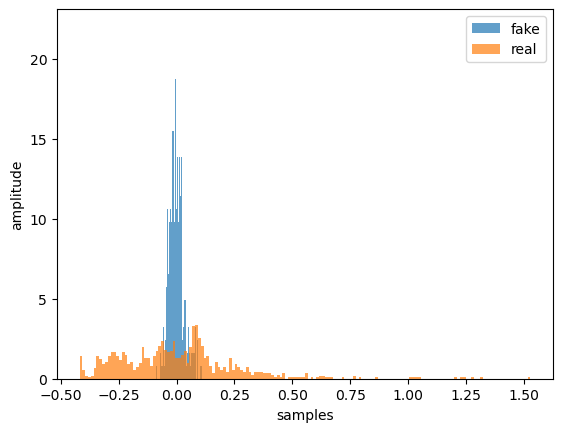

Epoch: 43 Loss D.: -0.03104553371667862 Loss G.: -0.0006284681730903685 KL Divergence RG: 2.6645722533760656 KL Divergence GR: 0.6027777086504122
Epoch 43


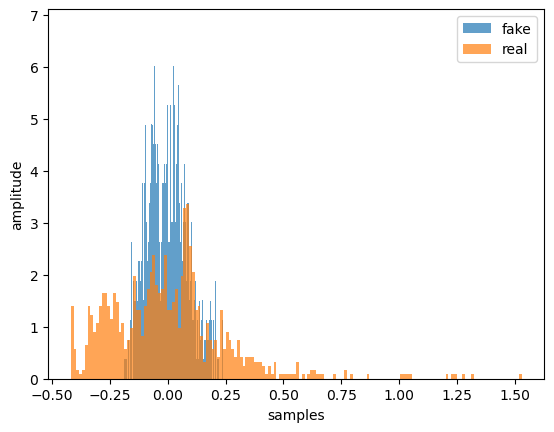

Epoch: 44 Loss D.: -0.03307165205478668 Loss G.: -0.010228359140455723 KL Divergence RG: 5.205625355189595 KL Divergence GR: 1.8747228672642542
Epoch 44


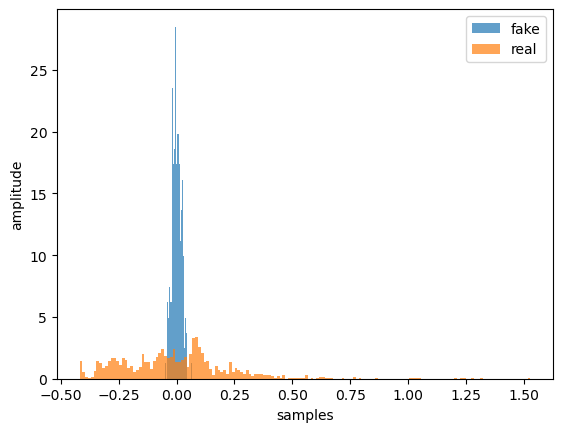

Epoch: 45 Loss D.: -0.035561542958021164 Loss G.: -0.005311320535838604 KL Divergence RG: 4.203297511256638 KL Divergence GR: 1.4011674290093181
Epoch 45


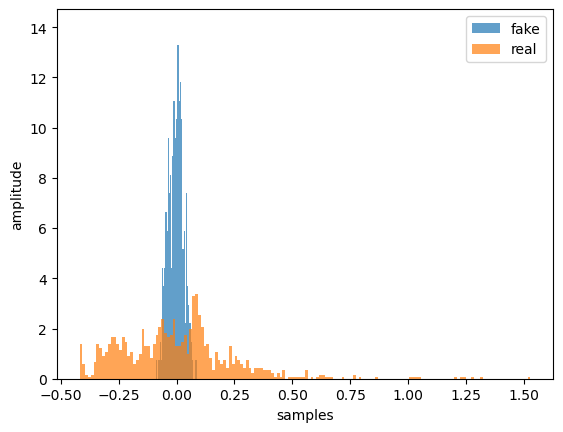

Epoch: 46 Loss D.: -0.04210827872157097 Loss G.: -0.006986148655414581 KL Divergence RG: 4.774521019727754 KL Divergence GR: 1.6128204718246864
Epoch 46


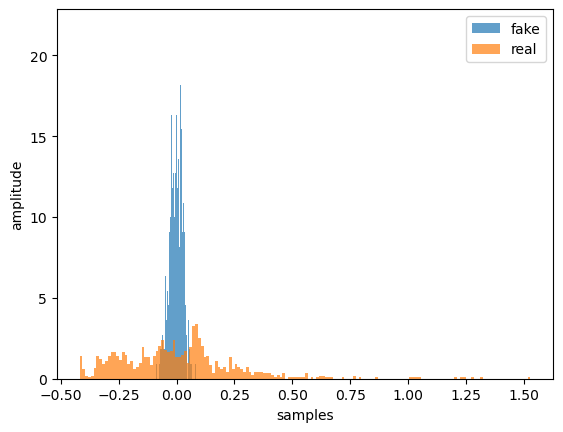

Epoch: 47 Loss D.: -0.03274046629667282 Loss G.: 0.004830542020499706 KL Divergence RG: 3.5219195708063937 KL Divergence GR: 1.0631451336756366
Epoch 47


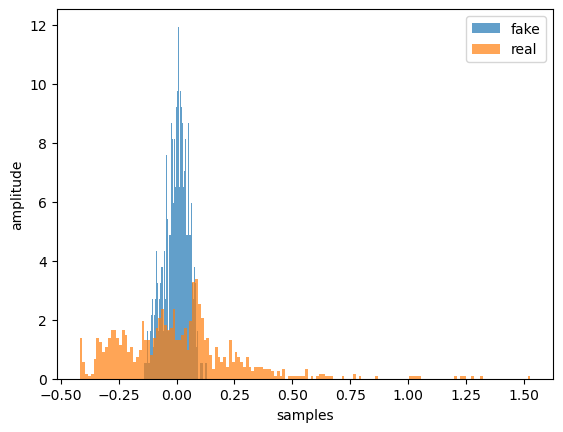

Epoch: 48 Loss D.: -0.04120204970240593 Loss G.: -0.00024982402101159096 KL Divergence RG: 4.873020839537814 KL Divergence GR: 1.6122851602758979
Epoch 48


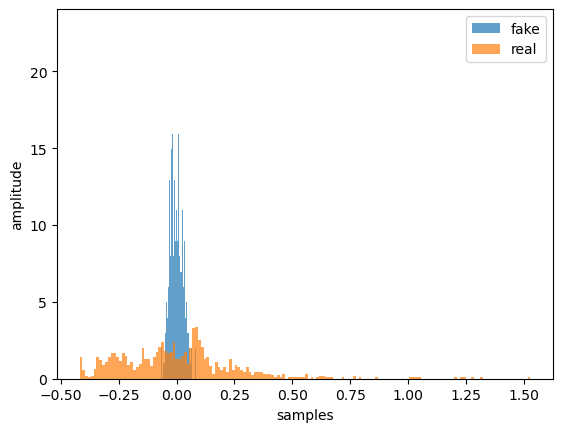

Epoch: 49 Loss D.: -0.0416063517332077 Loss G.: -0.007567617576569319 KL Divergence RG: 2.733338315666539 KL Divergence GR: 0.6481986167040492
Epoch 49


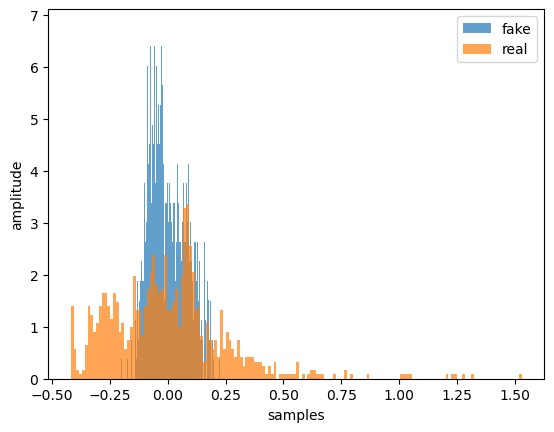

Epoch: 50 Loss D.: -0.03333866596221924 Loss G.: 0.0012231345754116774 KL Divergence RG: 4.644199876148347 KL Divergence GR: 1.5771365528092878
Epoch 50


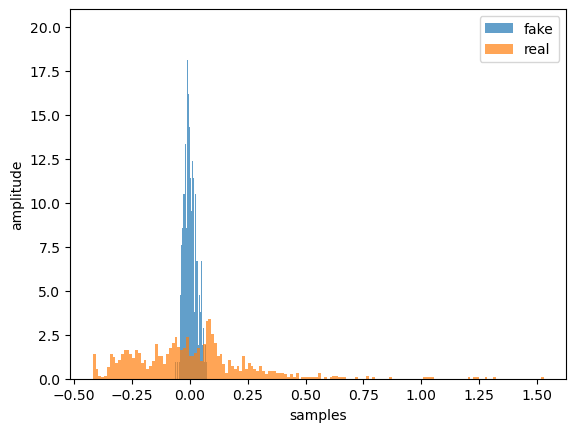

Epoch: 51 Loss D.: -0.031194204464554787 Loss G.: -0.001501886174082756 KL Divergence RG: 3.1053130436905914 KL Divergence GR: 1.037514958358796
Epoch 51


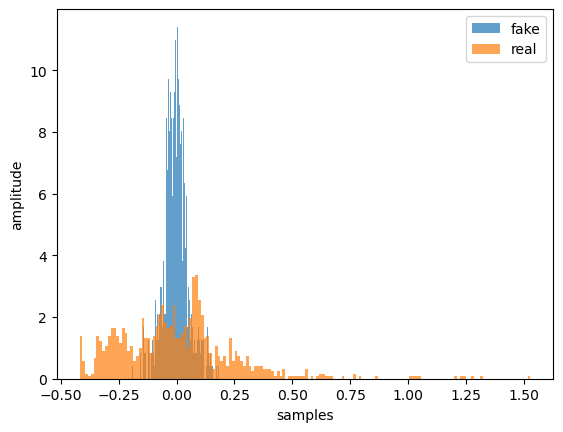

Epoch: 52 Loss D.: -0.03346492722630501 Loss G.: -0.0006152194691821933 KL Divergence RG: 3.894755715706017 KL Divergence GR: 1.2005928729610797
Epoch 52


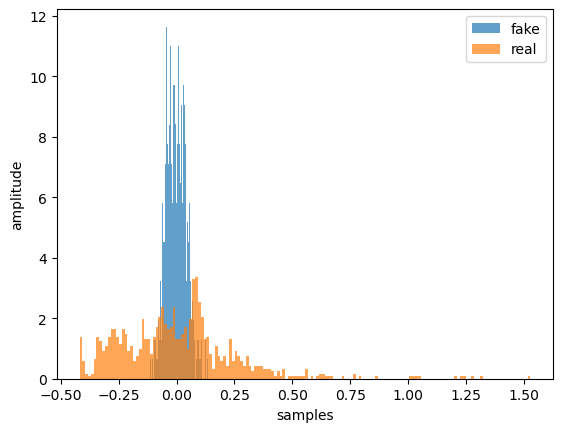

Epoch: 53 Loss D.: -0.03480757400393486 Loss G.: 0.00011692012776620686 KL Divergence RG: 0.5203007344321151 KL Divergence GR: 0.28081960301533726
Epoch 53


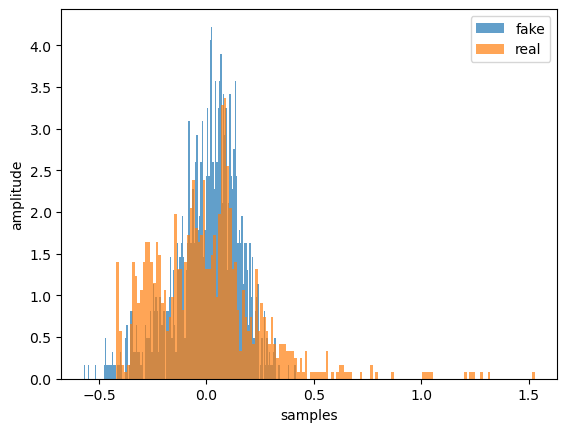

Epoch: 54 Loss D.: -0.03741003945469856 Loss G.: 0.00394908431917429 KL Divergence RG: 3.6628642253106776 KL Divergence GR: 1.06677137739507
Epoch 54


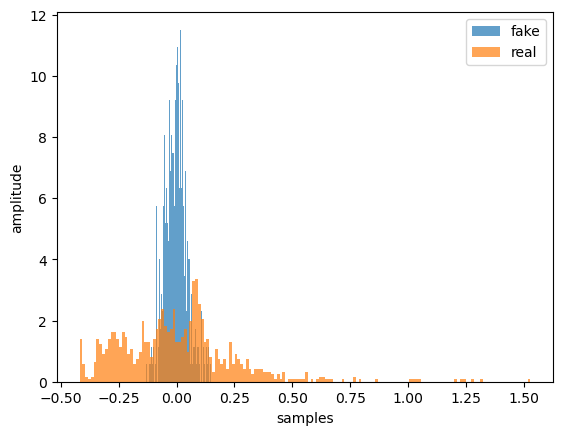

Epoch: 55 Loss D.: -0.04505253955721855 Loss G.: 0.0070333462208509445 KL Divergence RG: 3.5347426815739516 KL Divergence GR: 1.0829506399935436
Epoch 55


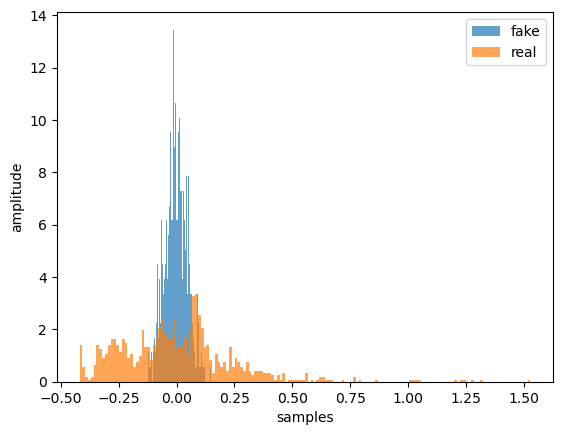

Epoch: 56 Loss D.: -0.033393360674381256 Loss G.: -0.009822141379117966 KL Divergence RG: 3.5716813625551165 KL Divergence GR: 1.1385487554684774
Epoch 56


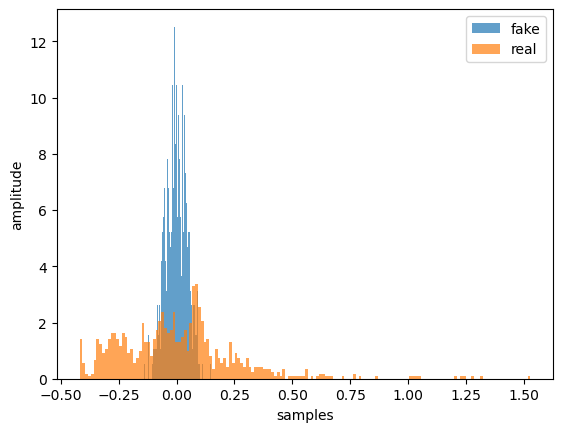

Epoch: 57 Loss D.: -0.03987789899110794 Loss G.: -0.005507824942469597 KL Divergence RG: 3.9428567410533395 KL Divergence GR: 1.1158487378432174
Epoch 57


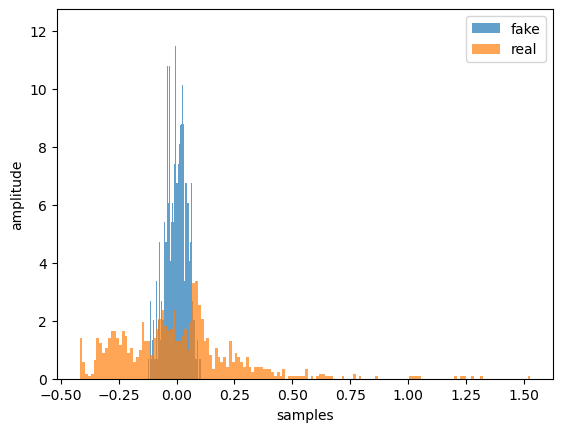

Epoch: 58 Loss D.: -0.04348025098443031 Loss G.: 0.010731824673712254 KL Divergence RG: 4.051340178861605 KL Divergence GR: 1.2594185594187357
Epoch 58


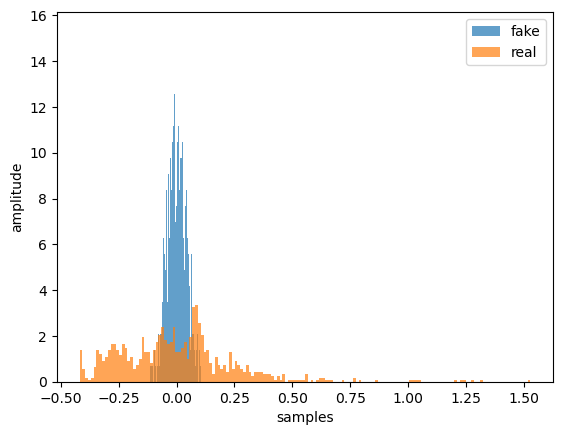

Epoch: 59 Loss D.: -0.034335535019636154 Loss G.: 0.004050564486533403 KL Divergence RG: 3.5664992432306266 KL Divergence GR: 1.0516815798111923
Epoch 59


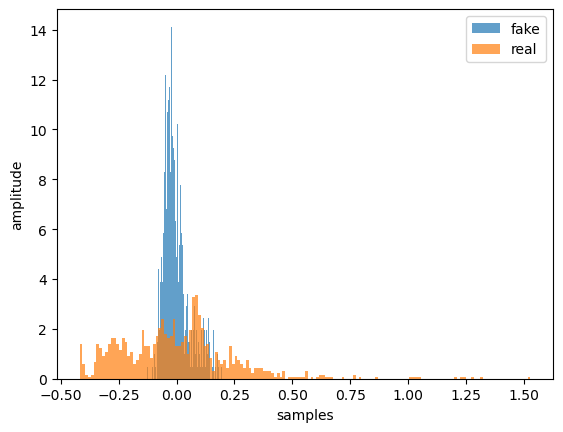

Epoch: 60 Loss D.: -0.03477248176932335 Loss G.: 0.006558213848620653 KL Divergence RG: 3.6581177941170897 KL Divergence GR: 1.1113834306341528
Epoch 60


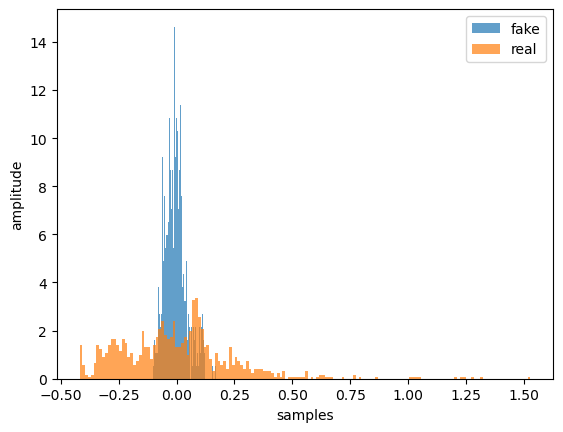

Epoch: 61 Loss D.: -0.0345945842564106 Loss G.: 0.0038424809463322163 KL Divergence RG: 4.195019451596883 KL Divergence GR: 1.4254014569457751
Epoch 61


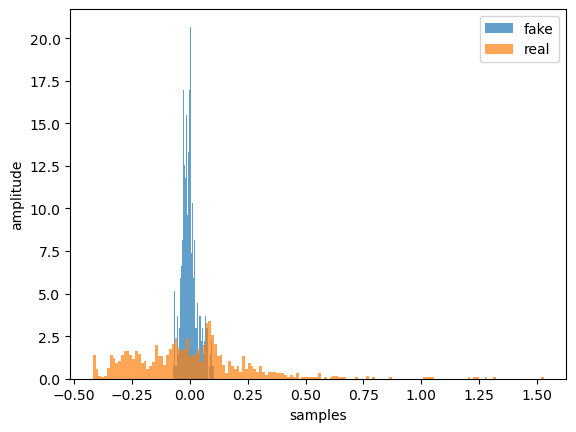

Epoch: 62 Loss D.: -0.04147956520318985 Loss G.: 0.00580187700688839 KL Divergence RG: 2.099069667649407 KL Divergence GR: 0.48448054296230547
Epoch 62


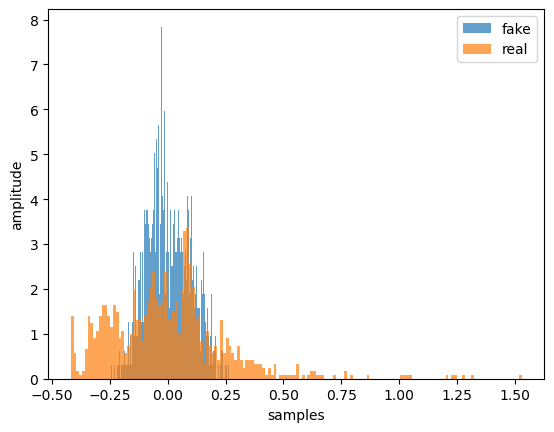

Epoch: 63 Loss D.: -0.0339679941534996 Loss G.: 0.00044411810813471675 KL Divergence RG: 4.880953169997303 KL Divergence GR: 1.6869803443071454
Epoch 63


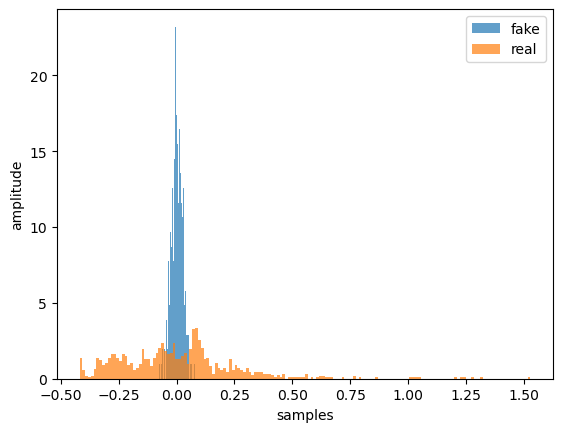

Epoch: 64 Loss D.: -0.044581376016139984 Loss G.: -0.011074069887399673 KL Divergence RG: 3.7176869113104702 KL Divergence GR: 1.1490390746165229
Epoch 64


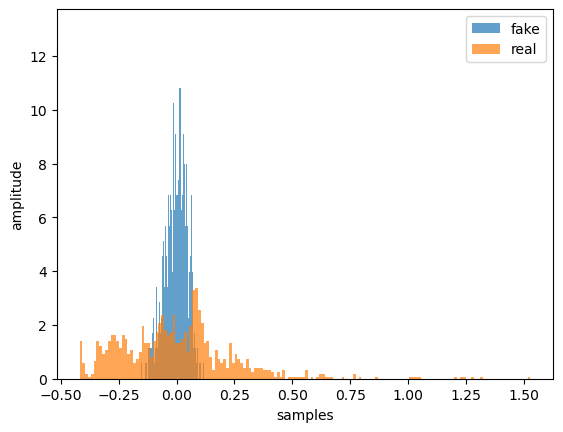

Epoch: 65 Loss D.: -0.037709712982177734 Loss G.: 0.004916321486234665 KL Divergence RG: 4.994732883253027 KL Divergence GR: 1.7814793790015784
Epoch 65


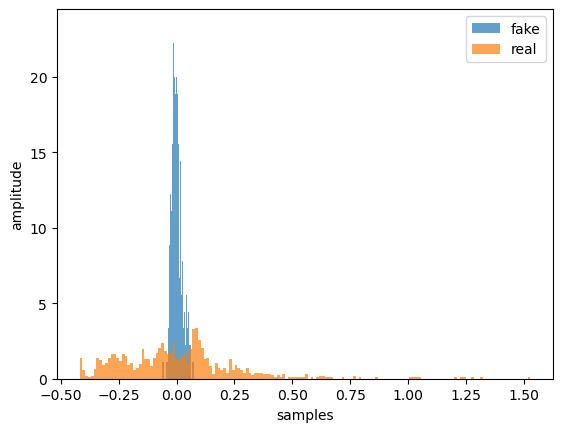

Epoch: 66 Loss D.: -0.03374524414539337 Loss G.: -7.885514060035348e-05 KL Divergence RG: 3.701714941210567 KL Divergence GR: 1.0842317457276296
Epoch 66


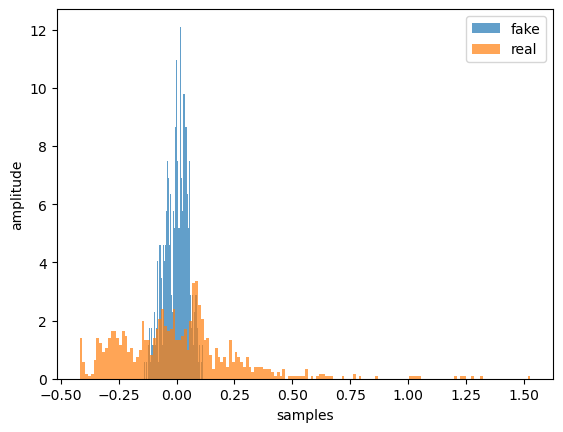

Epoch: 67 Loss D.: -0.03645428270101547 Loss G.: -0.0020054548513144255 KL Divergence RG: 3.3972470884933768 KL Divergence GR: 0.9334646693202123
Epoch 67


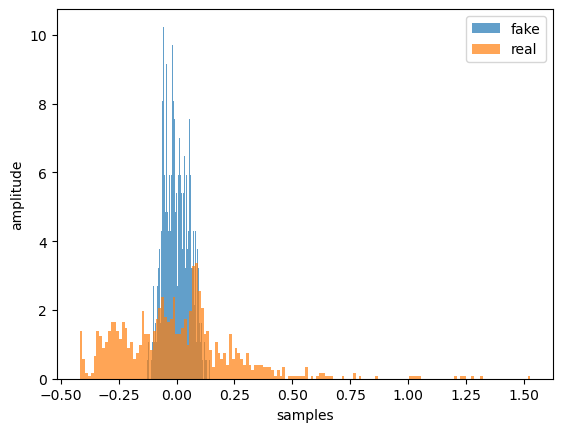

Epoch: 68 Loss D.: -0.034909047186374664 Loss G.: 0.004154718481004238 KL Divergence RG: 3.444494005795347 KL Divergence GR: 0.9920058734378706
Epoch 68


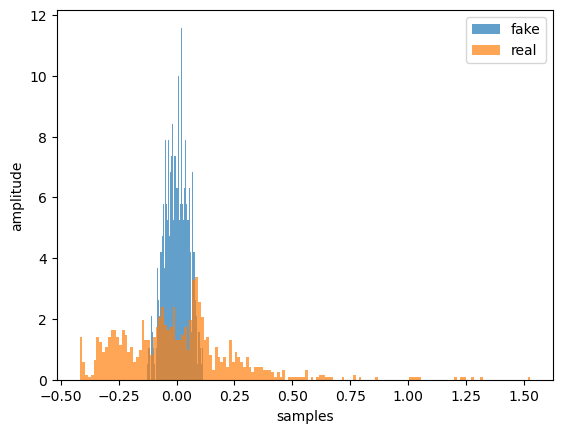

Epoch: 69 Loss D.: -0.03168288618326187 Loss G.: 0.0010758382268249989 KL Divergence RG: 3.2830455041758047 KL Divergence GR: 0.8825832858704941
Epoch 69


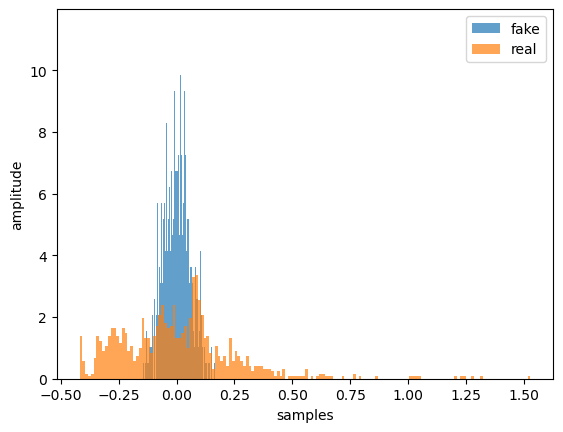

Epoch: 70 Loss D.: -0.03457723557949066 Loss G.: 0.004250793717801571 KL Divergence RG: 4.7145859585585335 KL Divergence GR: 1.5820156485662342
Epoch 70


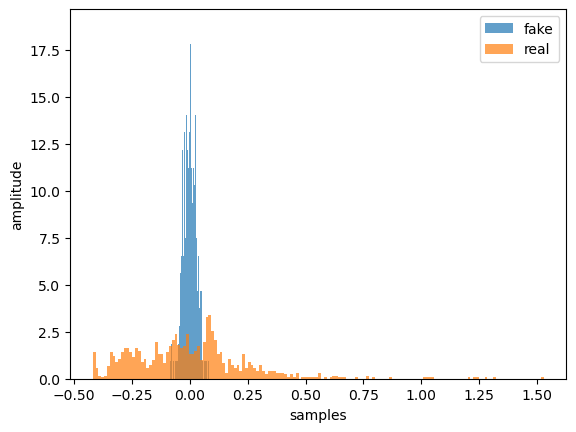

Epoch: 71 Loss D.: -0.035080187022686005 Loss G.: 0.0026937210932374 KL Divergence RG: 3.217321180237394 KL Divergence GR: 0.8899697972704493
Epoch 71


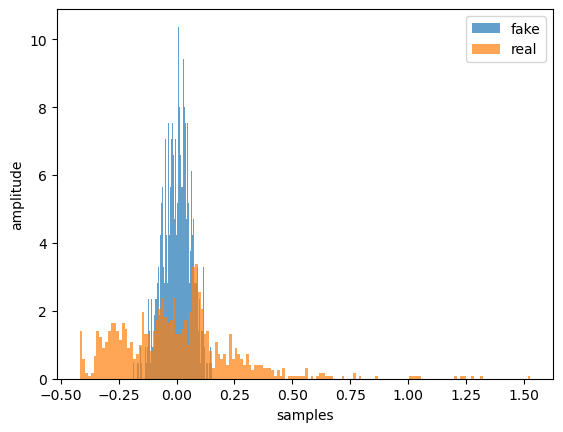

Epoch: 72 Loss D.: -0.03798062354326248 Loss G.: 0.0035354646388441324 KL Divergence RG: 3.5624980768169126 KL Divergence GR: 1.084651635192295
Epoch 72


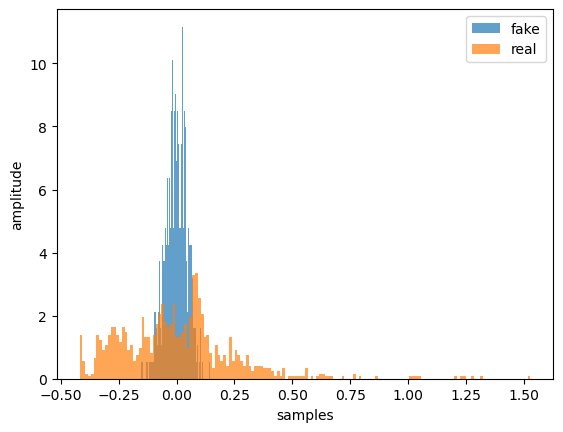

Epoch: 73 Loss D.: -0.03523259609937668 Loss G.: -0.012393370270729065 KL Divergence RG: 0.7390480685740068 KL Divergence GR: 0.3224980588616083
Epoch 73


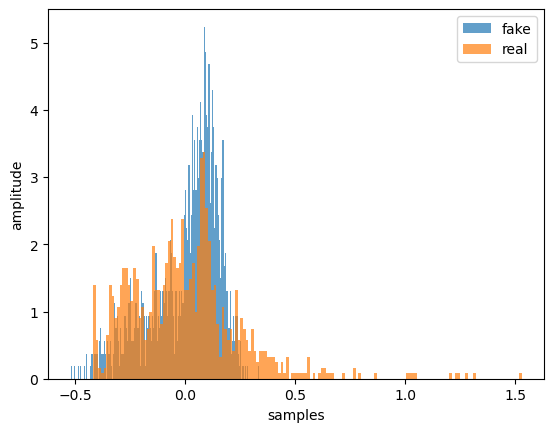

Epoch: 74 Loss D.: -0.04015519469976425 Loss G.: -0.0013377269497141242 KL Divergence RG: 5.481277956968678 KL Divergence GR: 2.0560425843007692
Epoch 74


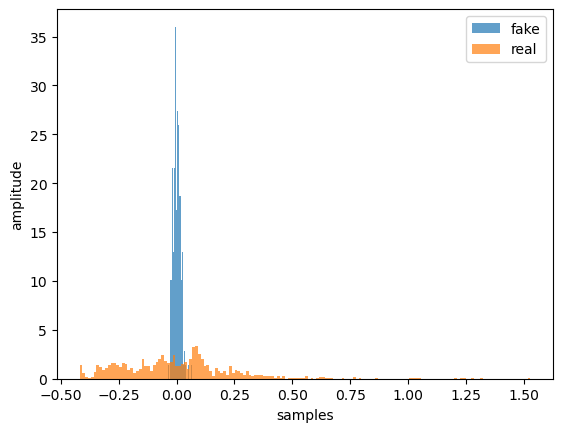

Epoch: 75 Loss D.: -0.04182077571749687 Loss G.: 0.0011229027295485139 KL Divergence RG: 3.90356383345209 KL Divergence GR: 1.184511148451006
Epoch 75


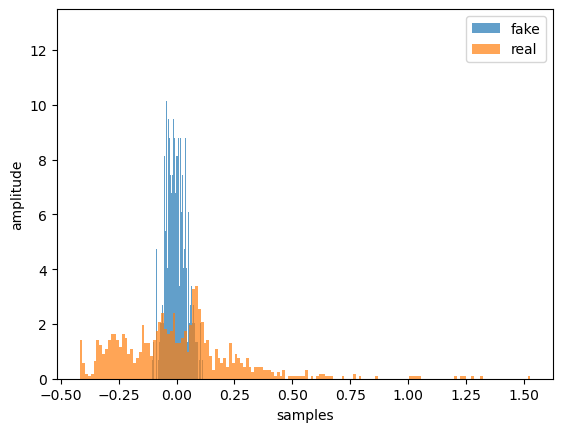

Epoch: 76 Loss D.: -0.037030644714832306 Loss G.: 0.003903885604813695 KL Divergence RG: 3.354721543260421 KL Divergence GR: 1.089809519566769
Epoch 76


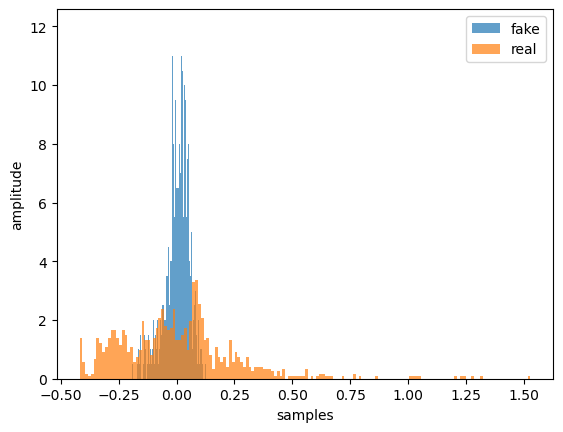

Epoch: 77 Loss D.: -0.030811581760644913 Loss G.: -0.0010163142578676343 KL Divergence RG: 4.690559555986905 KL Divergence GR: 1.490010368626748
Epoch 77


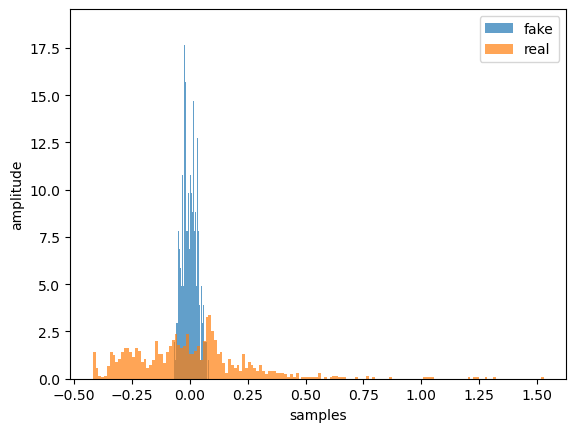

Epoch: 78 Loss D.: -0.03288176655769348 Loss G.: -0.0063176341354846954 KL Divergence RG: 4.807900866458407 KL Divergence GR: 1.6243792025502175
Epoch 78


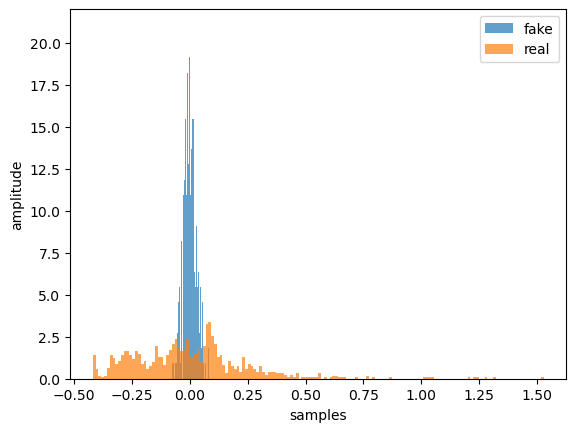

Epoch: 79 Loss D.: -0.03199983388185501 Loss G.: 0.004298207350075245 KL Divergence RG: 5.029808710299602 KL Divergence GR: 1.7286586836273863
Epoch 79


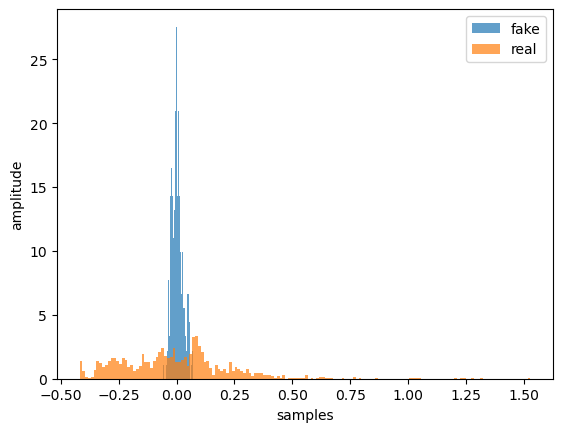

Epoch: 80 Loss D.: -0.03099103271961212 Loss G.: -8.090917253866792e-05 KL Divergence RG: 5.244320069870014 KL Divergence GR: 1.8324820906583736
Epoch 80


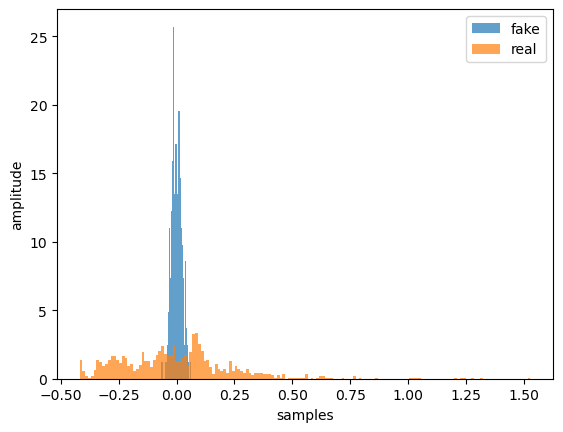

Epoch: 81 Loss D.: -0.03529006242752075 Loss G.: -0.002620138693600893 KL Divergence RG: 3.501441460150696 KL Divergence GR: 1.0738355967139277
Epoch 81


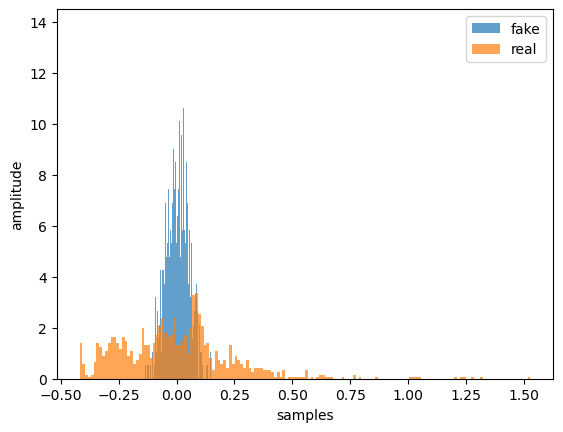

Epoch: 82 Loss D.: -0.03269124776124954 Loss G.: -0.005294850096106529 KL Divergence RG: 3.7630264826283266 KL Divergence GR: 1.0617747199291088
Epoch 82


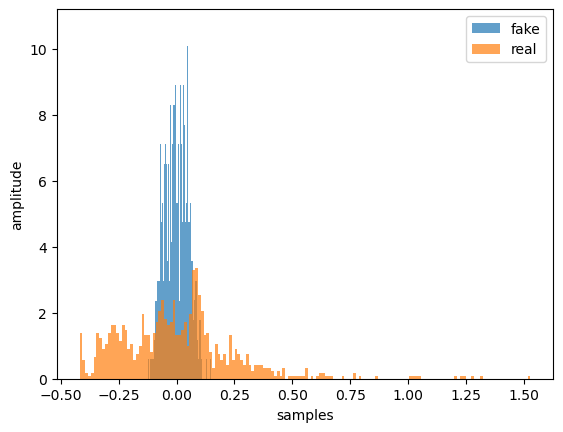

Epoch: 83 Loss D.: -0.03855752572417259 Loss G.: -0.009982247836887836 KL Divergence RG: 3.3097084164969974 KL Divergence GR: 0.8988796836621753
Epoch 83


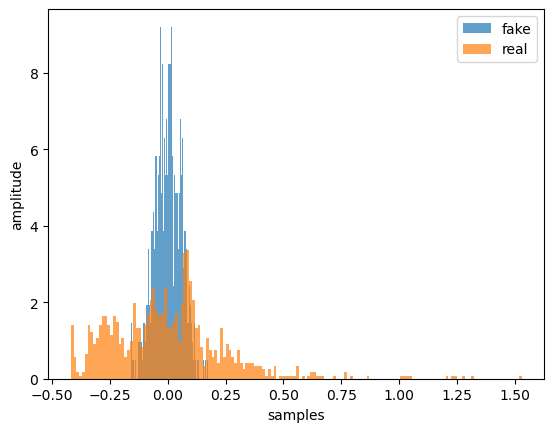

Epoch: 84 Loss D.: -0.0323856882750988 Loss G.: 0.00021885050227865577 KL Divergence RG: 3.0747687231225775 KL Divergence GR: 0.8488518846080495
Epoch 84


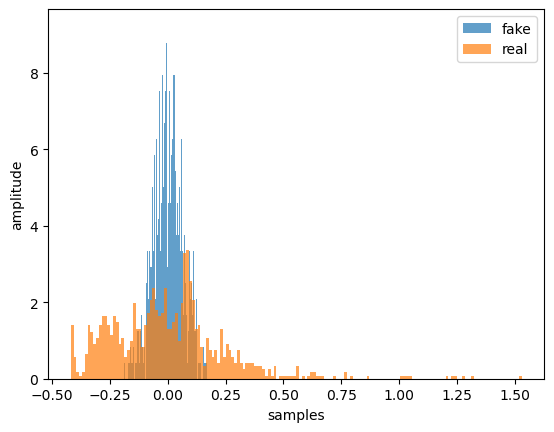

Epoch: 85 Loss D.: -0.043116405606269836 Loss G.: 0.001838858355768025 KL Divergence RG: 3.731713423577556 KL Divergence GR: 1.1992181361262328
Epoch 85


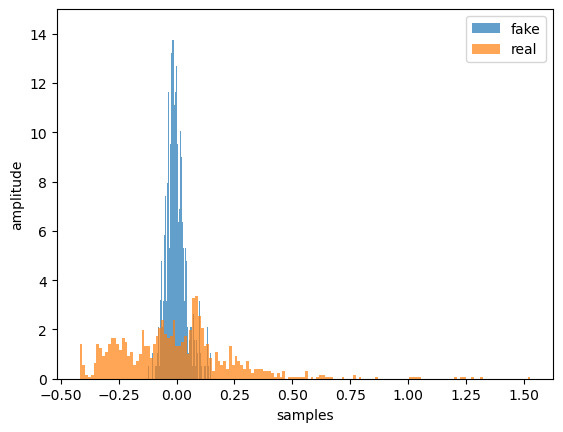

Epoch: 86 Loss D.: -0.03258844465017319 Loss G.: -0.01048118807375431 KL Divergence RG: 3.1435567577745234 KL Divergence GR: 0.8644184793621881
Epoch 86


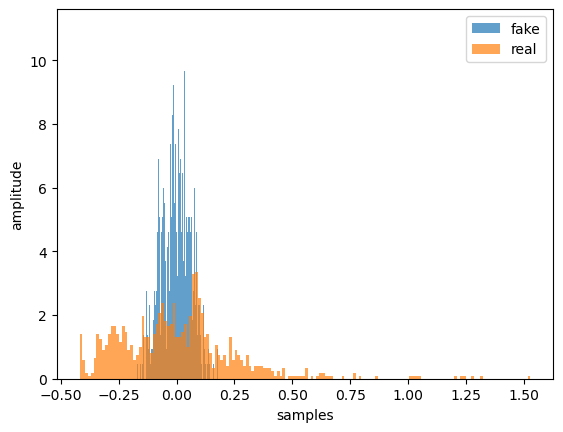

Epoch: 87 Loss D.: -0.03102285787463188 Loss G.: -0.002683348720893264 KL Divergence RG: 3.3962802420970197 KL Divergence GR: 0.9235119995505044
Epoch 87


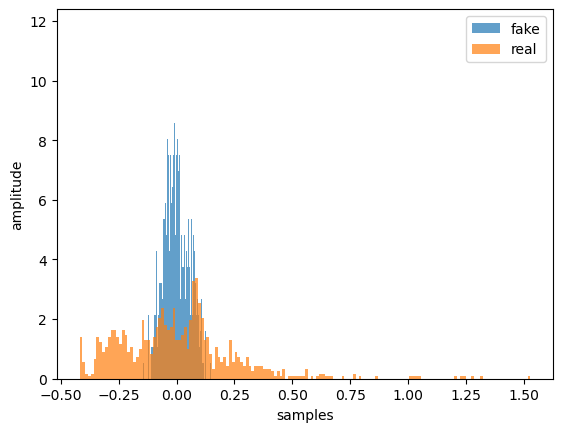

Epoch: 88 Loss D.: -0.041786789894104004 Loss G.: -0.005166004877537489 KL Divergence RG: 3.154645655761608 KL Divergence GR: 0.9901689690300212
Epoch 88


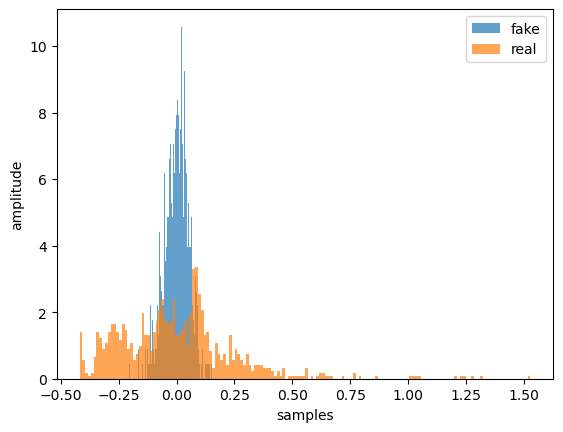

Epoch: 89 Loss D.: -0.04261092096567154 Loss G.: 0.004121799487620592 KL Divergence RG: 2.7813314023846933 KL Divergence GR: 0.6813728668742266
Epoch 89


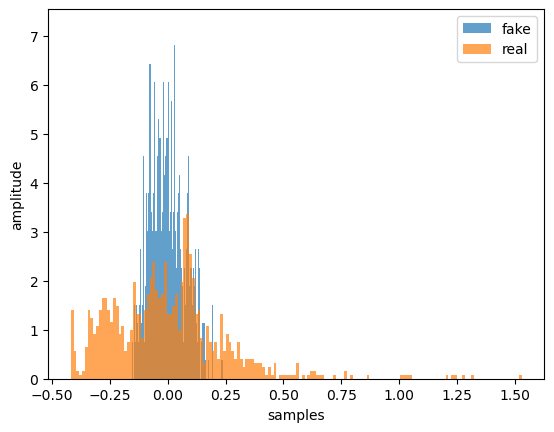

Epoch: 90 Loss D.: -0.036705102771520615 Loss G.: 0.0030200649052858353 KL Divergence RG: 4.292771835975548 KL Divergence GR: 1.4773650627836072
Epoch 90


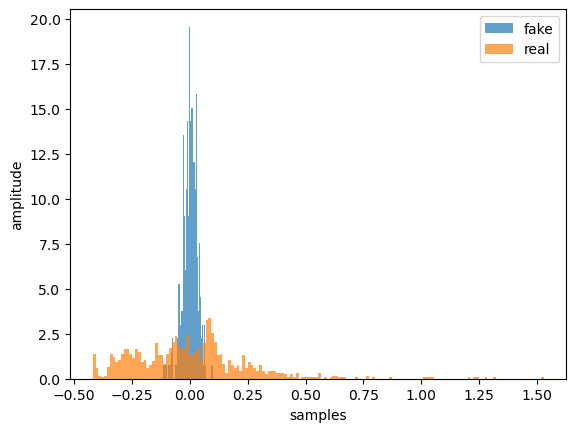

Epoch: 91 Loss D.: -0.036240220069885254 Loss G.: -0.0012056664563715458 KL Divergence RG: 2.6073154462437946 KL Divergence GR: 0.6771417639091332
Epoch 91


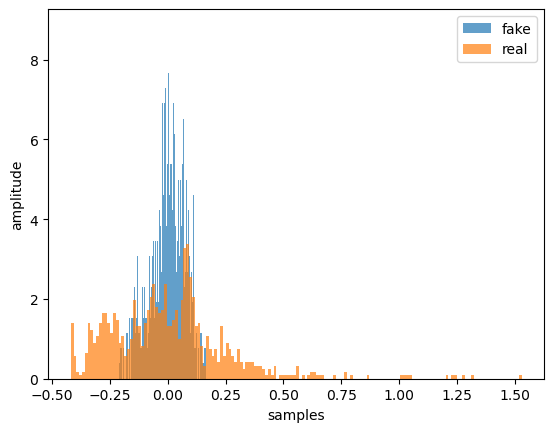

Epoch: 92 Loss D.: -0.034310247749090195 Loss G.: 0.003142316360026598 KL Divergence RG: 4.1583250060146675 KL Divergence GR: 1.2910106228951979
Epoch 92


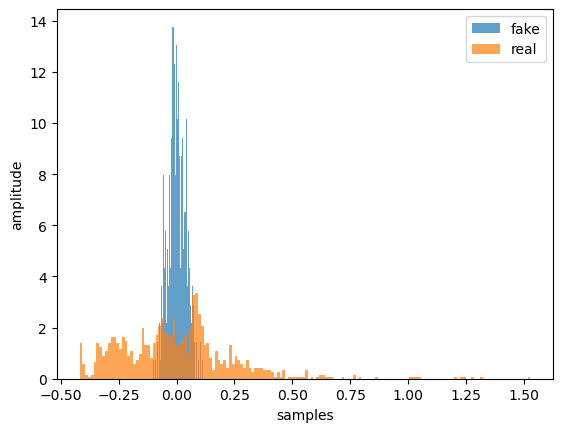

Epoch: 93 Loss D.: -0.03723033890128136 Loss G.: 0.0030130234081298113 KL Divergence RG: 2.50716087291668 KL Divergence GR: 0.6367380560429114
Epoch 93


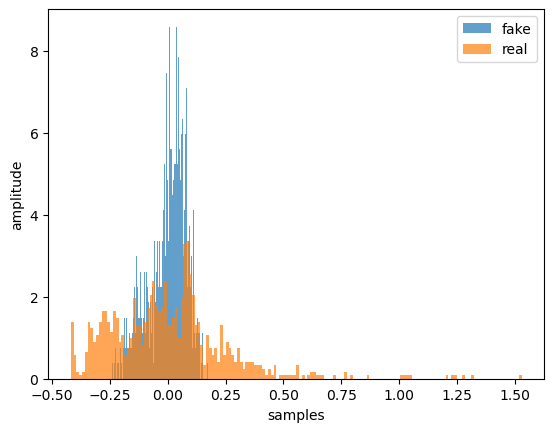

Epoch: 94 Loss D.: -0.03074660897254944 Loss G.: -0.008236286230385303 KL Divergence RG: 4.346402143273633 KL Divergence GR: 1.4294146673911807
Epoch 94


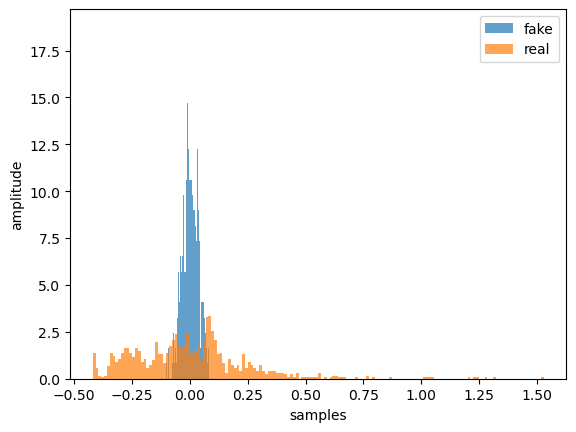

Epoch: 95 Loss D.: -0.03424454107880592 Loss G.: -0.003783493535593152 KL Divergence RG: 4.586156217702782 KL Divergence GR: 1.4604186759261526
Epoch 95


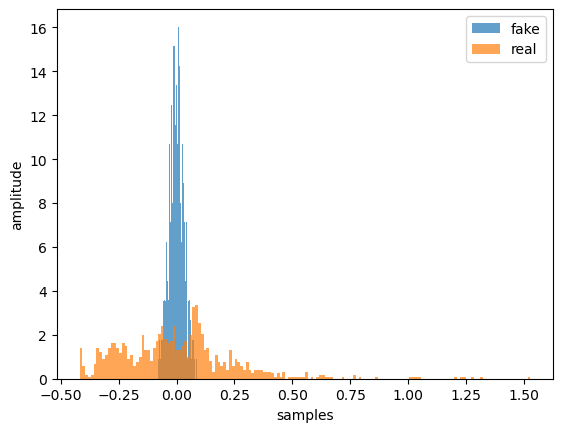

Epoch: 96 Loss D.: -0.03426355868577957 Loss G.: 0.006345668807625771 KL Divergence RG: 3.5577265989622493 KL Divergence GR: 1.057798514504569
Epoch 96


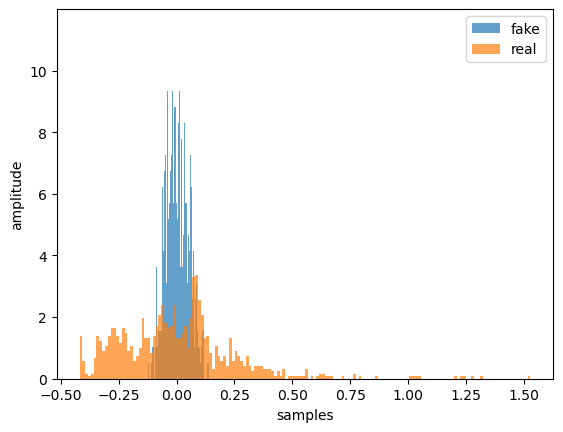

Epoch: 97 Loss D.: -0.03375424072146416 Loss G.: -0.0012890511425212026 KL Divergence RG: 3.865426136672203 KL Divergence GR: 1.2154070460007451
Epoch 97


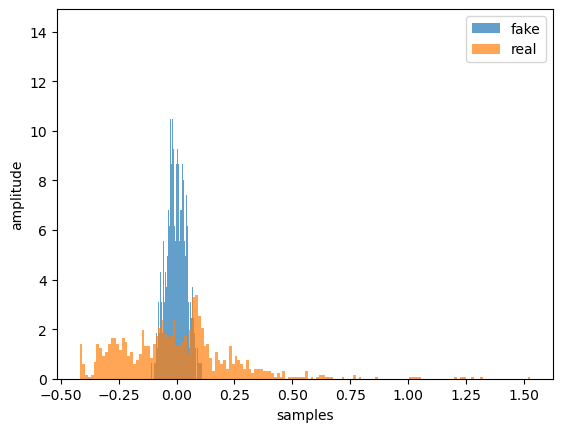

Epoch: 98 Loss D.: -0.03359466791152954 Loss G.: -0.0010356971761211753 KL Divergence RG: 4.25429656524574 KL Divergence GR: 1.4775755959109718
Epoch 98


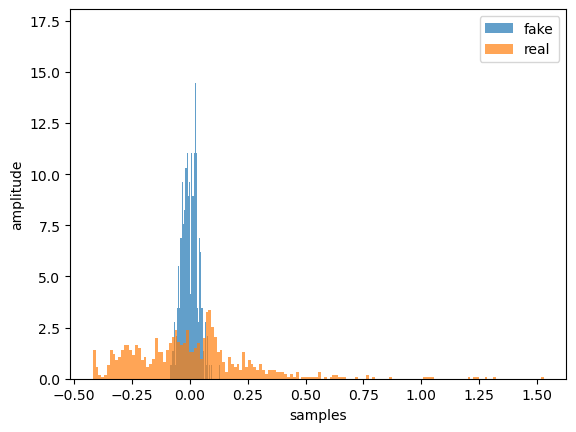

Epoch: 99 Loss D.: -0.030344609171152115 Loss G.: 0.003955545369535685 KL Divergence RG: 4.0815141182581405 KL Divergence GR: 1.2898492273500888
Epoch 99


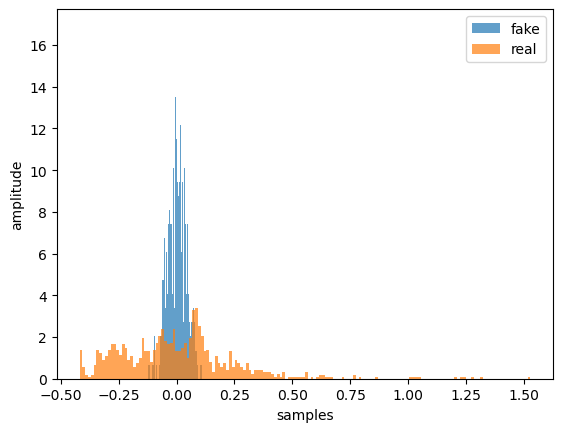

Epoch: 100 Loss D.: -0.038100868463516235 Loss G.: 0.004415384493768215 KL Divergence RG: 4.181833315414175 KL Divergence GR: 1.3512697230153545
Epoch 100


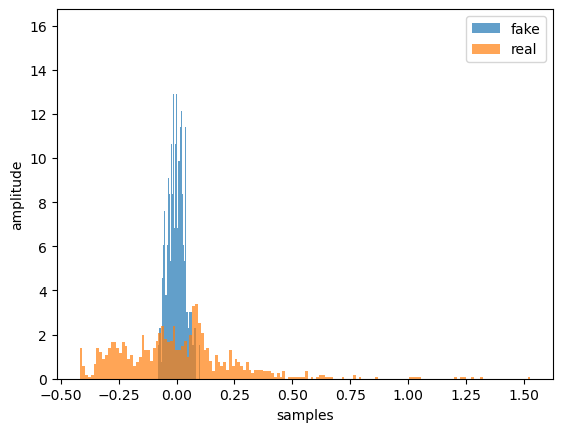

Epoch: 101 Loss D.: -0.03103584796190262 Loss G.: 0.00044304796028882265 KL Divergence RG: 2.2417017419604894 KL Divergence GR: 0.5287597128355214
Epoch 101


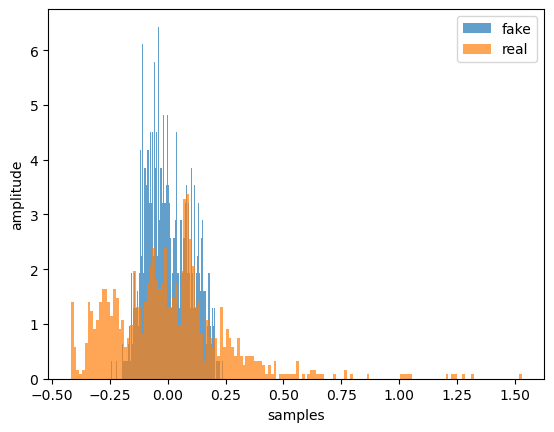

Epoch: 102 Loss D.: -0.032150451093912125 Loss G.: -0.0009254286997020245 KL Divergence RG: 3.508611001755227 KL Divergence GR: 1.1063278545342043
Epoch 102


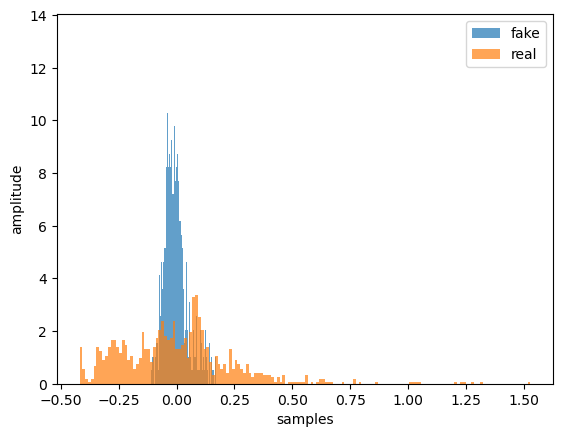

Epoch: 103 Loss D.: -0.03506699576973915 Loss G.: 0.0008511687046848238 KL Divergence RG: 4.017881455298916 KL Divergence GR: 1.3546387623949736
Epoch 103


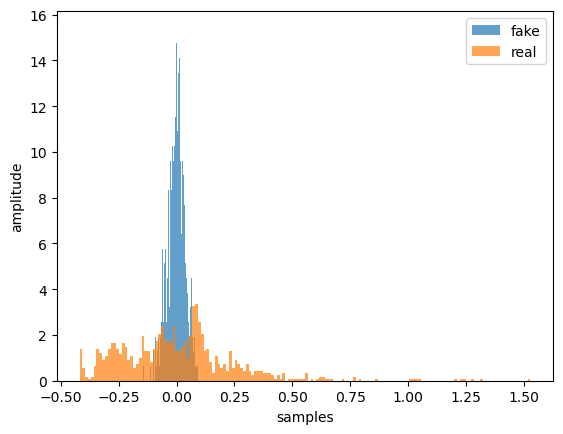

Epoch: 104 Loss D.: -0.06747651100158691 Loss G.: -0.011777658946812153 KL Divergence RG: 3.7035741308650665 KL Divergence GR: 1.1578690620155758
Epoch 104


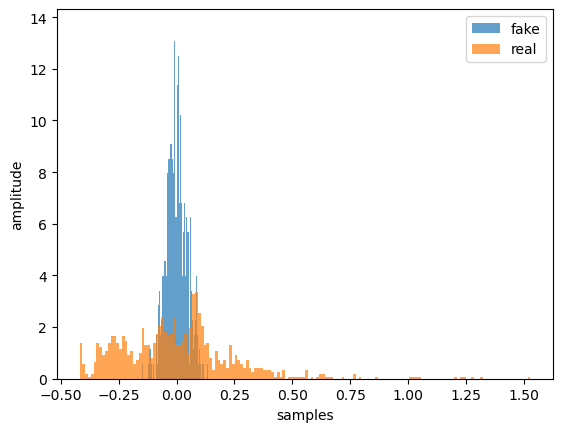

Epoch: 105 Loss D.: -0.04666212201118469 Loss G.: 0.006637575104832649 KL Divergence RG: 4.4598730379004 KL Divergence GR: 1.5480052136922575
Epoch 105


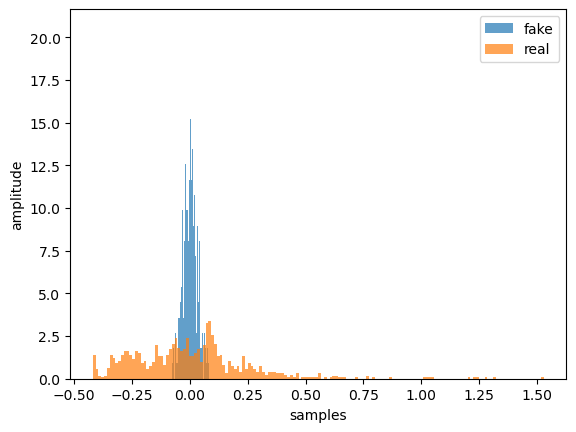

Epoch: 106 Loss D.: -0.03688043728470802 Loss G.: -0.0021375182550400496 KL Divergence RG: 1.7522227904350267 KL Divergence GR: 0.5189105235562089
Epoch 106


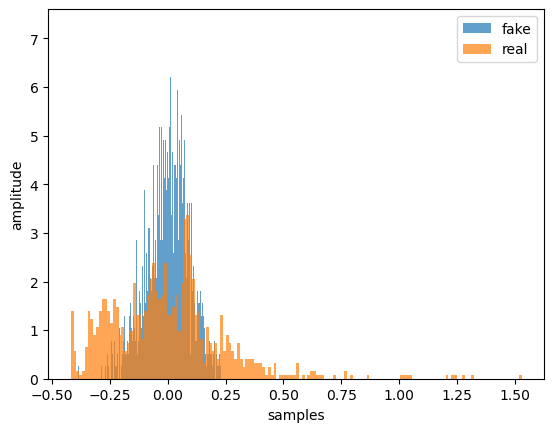

Epoch: 107 Loss D.: -0.03500331938266754 Loss G.: 0.0027531981468200684 KL Divergence RG: 4.387141919859266 KL Divergence GR: 1.5091002010963528
Epoch 107


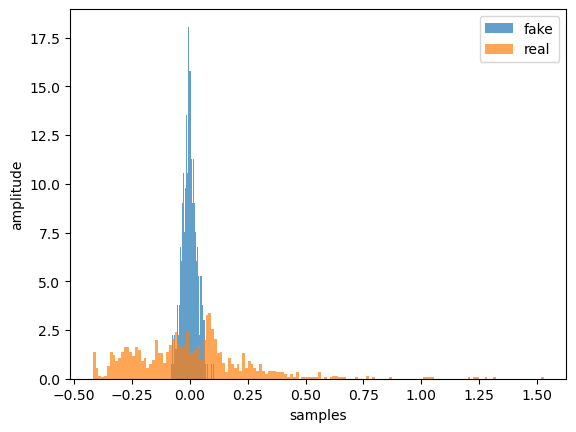

Epoch: 108 Loss D.: -0.036237429827451706 Loss G.: -0.0020122830756008625 KL Divergence RG: 4.365175290218042 KL Divergence GR: 1.470946416920357
Epoch 108


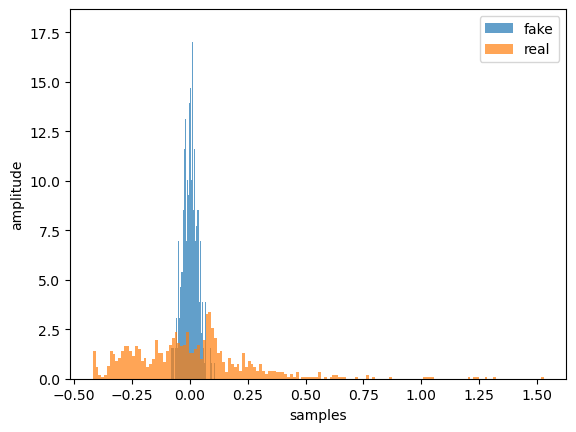

Epoch: 109 Loss D.: -0.031829364597797394 Loss G.: -0.002530294004827738 KL Divergence RG: 4.396797031120359 KL Divergence GR: 1.3835915524083264
Epoch 109


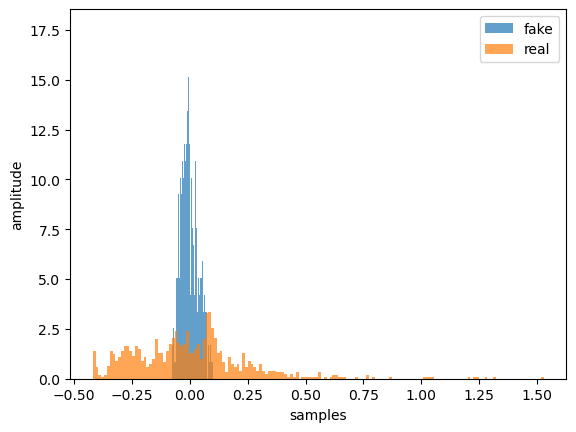

Epoch: 110 Loss D.: -0.047463309019804 Loss G.: -0.013288966380059719 KL Divergence RG: 3.545716005235886 KL Divergence GR: 1.091090022350005
Epoch 110


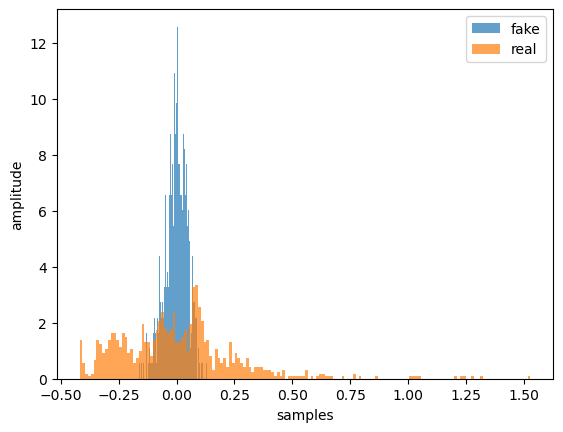

Epoch: 111 Loss D.: -0.02769511006772518 Loss G.: -0.009252364747226238 KL Divergence RG: 3.2186894725345567 KL Divergence GR: 0.8320550247998425
Epoch 111


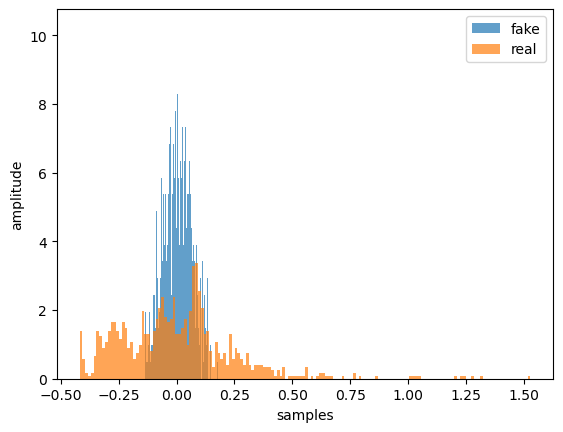

Epoch: 112 Loss D.: -0.02946959063410759 Loss G.: -0.0006153818685561419 KL Divergence RG: 3.7770449717406223 KL Divergence GR: 1.1841153359867713
Epoch 112


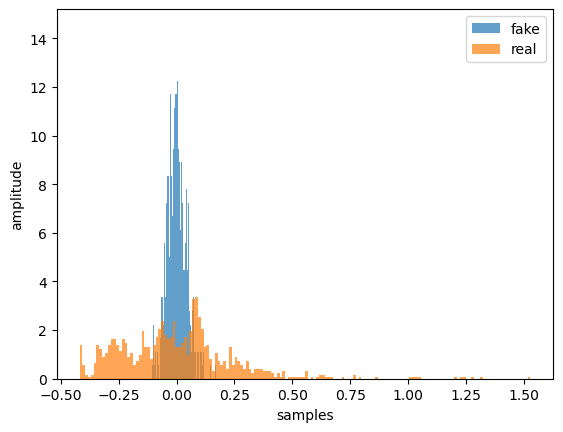

Epoch: 113 Loss D.: -0.03744669631123543 Loss G.: -0.005925818346440792 KL Divergence RG: 3.78472668054409 KL Divergence GR: 1.314094473856575
Epoch 113


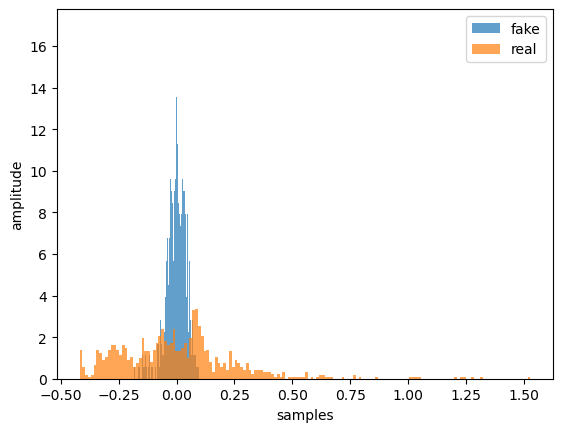

Epoch: 114 Loss D.: -0.032248374074697495 Loss G.: 0.001080330228433013 KL Divergence RG: 3.086972350444115 KL Divergence GR: 0.8823490159455285
Epoch 114


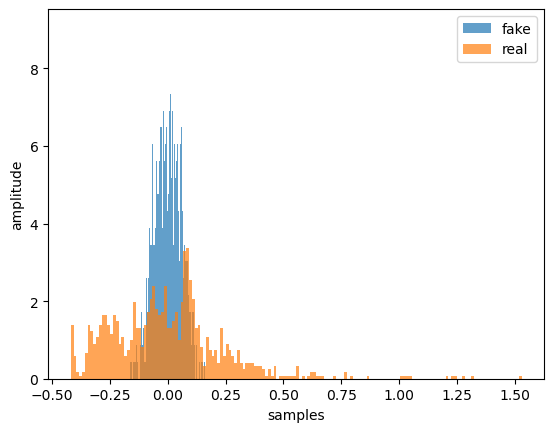

Epoch: 115 Loss D.: -0.031016509979963303 Loss G.: -0.0026550516486167908 KL Divergence RG: 2.7945894892875742 KL Divergence GR: 0.6432008110006899
Epoch 115


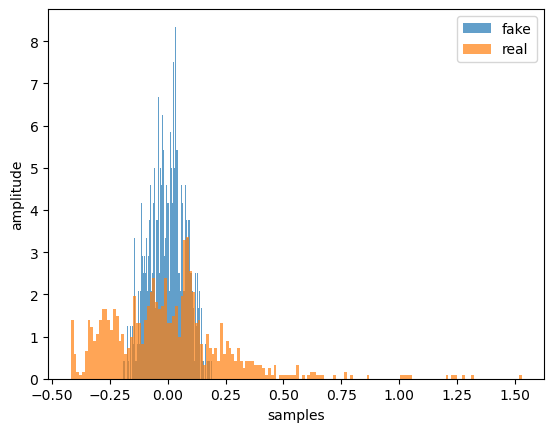

Epoch: 116 Loss D.: -0.025427479296922684 Loss G.: 0.004652006551623344 KL Divergence RG: 3.710355961422884 KL Divergence GR: 1.0042040562853443
Epoch 116


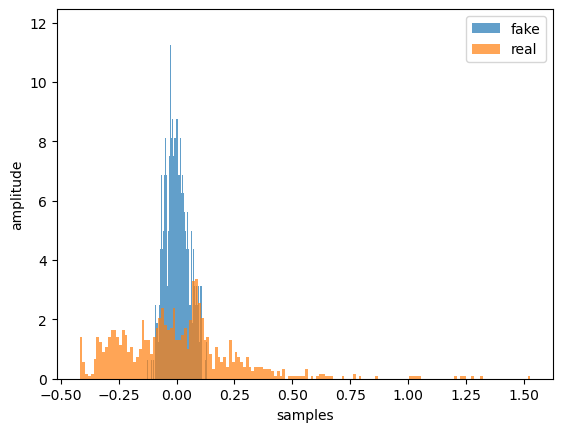

Epoch: 117 Loss D.: -0.03615982085466385 Loss G.: -0.0020006666891276836 KL Divergence RG: 3.0187915712733906 KL Divergence GR: 0.7538998671606026
Epoch 117


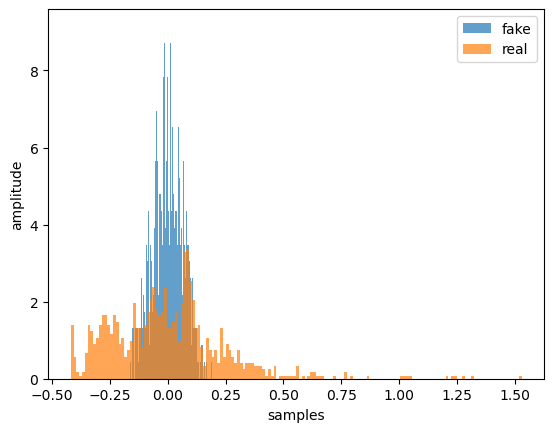

Epoch: 118 Loss D.: -0.036074575036764145 Loss G.: -0.0041432976722717285 KL Divergence RG: 3.509056092237146 KL Divergence GR: 1.0774917124746581
Epoch 118


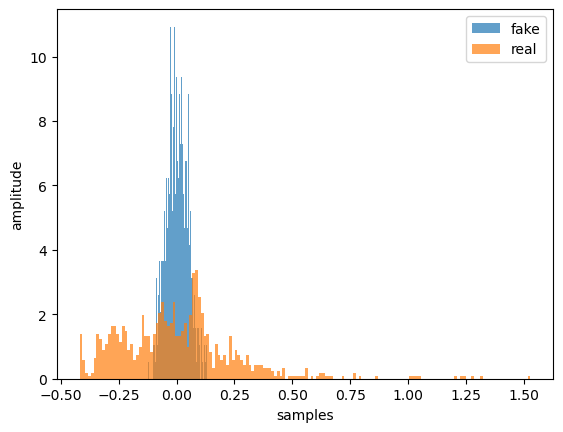

Epoch: 119 Loss D.: -0.0333627313375473 Loss G.: -0.001869977917522192 KL Divergence RG: 3.516525831709402 KL Divergence GR: 0.9383139712262547
Epoch 119


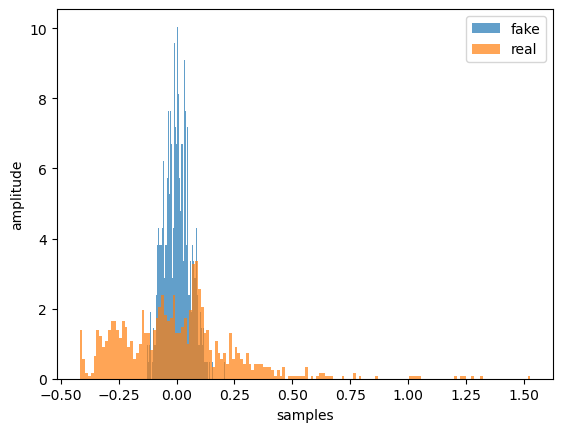

Epoch: 120 Loss D.: -0.03041701763868332 Loss G.: 0.009053567424416542 KL Divergence RG: 3.6726866121936417 KL Divergence GR: 1.1538913678036475
Epoch 120


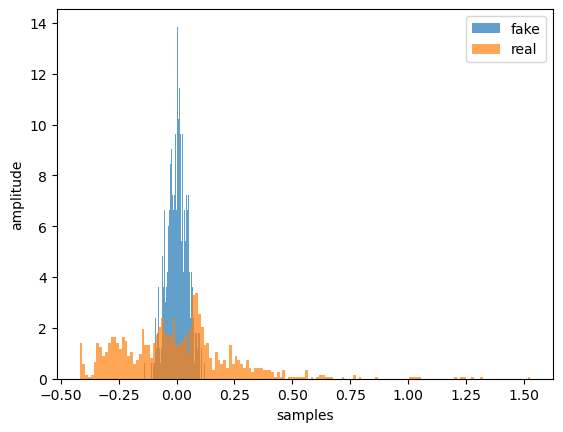

Epoch: 121 Loss D.: -0.04289298132061958 Loss G.: -0.0038287914358079433 KL Divergence RG: 5.3315218221821965 KL Divergence GR: 1.7636091346482563
Epoch 121


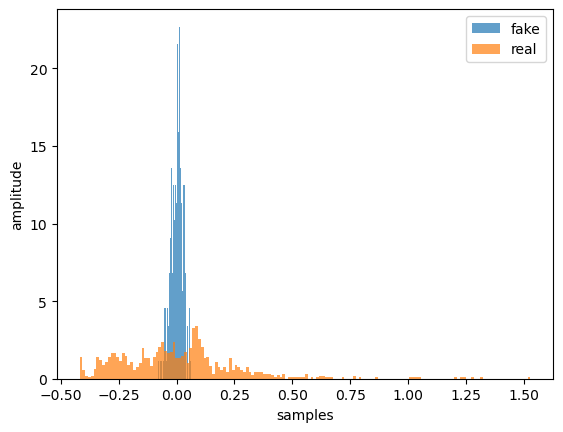

Epoch: 122 Loss D.: -0.04430895298719406 Loss G.: 0.0023996750824153423 KL Divergence RG: 5.078063244249212 KL Divergence GR: 1.8991103702317038
Epoch 122


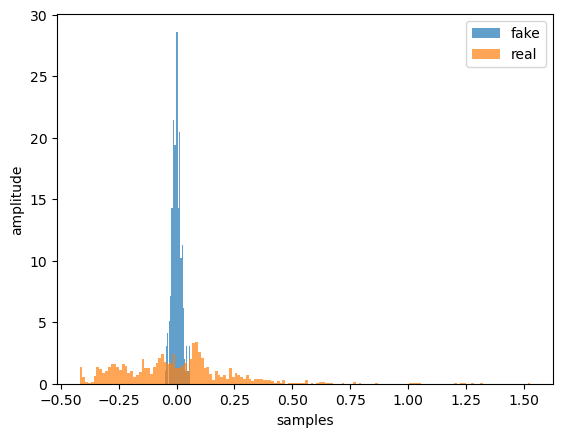

Epoch: 123 Loss D.: -0.040795378386974335 Loss G.: -0.005768525879830122 KL Divergence RG: 4.421759182884529 KL Divergence GR: 1.4841020846298107
Epoch 123


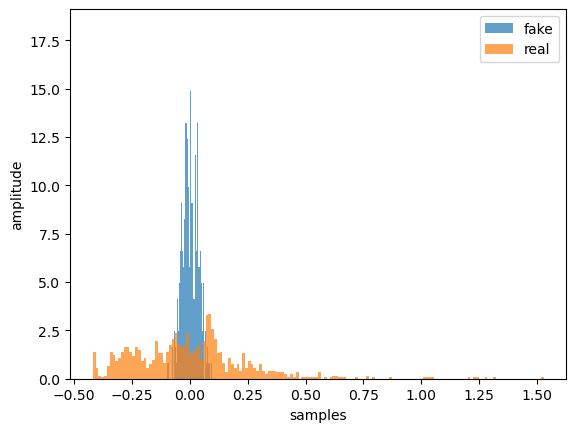

Epoch: 124 Loss D.: -0.039443135261535645 Loss G.: -0.018853098154067993 KL Divergence RG: 3.0857956381295857 KL Divergence GR: 0.7810717383093355
Epoch 124


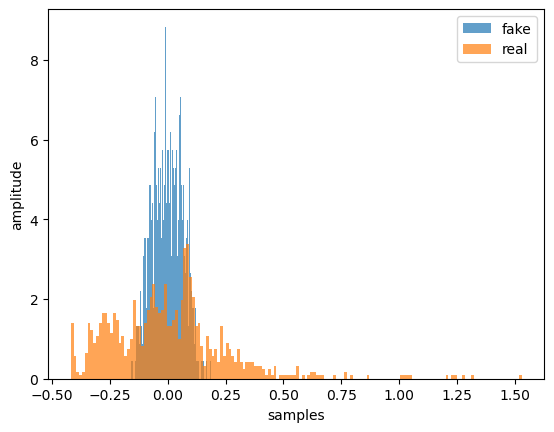

Epoch: 125 Loss D.: -0.03701407089829445 Loss G.: 0.002541639842092991 KL Divergence RG: 5.581285314483459 KL Divergence GR: 2.0858424914995637
Epoch 125


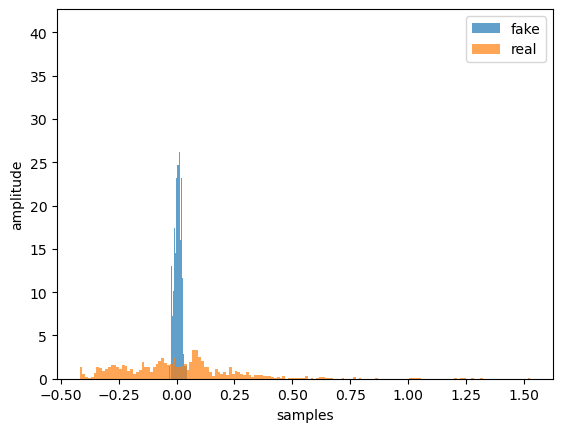

Epoch: 126 Loss D.: -0.030533604323863983 Loss G.: -0.0035091082099825144 KL Divergence RG: 2.8486604469398955 KL Divergence GR: 0.6850579079604058
Epoch 126


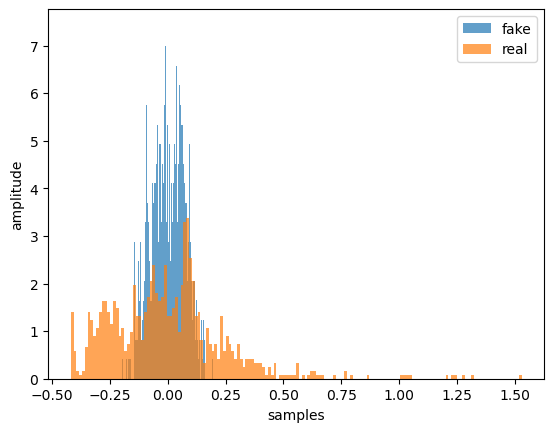

Epoch: 127 Loss D.: -0.04077300429344177 Loss G.: 0.0001755087578203529 KL Divergence RG: 2.665884052721269 KL Divergence GR: 0.630133028854127
Epoch 127


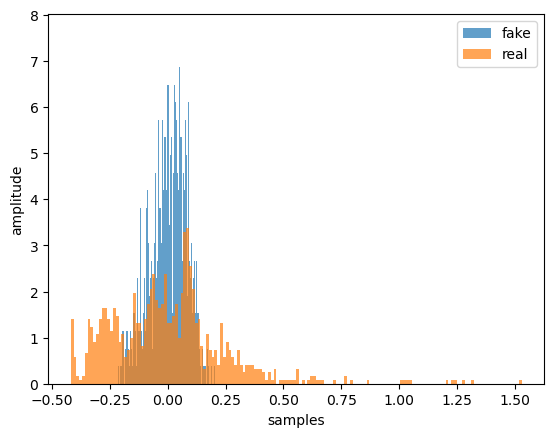

Epoch: 128 Loss D.: -0.03318190202116966 Loss G.: -0.004982219077646732 KL Divergence RG: 5.302360580049086 KL Divergence GR: 1.9662172560735298
Epoch 128


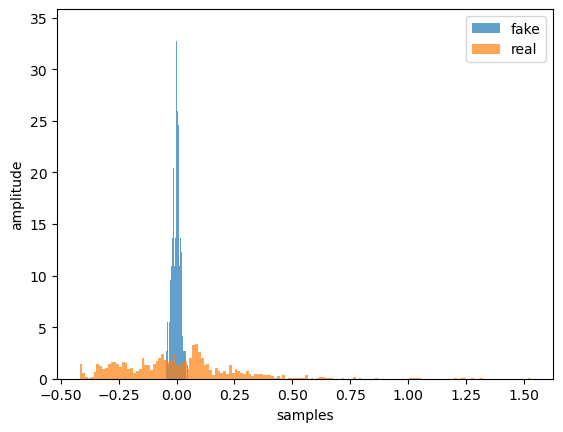

Epoch: 129 Loss D.: -0.03500647842884064 Loss G.: 0.0030947313643991947 KL Divergence RG: 5.095105791872892 KL Divergence GR: 1.8097892270344607
Epoch 129


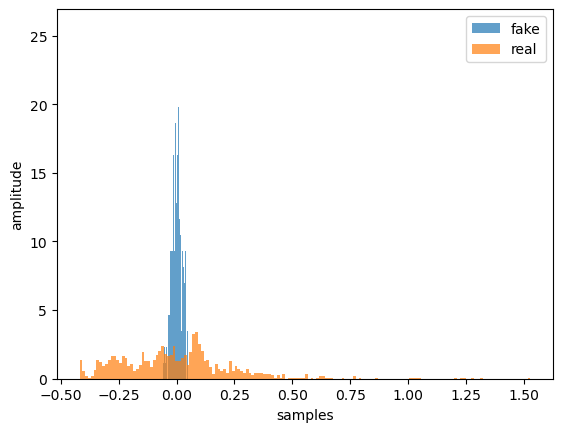

Epoch: 130 Loss D.: -0.03730148822069168 Loss G.: -0.0016113548772409558 KL Divergence RG: 5.548816962308665 KL Divergence GR: 1.9904144567772362
Epoch 130


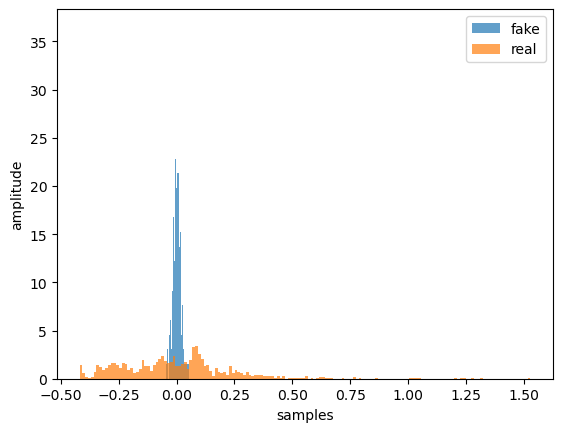

Epoch: 131 Loss D.: -0.03701912611722946 Loss G.: 0.0021153807174414396 KL Divergence RG: 4.866661823061433 KL Divergence GR: 1.6830399267726628
Epoch 131


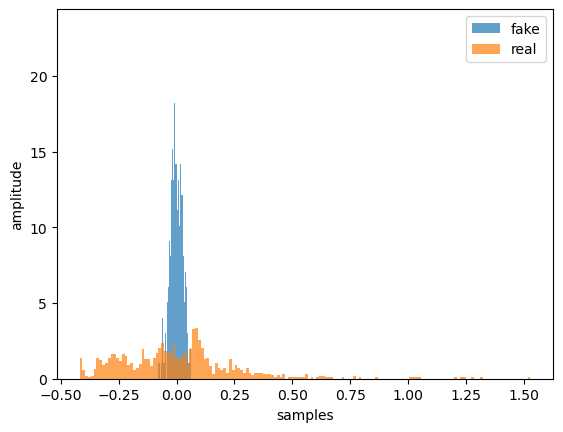

Epoch: 132 Loss D.: -0.03312886878848076 Loss G.: 0.003040627110749483 KL Divergence RG: 3.4777546021746795 KL Divergence GR: 1.042221907732183
Epoch 132


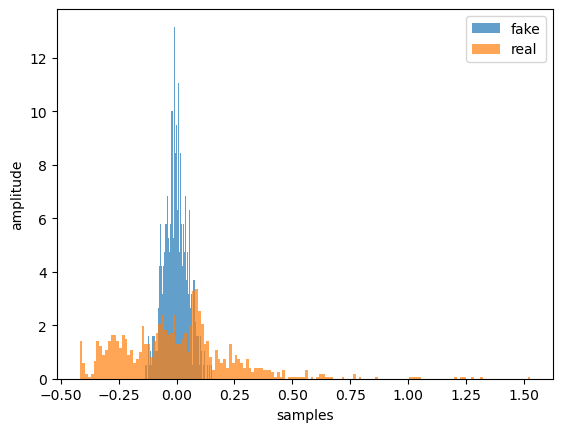

Epoch: 133 Loss D.: -0.05041847378015518 Loss G.: -0.013481084257364273 KL Divergence RG: 4.916382777939969 KL Divergence GR: 1.7192771615979774
Epoch 133


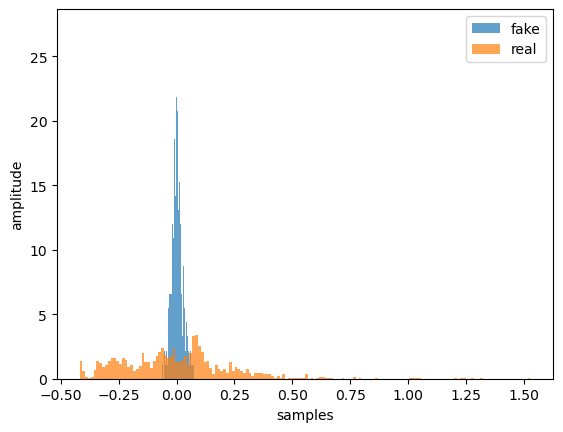

Epoch: 134 Loss D.: -0.03227188065648079 Loss G.: -0.0007722190930508077 KL Divergence RG: 5.463500425749345 KL Divergence GR: 1.9256402407401647
Epoch 134


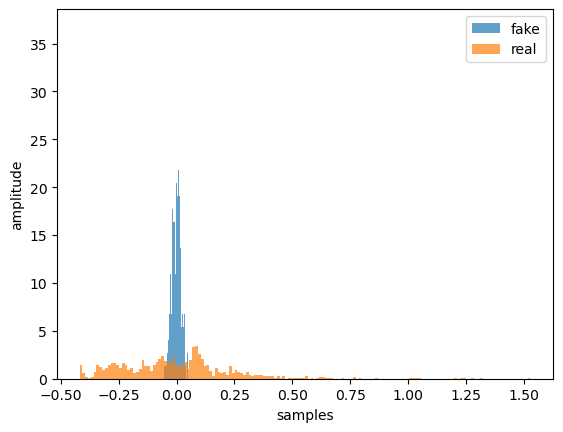

Epoch: 135 Loss D.: -0.0320335291326046 Loss G.: 0.0030022384598851204 KL Divergence RG: 2.311207634724993 KL Divergence GR: 0.6450867500614803
Epoch 135


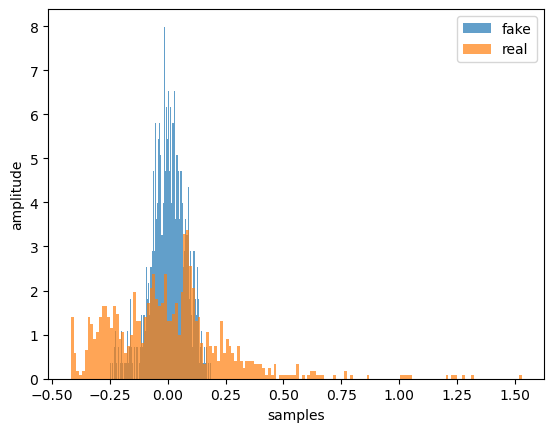

Epoch: 136 Loss D.: -0.0361383892595768 Loss G.: 0.0001297584385611117 KL Divergence RG: 2.9610396640740047 KL Divergence GR: 0.7853649402473037
Epoch 136


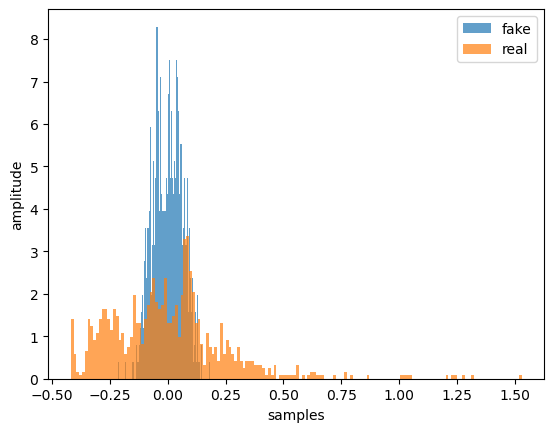

Epoch: 137 Loss D.: -0.03362858667969704 Loss G.: -0.0034002556931227446 KL Divergence RG: 2.800472173167731 KL Divergence GR: 0.7011303713126286
Epoch 137


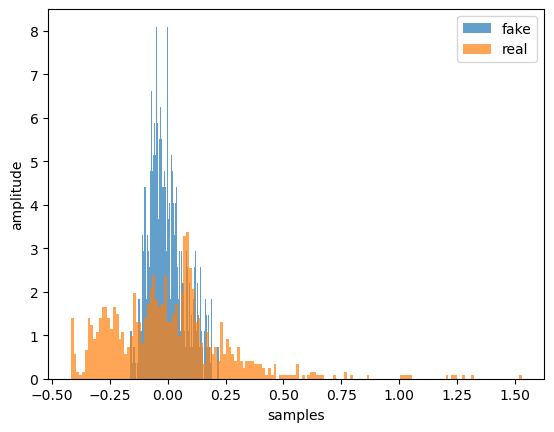

Epoch: 138 Loss D.: -0.022732652723789215 Loss G.: -0.0027287262491881847 KL Divergence RG: 3.4978132651386633 KL Divergence GR: 1.0590337224909592
Epoch 138


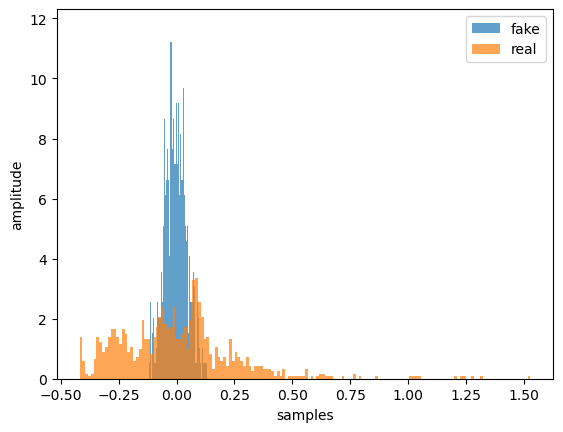

Epoch: 139 Loss D.: -0.0455578938126564 Loss G.: -0.01294613815844059 KL Divergence RG: 4.6041124953831485 KL Divergence GR: 1.5287597308548575
Epoch 139


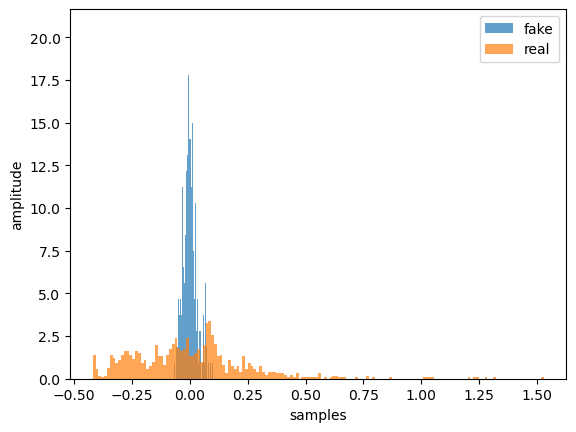

Epoch: 140 Loss D.: -0.04062874987721443 Loss G.: 0.0020279083400964737 KL Divergence RG: 0.8725086585374842 KL Divergence GR: 0.2503867051642289
Epoch 140


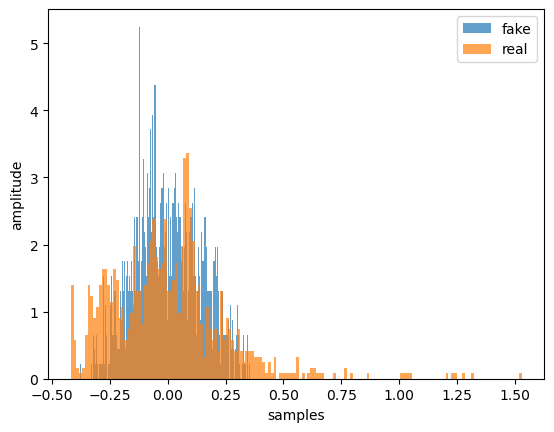

Epoch: 141 Loss D.: -0.038001708686351776 Loss G.: -0.004127156920731068 KL Divergence RG: 5.010440541988544 KL Divergence GR: 1.7516314042873193
Epoch 141


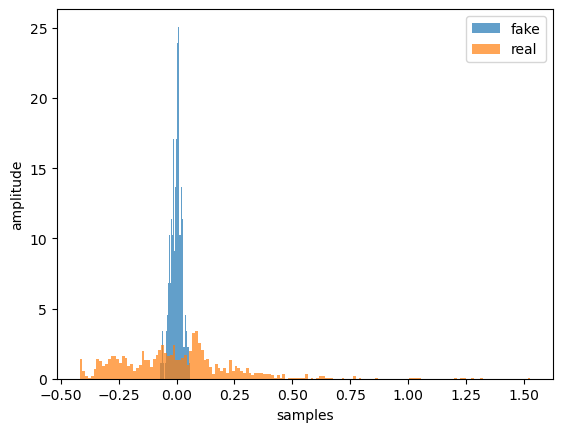

Epoch: 142 Loss D.: -0.025876199826598167 Loss G.: 0.003246456617489457 KL Divergence RG: 4.073169654462677 KL Divergence GR: 1.3175107278084974
Epoch 142


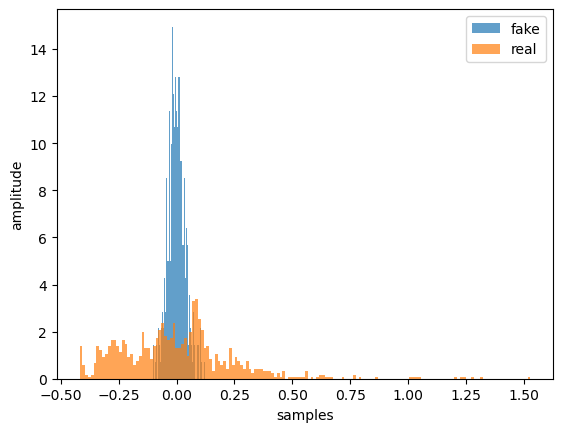

Epoch: 143 Loss D.: -0.02986149862408638 Loss G.: 0.0024165045469999313 KL Divergence RG: 2.4717841127192015 KL Divergence GR: 0.6095515163781886
Epoch 143


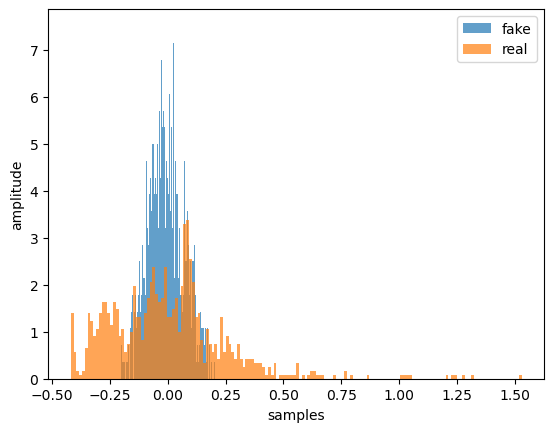

Epoch: 144 Loss D.: -0.04393433779478073 Loss G.: 0.006148345768451691 KL Divergence RG: 0.9382964727872171 KL Divergence GR: 0.3144622956420351
Epoch 144


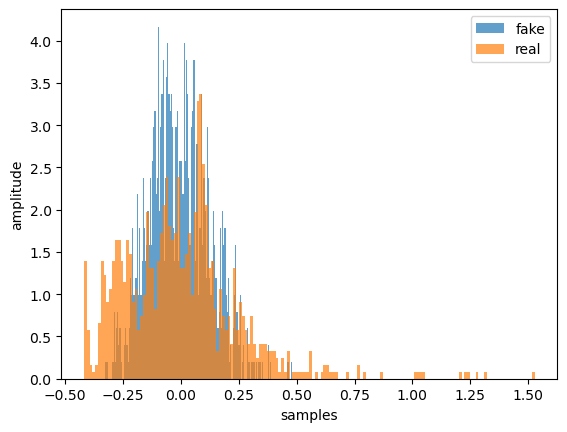

Epoch: 145 Loss D.: -0.033257052302360535 Loss G.: -0.004415472038090229 KL Divergence RG: 0.9975717248005277 KL Divergence GR: 0.36684117489282025
Epoch 145


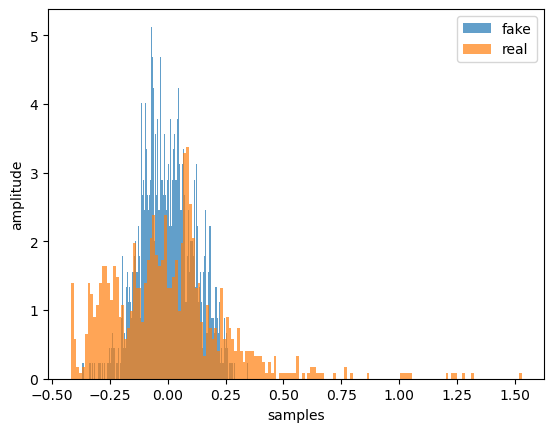

Epoch: 146 Loss D.: -0.026913229376077652 Loss G.: 3.636768087744713e-05 KL Divergence RG: 1.5922379392280244 KL Divergence GR: 0.44412382093642255
Epoch 146


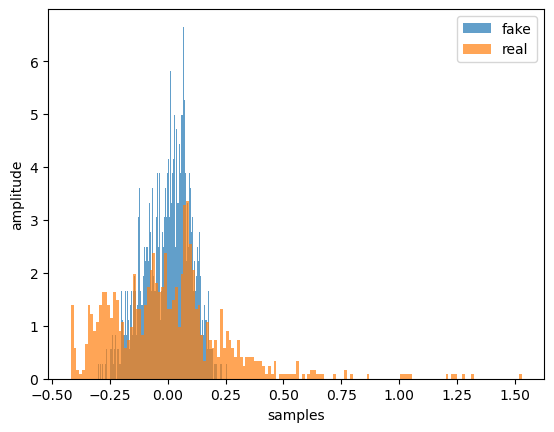

Epoch: 147 Loss D.: -0.03917641565203667 Loss G.: -0.006580592133104801 KL Divergence RG: 3.188152075172084 KL Divergence GR: 0.8408552390598596
Epoch 147


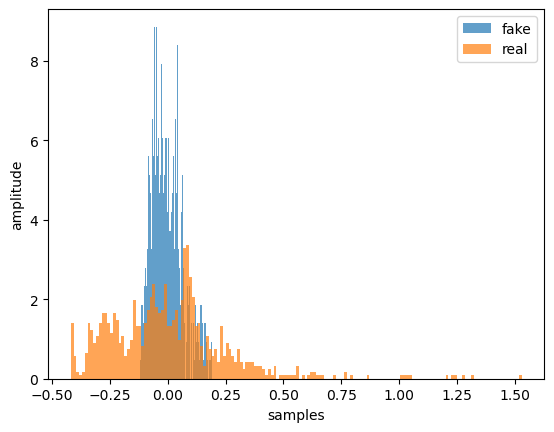

Epoch: 148 Loss D.: -0.03267857804894447 Loss G.: -0.001708344672806561 KL Divergence RG: 4.623301829172024 KL Divergence GR: 1.644843270843671
Epoch 148


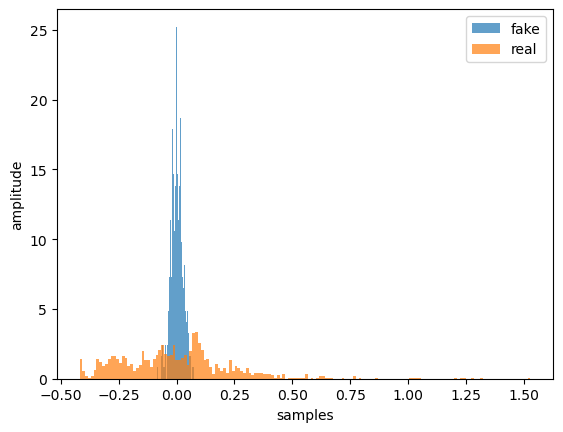

Epoch: 149 Loss D.: -0.03634430095553398 Loss G.: -0.007742112502455711 KL Divergence RG: 5.443951516986715 KL Divergence GR: 1.8855770097102753
Epoch 149


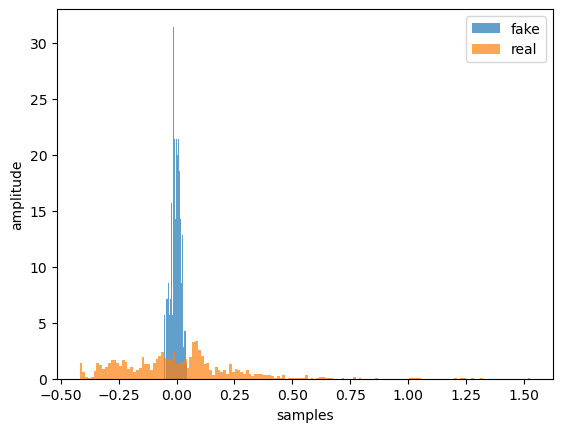

Epoch: 150 Loss D.: -0.03220153972506523 Loss G.: 0.005609144456684589 KL Divergence RG: 2.6619405651176704 KL Divergence GR: 0.9064196651826077
Epoch 150


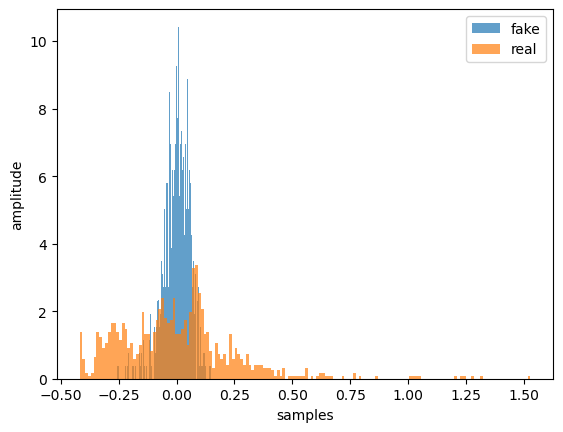

Epoch: 151 Loss D.: -0.03272164613008499 Loss G.: -0.006841960363090038 KL Divergence RG: 3.7324245974177637 KL Divergence GR: 1.1310349997293867
Epoch 151


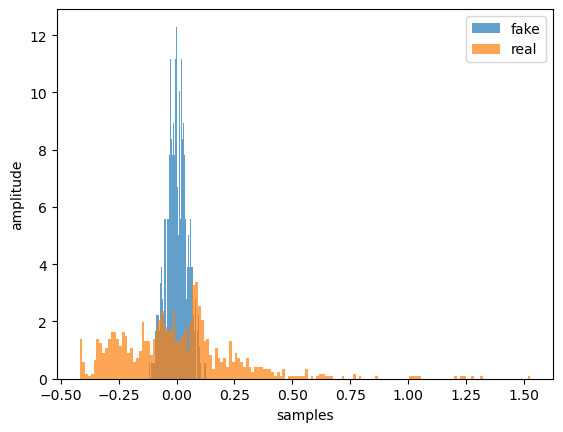

Epoch: 152 Loss D.: -0.033991120755672455 Loss G.: 0.0013602841645479202 KL Divergence RG: 4.66760621577609 KL Divergence GR: 1.582347951075588
Epoch 152


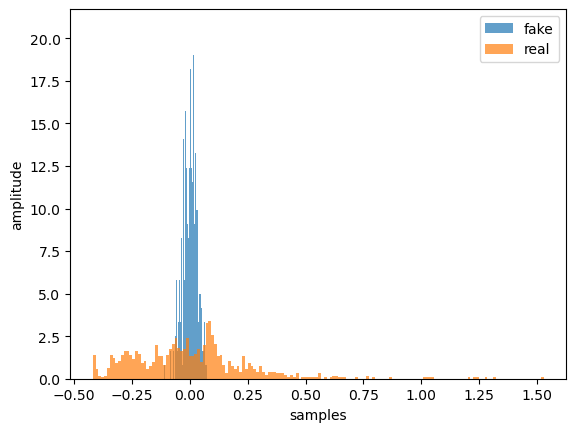

Epoch: 153 Loss D.: -0.03268738090991974 Loss G.: -0.002752406056970358 KL Divergence RG: 1.2135213293686073 KL Divergence GR: 0.34882916459865954
Epoch 153


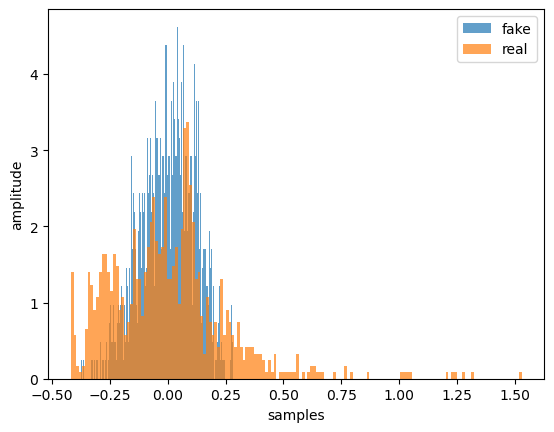

Epoch: 154 Loss D.: -0.03944731876254082 Loss G.: 0.006767259445041418 KL Divergence RG: 5.291739157185988 KL Divergence GR: 1.9271983559888626
Epoch 154


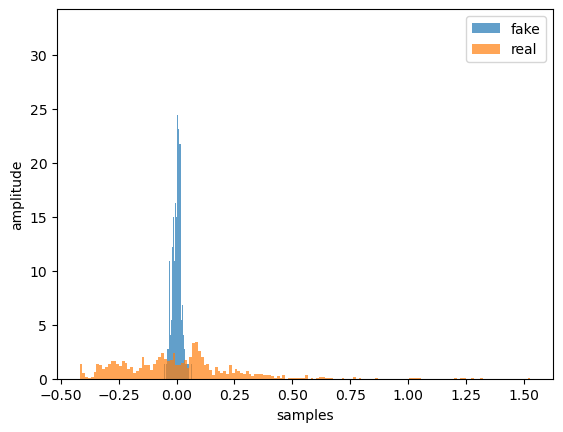

Epoch: 155 Loss D.: -0.04308338835835457 Loss G.: 0.0019169517327100039 KL Divergence RG: 2.6195953633284494 KL Divergence GR: 0.6925646629426784
Epoch 155


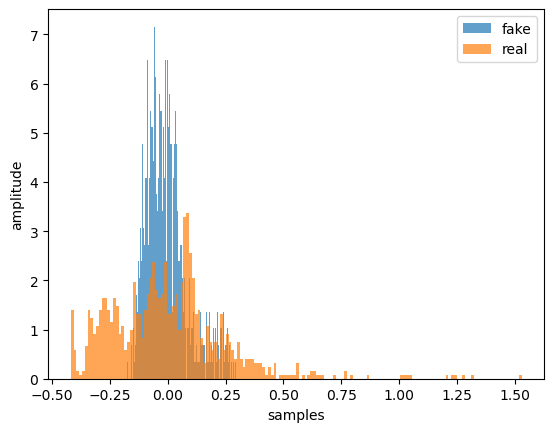

Epoch: 156 Loss D.: -0.026515504345297813 Loss G.: 0.0022784757893532515 KL Divergence RG: 1.1195073107140356 KL Divergence GR: 0.338543439045915
Epoch 156


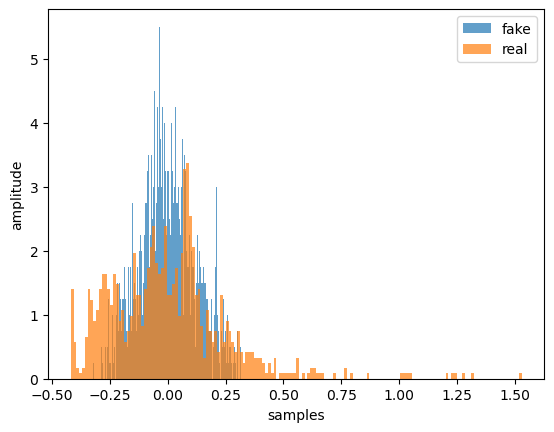

Epoch: 157 Loss D.: -0.03516598418354988 Loss G.: 0.003473112126812339 KL Divergence RG: 5.645189783101807 KL Divergence GR: 2.040744818947821
Epoch 157


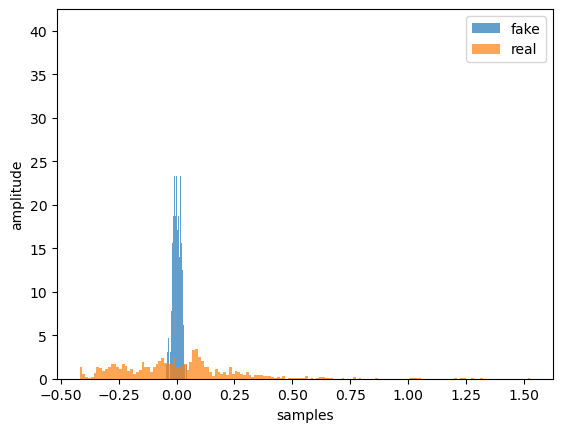

Epoch: 158 Loss D.: -0.034676484763622284 Loss G.: -0.0009626508690416813 KL Divergence RG: 2.0049159037063005 KL Divergence GR: 0.4377096810447017
Epoch 158


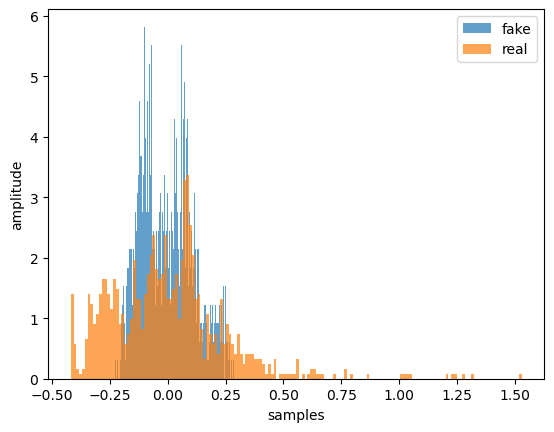

Epoch: 159 Loss D.: -0.03155222162604332 Loss G.: 0.0003286595456302166 KL Divergence RG: 2.3820055543881224 KL Divergence GR: 0.5980228090350901
Epoch 159


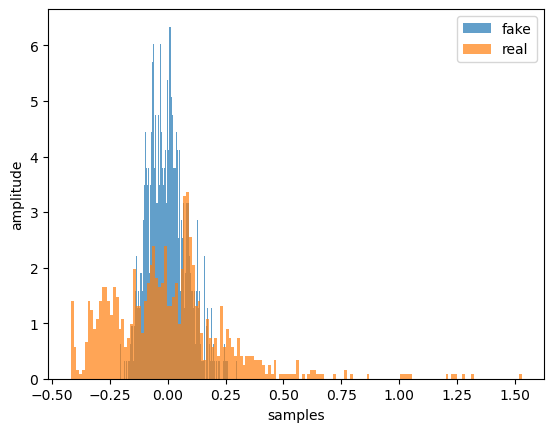

Epoch: 160 Loss D.: -0.03992357850074768 Loss G.: 0.009824944660067558 KL Divergence RG: 3.8143896115343057 KL Divergence GR: 1.0879776851759089
Epoch 160


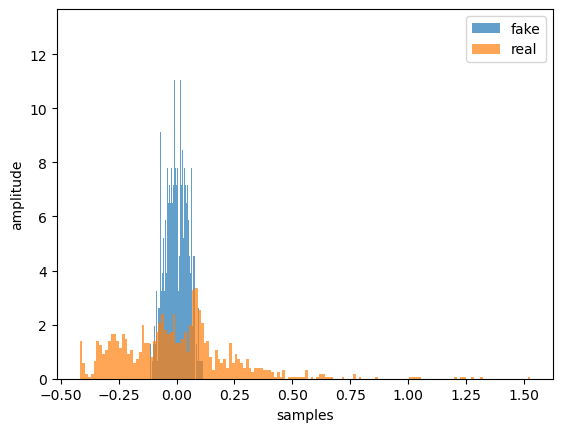

Epoch: 161 Loss D.: -0.032167769968509674 Loss G.: -0.002541291993111372 KL Divergence RG: 3.2088148945779733 KL Divergence GR: 0.8980932852236463
Epoch 161


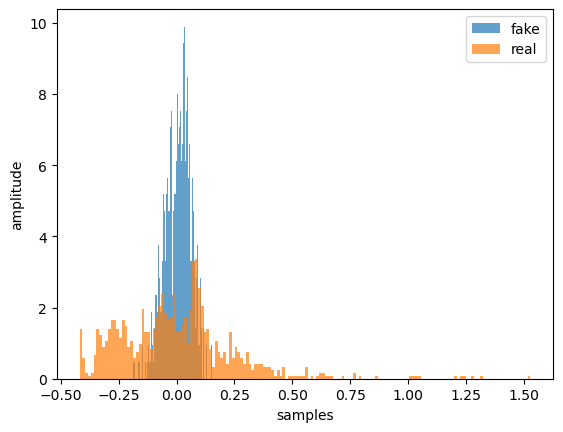

Epoch: 162 Loss D.: -0.032504867762327194 Loss G.: 0.0035699368454515934 KL Divergence RG: 3.859643440904791 KL Divergence GR: 1.1641713641711442
Epoch 162


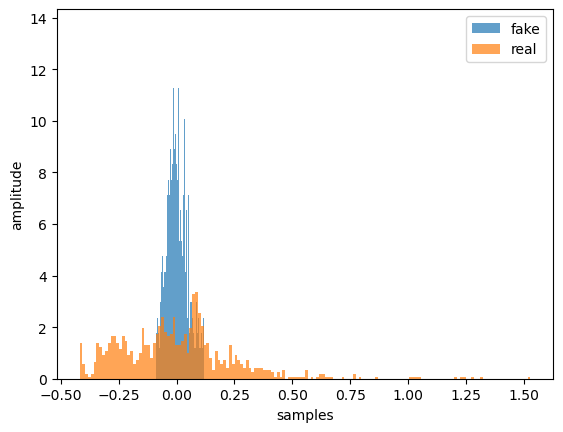

Epoch: 163 Loss D.: -0.0386512465775013 Loss G.: -0.0018204990774393082 KL Divergence RG: 2.3244904308143752 KL Divergence GR: 0.6579409964506425
Epoch 163


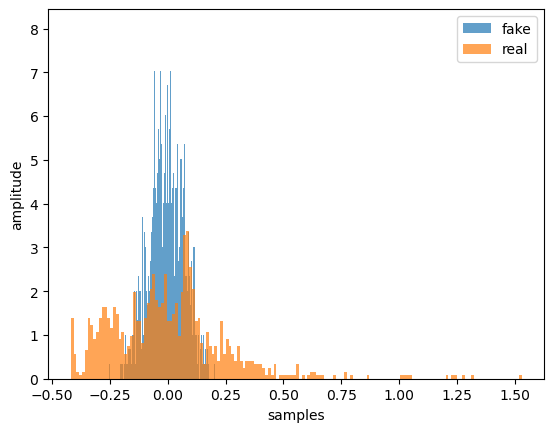

Epoch: 164 Loss D.: -0.029416218400001526 Loss G.: 0.001685073133558035 KL Divergence RG: 2.7795167751135224 KL Divergence GR: 0.7214770052382248
Epoch 164


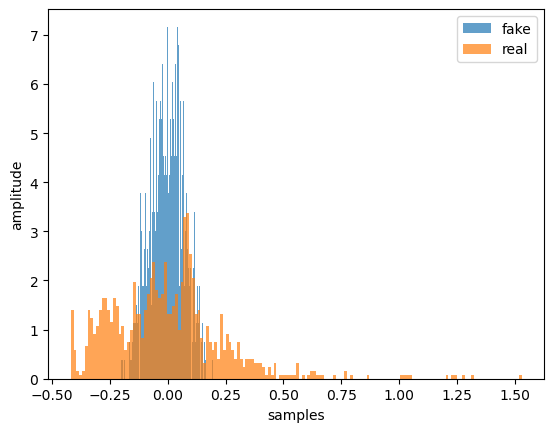

Epoch: 165 Loss D.: -0.03130463510751724 Loss G.: -0.0035937565844506025 KL Divergence RG: 3.495545801344135 KL Divergence GR: 1.0111278369520926
Epoch 165


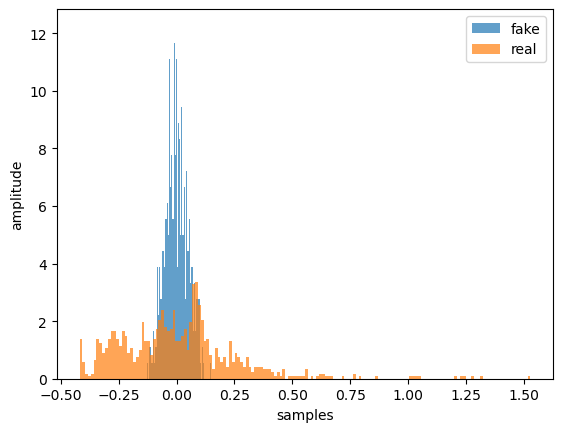

Epoch: 166 Loss D.: -0.03708803281188011 Loss G.: -0.0011524445144459605 KL Divergence RG: 5.620634998460852 KL Divergence GR: 2.0904557486848283
Epoch 166


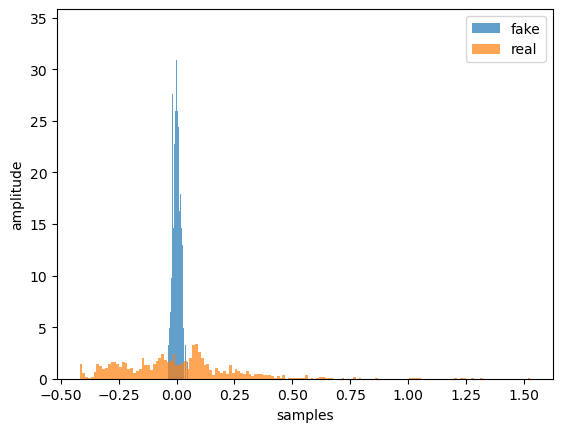

Epoch: 167 Loss D.: -0.034447990357875824 Loss G.: -0.004092509858310223 KL Divergence RG: 3.4584163143449222 KL Divergence GR: 1.035136867492189
Epoch 167


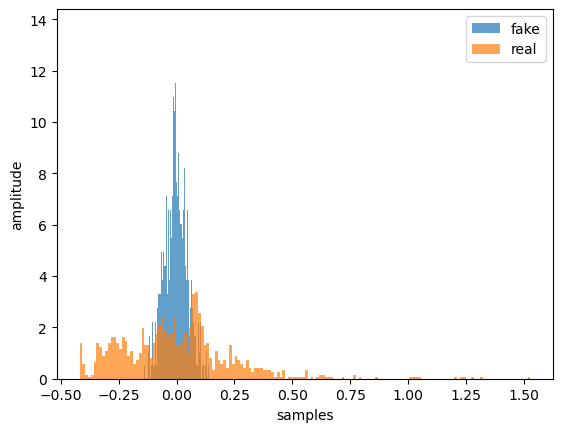

Epoch: 168 Loss D.: -0.031787727028131485 Loss G.: 0.0013496711617335677 KL Divergence RG: 4.751463903365543 KL Divergence GR: 1.6341409300639742
Epoch 168


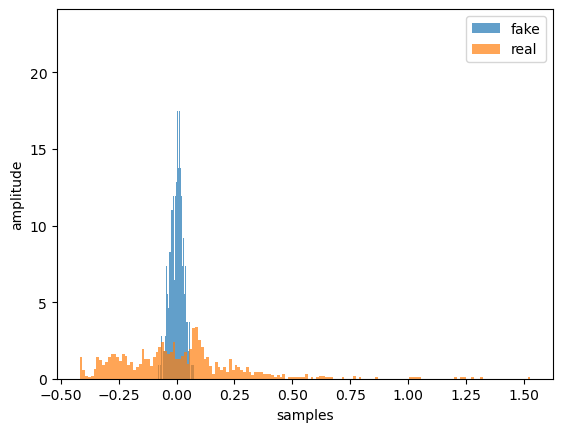

Epoch: 169 Loss D.: -0.03141322359442711 Loss G.: -0.00022578836069442332 KL Divergence RG: 4.126006630882998 KL Divergence GR: 1.3408626432389574
Epoch 169


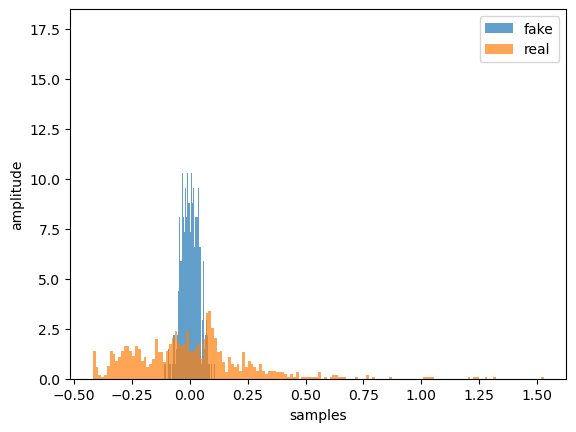

Epoch: 170 Loss D.: -0.040086887776851654 Loss G.: 0.002573695732280612 KL Divergence RG: 5.607043426002686 KL Divergence GR: 2.0568947152812163
Epoch 170


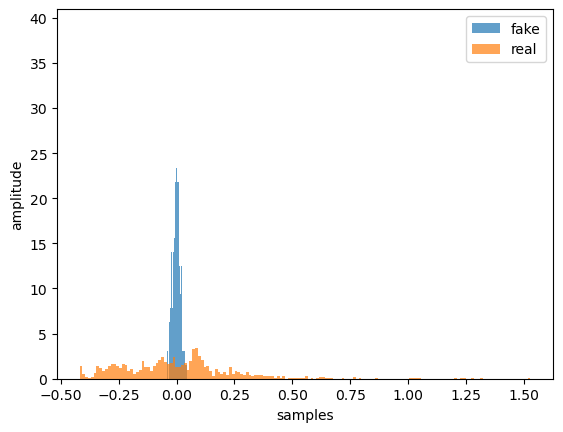

Epoch: 171 Loss D.: -0.029495088383555412 Loss G.: 0.0034553746227174997 KL Divergence RG: 4.9309461250394495 KL Divergence GR: 1.674399601096634
Epoch 171


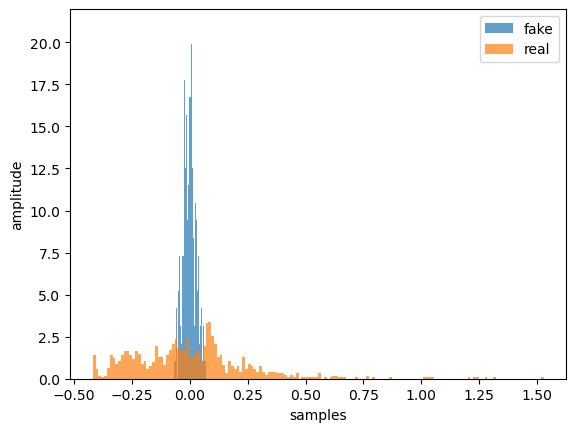

Epoch: 172 Loss D.: -0.03555639460682869 Loss G.: 0.005772368982434273 KL Divergence RG: 3.1674503074192115 KL Divergence GR: 0.9110531532725195
Epoch 172


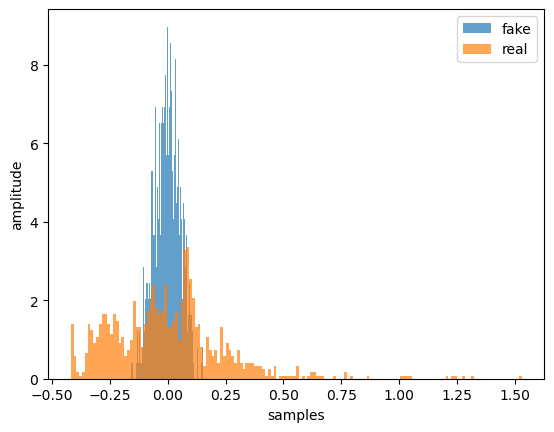

Epoch: 173 Loss D.: -0.036930885165929794 Loss G.: -0.00815229769796133 KL Divergence RG: 3.3546077544834407 KL Divergence GR: 0.9474309418552249
Epoch 173


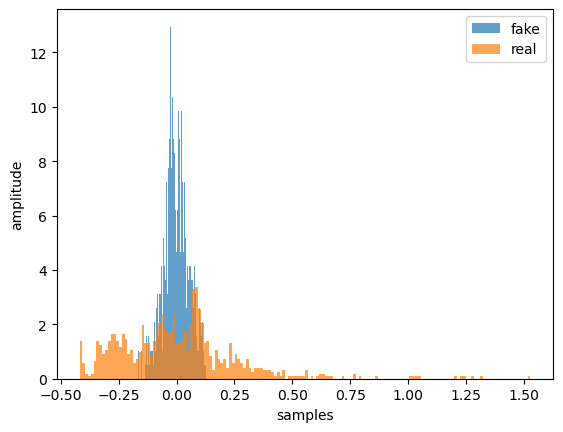

Epoch: 174 Loss D.: -0.03226432204246521 Loss G.: -0.015187610872089863 KL Divergence RG: 4.452083135775697 KL Divergence GR: 1.5208579266666937
Epoch 174


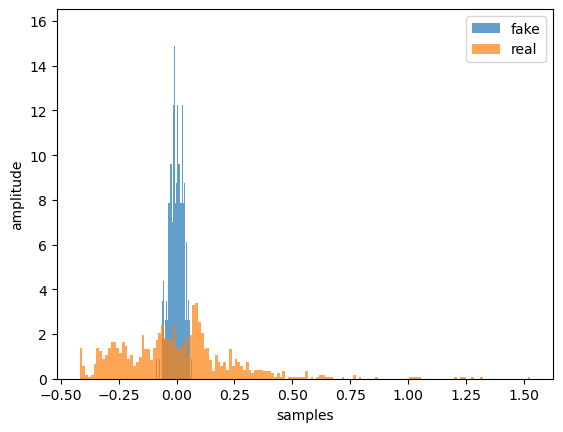

Epoch: 175 Loss D.: -0.03364676237106323 Loss G.: -0.017725959420204163 KL Divergence RG: 3.746098173617528 KL Divergence GR: 1.036153347701713
Epoch 175


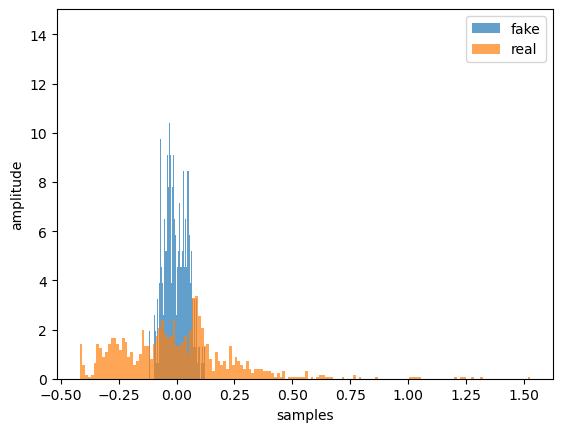

Epoch: 176 Loss D.: -0.036188241094350815 Loss G.: -0.0039556315168738365 KL Divergence RG: 4.822549382987164 KL Divergence GR: 1.6563491449959569
Epoch 176


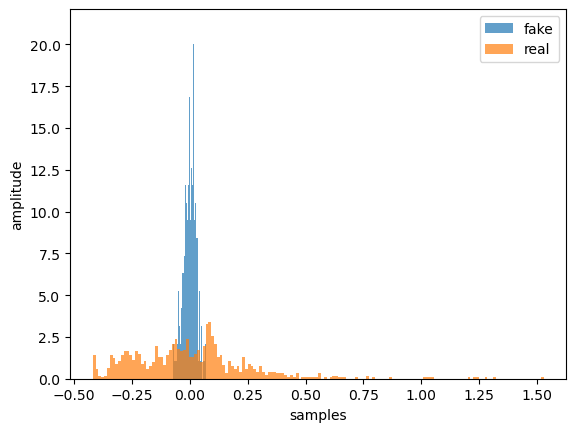

Epoch: 177 Loss D.: -0.036009032279253006 Loss G.: 0.0033619508612900972 KL Divergence RG: 1.4558269916696764 KL Divergence GR: 0.5210774762848457
Epoch 177


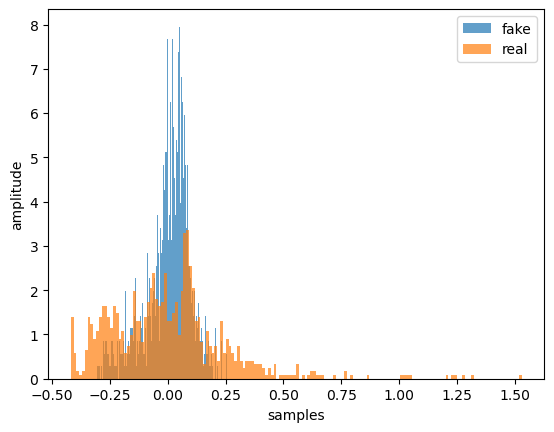

Epoch: 178 Loss D.: -0.02857315167784691 Loss G.: 0.001567690633237362 KL Divergence RG: 4.387331415070277 KL Divergence GR: 1.447340132644329
Epoch 178


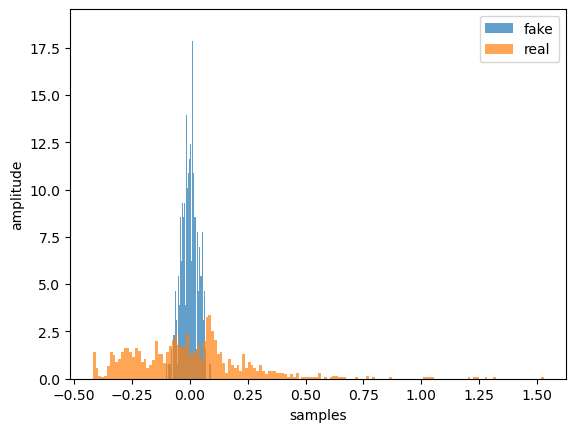

Epoch: 179 Loss D.: -0.030156796798110008 Loss G.: -0.0012698451755568385 KL Divergence RG: 3.0264180711269164 KL Divergence GR: 0.731216558744286
Epoch 179


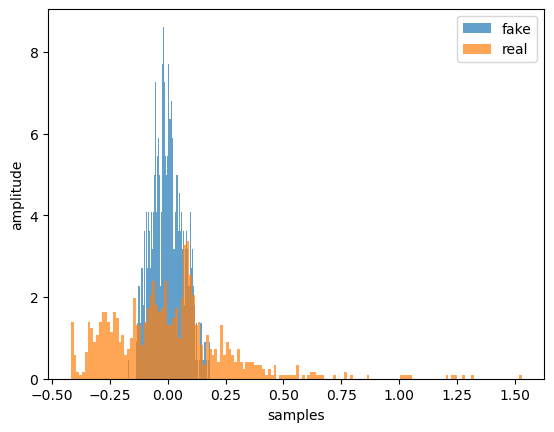

Epoch: 180 Loss D.: -0.03015649877488613 Loss G.: 0.0004006055823992938 KL Divergence RG: 4.088783961980294 KL Divergence GR: 1.2873406290288552
Epoch 180


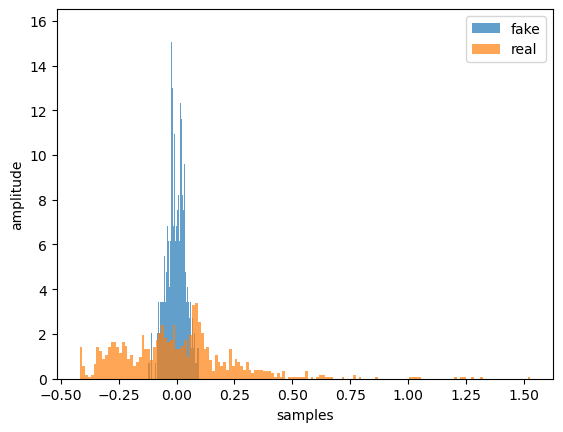

Epoch: 181 Loss D.: -0.0376400426030159 Loss G.: 0.0048006558790802956 KL Divergence RG: 1.9848833926533787 KL Divergence GR: 0.4832218007246093
Epoch 181


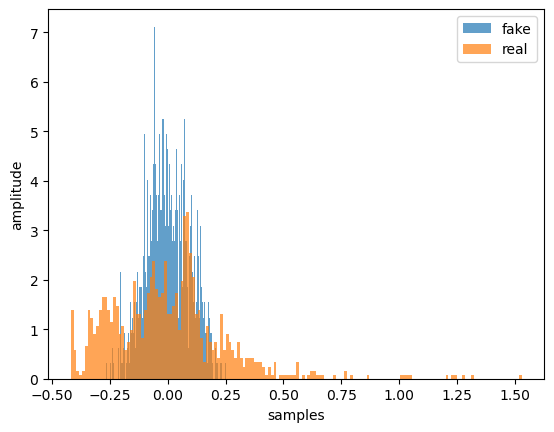

Epoch: 182 Loss D.: -0.029007645323872566 Loss G.: -0.01086517609655857 KL Divergence RG: 5.6354899899979545 KL Divergence GR: 2.0295736392611885
Epoch 182


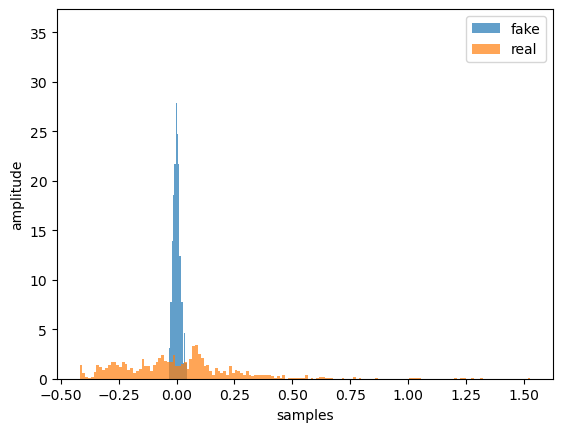

Epoch: 183 Loss D.: -0.03474606201052666 Loss G.: -0.0009743132977746427 KL Divergence RG: 5.502400252668771 KL Divergence GR: 1.9411715276718318
Epoch 183


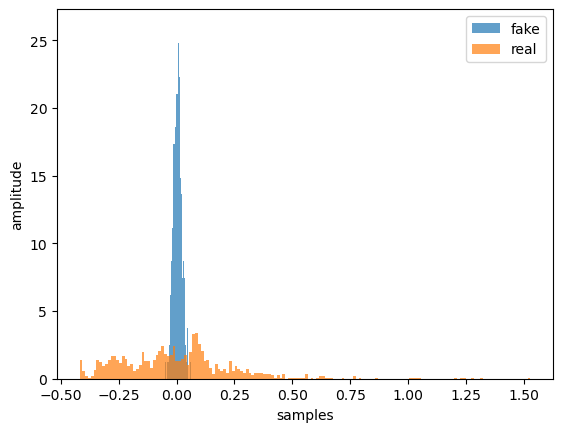

Epoch: 184 Loss D.: -0.031225919723510742 Loss G.: -0.00873952079564333 KL Divergence RG: 4.895488154359064 KL Divergence GR: 1.6466086871915235
Epoch 184


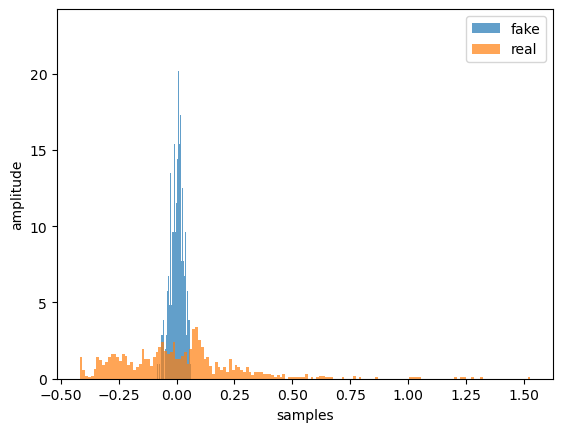

Epoch: 185 Loss D.: -0.03201153501868248 Loss G.: -0.003240017220377922 KL Divergence RG: 3.4058376795574956 KL Divergence GR: 0.965818555868509
Epoch 185


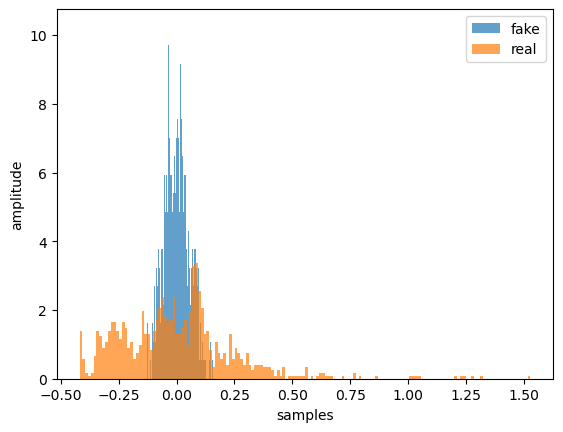

Epoch: 186 Loss D.: -0.03276517242193222 Loss G.: -0.009556573815643787 KL Divergence RG: 5.564824487490792 KL Divergence GR: 2.037705383326456
Epoch 186


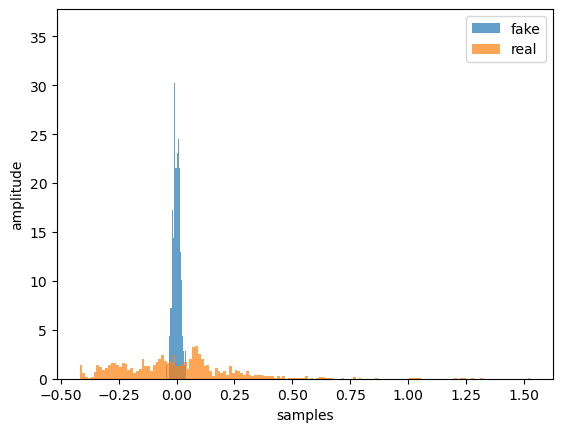

Epoch: 187 Loss D.: -0.03435829281806946 Loss G.: 0.005022002849727869 KL Divergence RG: 3.2876191637000893 KL Divergence GR: 0.8711245294973785
Epoch 187


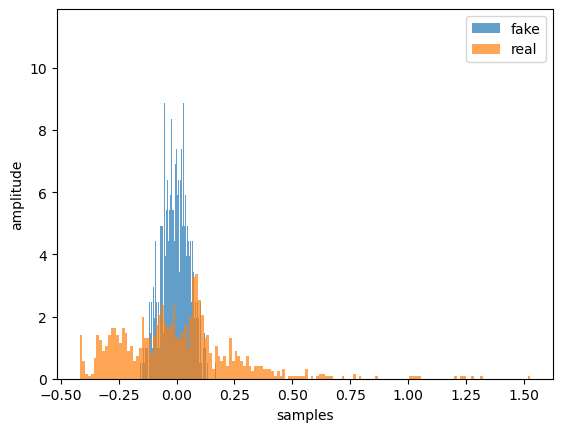

Epoch: 188 Loss D.: -0.04381280392408371 Loss G.: -0.0051927994936704636 KL Divergence RG: 2.3757231070653324 KL Divergence GR: 0.556907466116686
Epoch 188


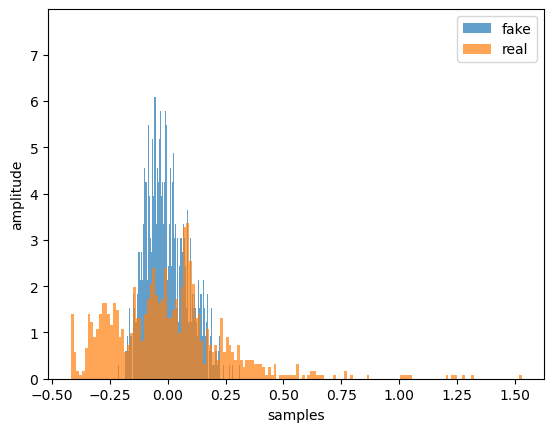

Epoch: 189 Loss D.: -0.03391424939036369 Loss G.: 0.004715449642390013 KL Divergence RG: 5.645603980081432 KL Divergence GR: 2.040610686166241
Epoch 189


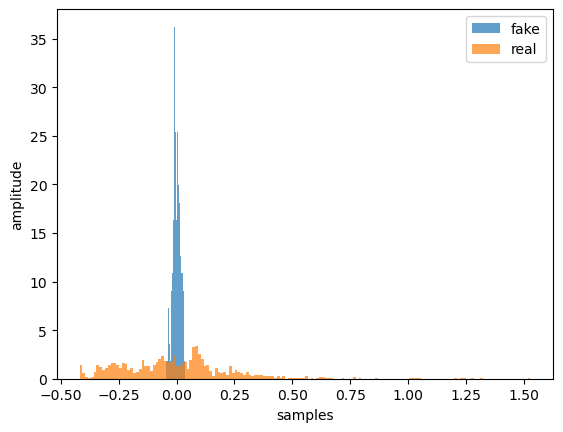

Epoch: 190 Loss D.: -0.034681230783462524 Loss G.: -0.010096815414726734 KL Divergence RG: 1.193118654594871 KL Divergence GR: 0.3798721066637041
Epoch 190


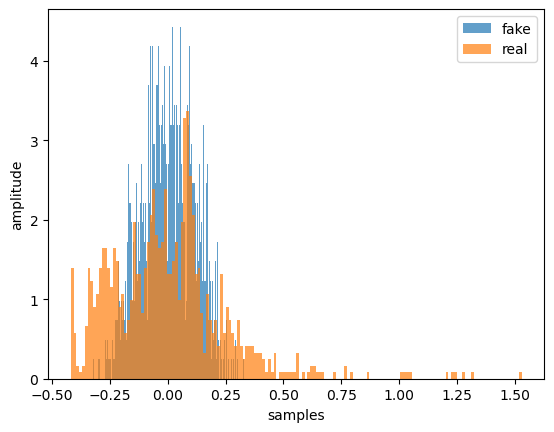

Epoch: 191 Loss D.: -0.03605099767446518 Loss G.: -0.004580010659992695 KL Divergence RG: 2.7780376116580987 KL Divergence GR: 0.6877114296804941
Epoch 191


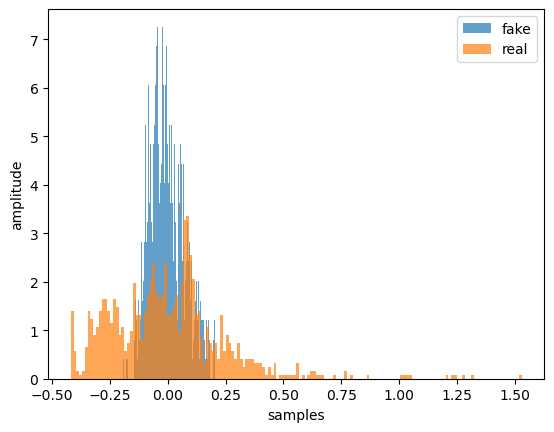

Epoch: 192 Loss D.: -0.032751500606536865 Loss G.: 0.002558354754000902 KL Divergence RG: 0.5025353603657652 KL Divergence GR: 0.21825770134280761
Epoch 192


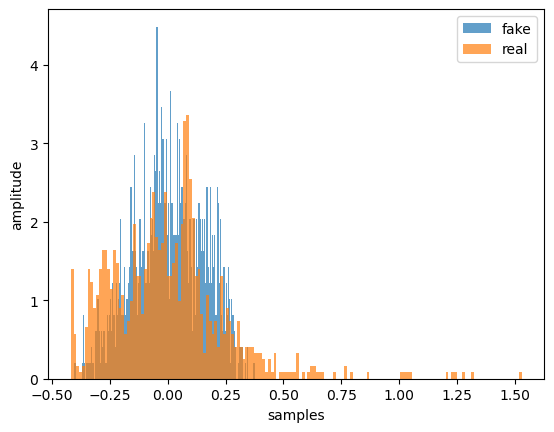

Epoch: 193 Loss D.: -0.03407309576869011 Loss G.: 0.0023970487527549267 KL Divergence RG: 2.855118346902488 KL Divergence GR: 0.7193000744361535
Epoch 193


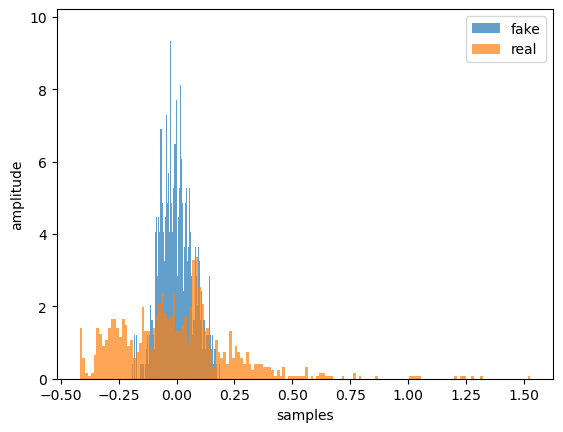

Epoch: 194 Loss D.: -0.033035557717084885 Loss G.: -0.004270682577043772 KL Divergence RG: 2.6964922431458147 KL Divergence GR: 0.8232169969720782
Epoch 194


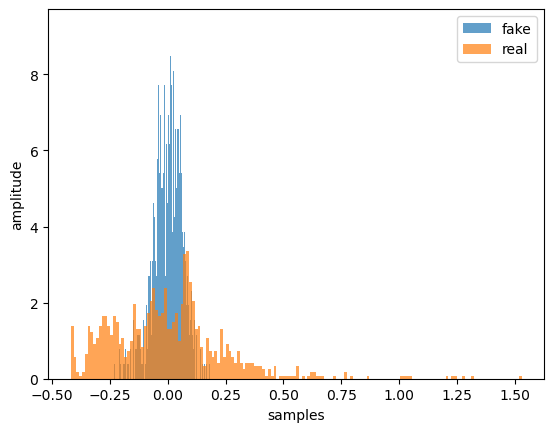

Epoch: 195 Loss D.: -0.035283807665109634 Loss G.: -0.002631743671372533 KL Divergence RG: 2.1653019695335156 KL Divergence GR: 0.509771635344362
Epoch 195


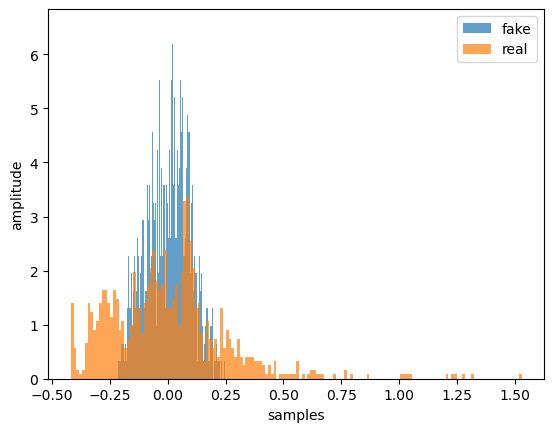

Epoch: 196 Loss D.: -0.0326114259660244 Loss G.: 0.002420115750283003 KL Divergence RG: 5.821451974636549 KL Divergence GR: 2.3166611909439423
Epoch 196


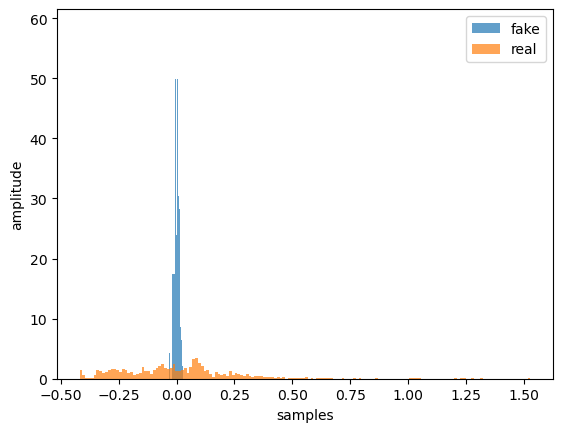

Epoch: 197 Loss D.: -0.03140982985496521 Loss G.: -0.0025592059828341007 KL Divergence RG: 3.180768546245004 KL Divergence GR: 0.8676770228638928
Epoch 197


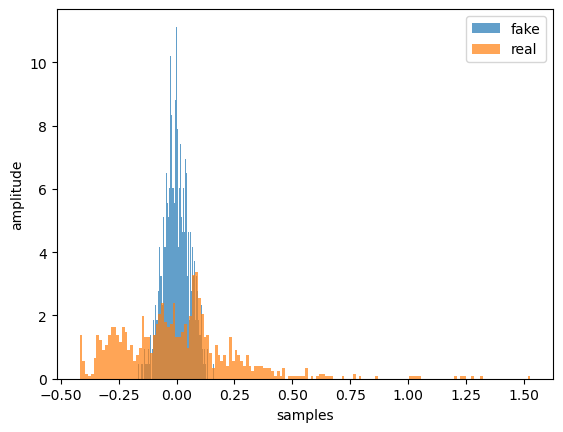

Epoch: 198 Loss D.: -0.03554627299308777 Loss G.: -0.0040799705311656 KL Divergence RG: 1.5127263881182258 KL Divergence GR: 0.44541310464728345
Epoch 198


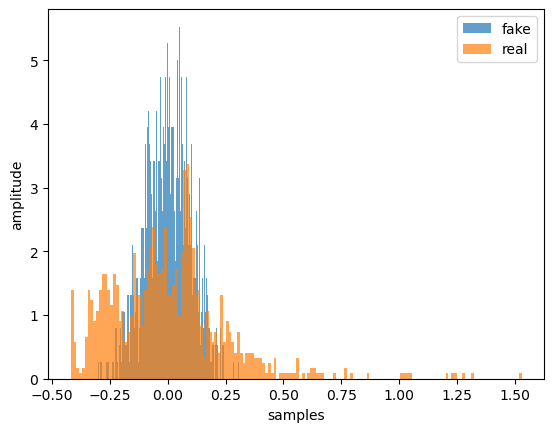

Epoch: 199 Loss D.: -0.030527761206030846 Loss G.: -0.002190073486417532 KL Divergence RG: 4.9611517291690905 KL Divergence GR: 1.68763059285873
Epoch 199


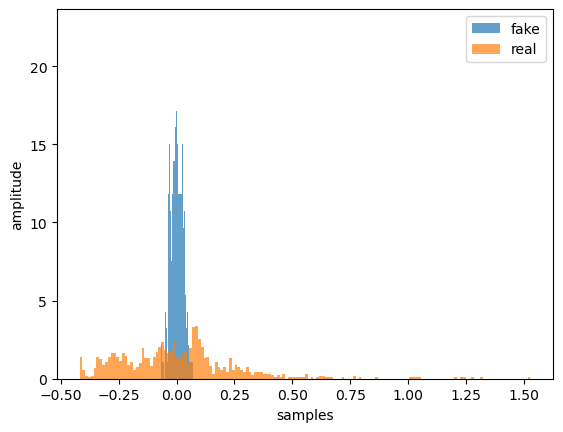

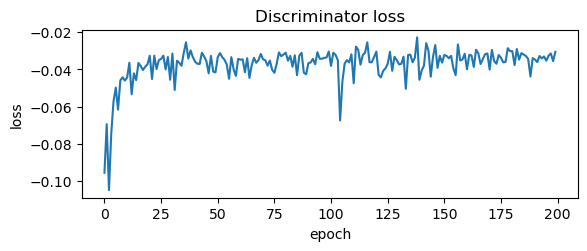

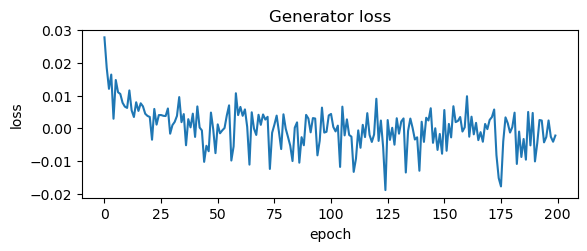

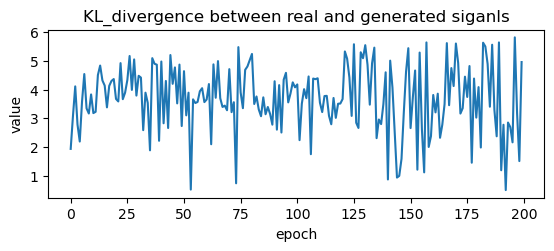

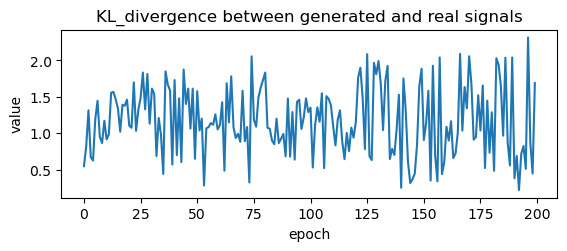

In [43]:
loss_disc = []
loss_gen = []
epochs= []
negkld = 0
kl_div_metric_rg= []
kl_div_metric_gr= []
for epoch in range(num_epochs):
    running_loss_disc = 0.0
    running_loss_gen = 0.0
    for n, (real_samples, _) in enumerate(train_loader):
        
        for _ in range(5):
        # Sample data
            real_samples_labels = torch.ones((batch_size, 1))
            latent_space_samples = torch.randn((batch_size, 1000))
            generated_samples = generator(latent_space_samples)   
            generated_samples_labels = torch.zeros((batch_size, 1))
            all_samples = torch.cat((real_samples, generated_samples))
            all_samples_labels = torch.cat(
                (real_samples_labels, generated_samples_labels)
            )

            # Dicriminator forward-loss-backward-update
            D_real = discriminator(real_samples.float())
            D_fake = discriminator(generated_samples)

            D_loss = -(torch.mean(D_real) - torch.mean(D_fake))

            D_loss.backward()
            optimizer_discriminator.step()

            # Weight clipping
            for p in discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)

            # Housekeeping - reset gradient
            reset_grad()
            
        # Generator forward-loss-backward-update
        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 1000))
        generated_samples = generator(latent_space_samples)
        D_fake = discriminator(generated_samples)

        G_loss = -torch.mean(D_fake)

        G_loss.backward()
        optimizer_generator.step()

        # Housekeeping - reset gradient
        reset_grad()
        
        #print(epoch,n)
        if n == batch_size - 1:
            if epoch == 1:
            # Generating output arrays (Initial cycle)
                latent_space_samples = torch.randn(1, 1000)
                generated_samples = generator(latent_space_samples)
                print('Epoch 1')
                plt.figure()
                plt.hist(generated_samples[0].detach().numpy(), bins=160, density=True, alpha=0.7, label='fake')
                plt.hist(train_data[0], bins=160, density=True, alpha=0.7, label='real')
                plt.legend()
                plt.title('First Epoch')
                plt.show()
            
            epochs.append(epoch)
            running_loss_disc += D_loss.item() 
            #epoch_loss_disc = running_loss_disc / len(train_loader)
            epoch_loss_disc = running_loss_disc
            loss_disc.append(epoch_loss_disc)
            
            running_loss_gen += G_loss.item() 
            #epoch_loss_gen = running_loss_gen / len(train_loader)
            epoch_loss_gen = running_loss_gen
            loss_gen.append(epoch_loss_gen)
            
        # Print and plot every now and then
        if n == batch_size - 1:
            latent_space_samples = torch.randn(1, 1000)
            generated_samples = generator(latent_space_samples)
            smt_pgen = prob_generated(generated_samples)
            kldiv_real_gen = kl_divergence_calc(smooth_preal, smt_pgen)
            kldiv_gen_real = kl_divergence_calc(smt_pgen, smooth_preal)
            kl_div_metric_rg.append(kldiv_real_gen)
            kl_div_metric_gr.append(kldiv_gen_real)

                
            print(f"Epoch: {epoch} Loss D.: {D_loss.data.numpy()} Loss G.: {G_loss.data.numpy()} KL Divergence RG: {kldiv_real_gen} KL Divergence GR: {kldiv_gen_real}")
            #print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            #if ((kldiv_real_gen > 0 and kldiv_real_gen < 1) or (kldiv_gen_real > 0 and kldiv_gen_real < 1)):
            print('Epoch', epoch)
            plt.figure()
            plt.hist(generated_samples[0].detach().numpy(), bins=160, density=True, alpha=0.7, label='fake')
            plt.hist(train_data[0], bins=160, density=True, alpha=0.7, label='real')
            plt.xlabel('samples')
            plt.ylabel('amplitude')
            plt.legend()
            plt.show()


plt.subplot(2, 1, 1)
#plot the discriminator loss
plt.plot(epochs,loss_disc)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Discriminator loss')
plt.show()
#plot the generator loss
plt.subplot(2, 1, 2)
plt.plot(epochs,loss_gen)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Generator loss')
plt.show()
#plot the KL-divergence 
plt.subplot(2, 1, 1)
plt.plot(epochs,kl_div_metric_rg)
plt.xlabel('epoch')
plt.ylabel('value')
plt.title('KL_divergence between real and generated siganls')
plt.show()  
plt.subplot(2, 1, 2)
plt.plot(epochs,kl_div_metric_gr)
plt.xlabel('epoch')
plt.ylabel('value')
plt.title('KL_divergence between generated and real signals')
plt.show()  

In [44]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)
#pd.reset_option("display.max_rows")
pd.options.display.max_rows = 10000
torch.set_printoptions(threshold=1500)
torch.set_printoptions(edgeitems=500)

In [45]:
#generate_data()
#generated_samples = generated_samples.detach()
#plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

#pd.DataFrame(generated_samples[0]).plot()
#print(generated_samples)

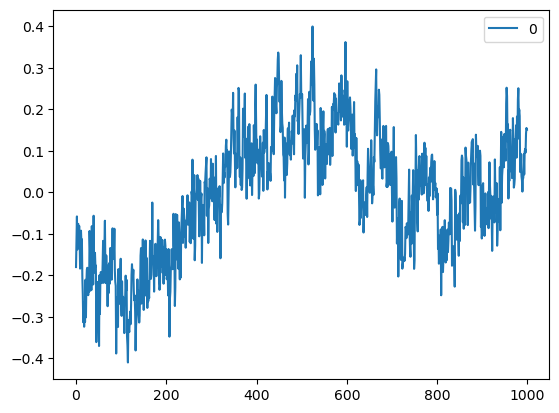

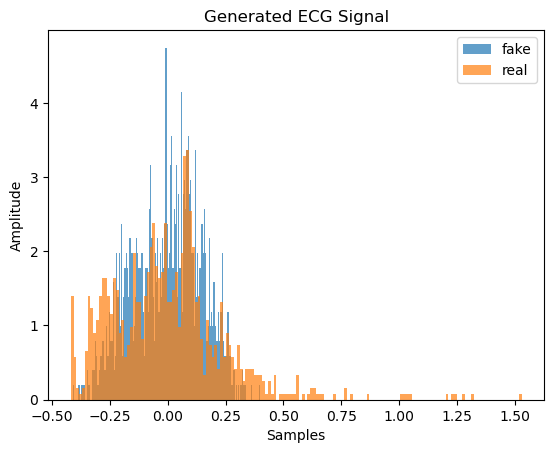

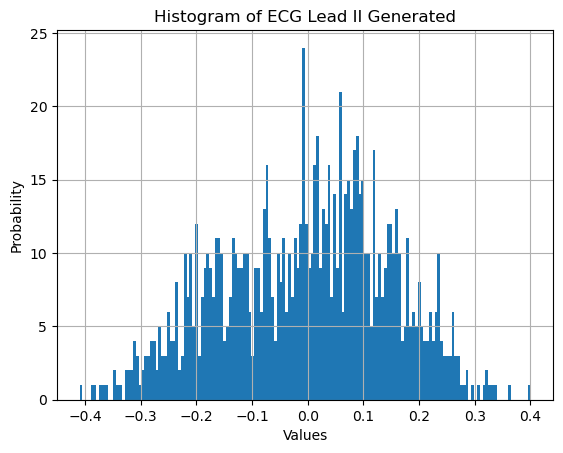

[[<AxesSubplot:title={'center':'Histogram of ECG Lead II Generated'}, xlabel='Values', ylabel='Probability'>]]
[<AxesSubplot:title={'center':'Histogram of ECG Lead II Generated'}, xlabel='Values', ylabel='Probability'>]


In [46]:
#print(generated_samples)

#max_gen_value = torch.max(generated_samples[0])
#min_gen_value = torch.min(generated_samples[0])
##print(min_gen_value,max_gen_value)
 

# the histogram of the data
#m, binss, patchess = plt.hist(generated_samples[0], 20)
latent_space_samples = torch.randn(1, 1000)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()

pd.DataFrame(generated_samples[0]).plot()
plt.figure()
plt.xlabel('Values')
plt.ylabel('Probability')
plt.title('Histogram of Generated ECG Lead II')
plt.hist(generated_samples[0].detach().numpy(), bins=160, density=True, alpha=0.7, label='fake')
plt.hist(train_data[0], bins=160, density=True, alpha=0.7, label='real')
plt.legend()
plt.title('Generated ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

#n, bins, patches = plt.hist(train_data[0], 20)
ax  = pd.DataFrame(generated_samples[0].detach().numpy()).hist(bins=160)

#print(m)
plt.xlabel('Values')
plt.ylabel('Probability')
plt.title('Histogram of ECG Lead II Generated')
plt.grid(True)
plt.show()


#ax = ax[0]
print(ax)
for x in ax: 
    print(x)
#prob_gen = m/1000
#prob_gen

In [47]:
#Mean
#generated_signal_mean = torch.mean(generated_samples[0])
#print('signal_mean:', generated_signal_mean)
#Variance
#generated_signal_variance = torch.var(generated_samples[0])
#print('signal_variance:' ,generated_signal_variance)
#Skewness
#generated_signal_skewness = skew(generated_samples[0])
#print('signal_skewness:', generated_signal_skewness)
#Kurtosis
#generated_signal_kurtosis = kurtosis(generated_samples[0], fisher=False)
#print('signal_kurtosis:',generated_signal_kurtosis)

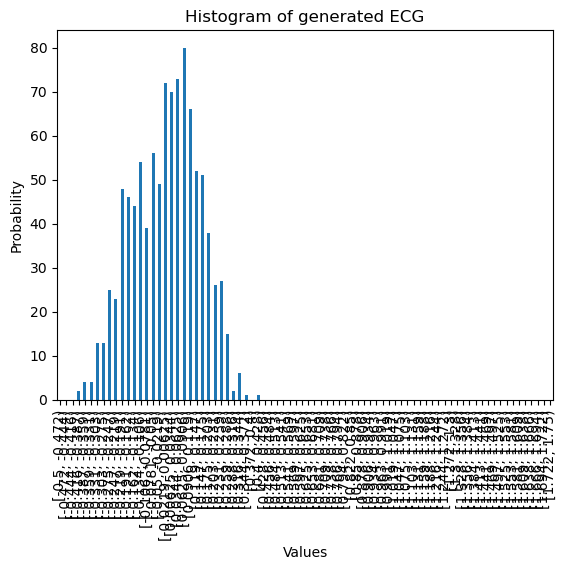

In [48]:
step = 0.028125
bin_range = np.arange(-0.5, 1.75+step, step)

outg, bins  = pd.cut(generated_samples[0].detach(), bins=bin_range, include_lowest=True, right=False, retbins=True)
outg.value_counts().plot.bar()
plt.xlabel('Values')
plt.ylabel('Probability')
plt.title('Histogram of generated ECG')
plt.grid(False)
plt.show()
df = outg.value_counts().rename_axis('values').reset_index(name='counts')
#print(df)
gen = df.counts.values
pgen = gen/1000
nonzero_pgen = np.count_nonzero(pgen)
#print(nonzero_pgen)
pgen_eps = eps/nonzero_pgen
#print(pgen_eps)
smooth_pgen = np.where(pgen != 0, pgen - pgen_eps, pgen_eps)
#print(smooth_pgen)
#print(pgen)
#print(gen)

In [49]:
kl_div_rg =kl_divergence_calc(smooth_preal, smooth_pgen)
kl_div_gr =kl_divergence_calc(smooth_pgen,smooth_preal)
print("KL divergence between real and generated ",kl_div_rg)
print("KL divergence between generated and real ",kl_div_gr)

KL divergence between real and generated  0.5230154244188123
KL divergence between generated and real  0.20890471336060992


In [50]:
#KL divergence using library formula
#t1 = torch.from_numpy(p[nonzeros])
#t2 = torch.from_numpy(q[nonzeros])
#print(type(t1))
#print(type(t2))
#out_kl = F.kl_div((t1),(t2))
#print(out_kl)

In [51]:
latent_space_samples = torch.randn(1024, 1000)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
generated_samples = generated_samples.numpy()

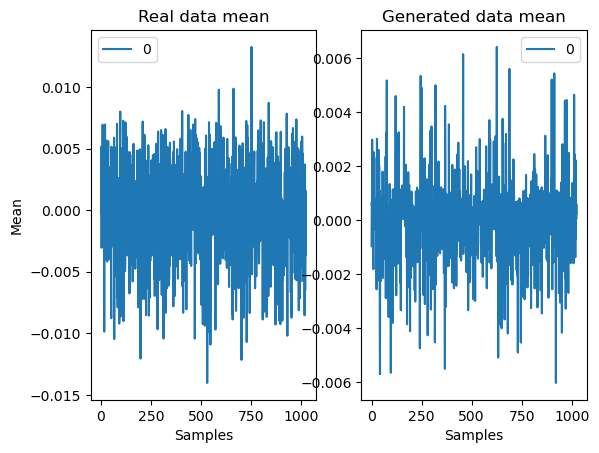

In [52]:
#define subplot layout
fig, axes = plt.subplots(nrows=1, ncols=2)

#Plot for real sample mean
real_data_mean = np.mean(train_data,axis=1)
#print(train_data_mean)
ax1 = pd.DataFrame(real_data_mean).plot(ax=axes[0], title='Real data mean')

#Plot for generated data mean
gen_data_mean = np.mean(generated_samples,axis=1)
#print(gen_data_mean)
ax2 = pd.DataFrame(gen_data_mean).plot(ax=axes[1], title='Generated data mean')

ax1.set_xlabel("Samples")
ax2.set_xlabel("Samples")
ax1.set_ylabel("Mean")
plt.savefig('means_r_g.png')
plt.show()

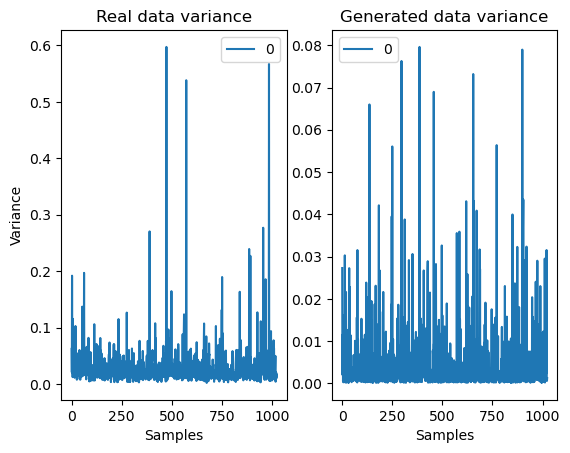

In [53]:
#define subplot layout
fig, axes = plt.subplots(nrows=1, ncols=2)
#Plot for training sample variance
real_data_var = np.var(train_data,axis=1)
#print(train_data_var)
ax3 = pd.DataFrame(real_data_var).plot(ax=axes[0], title='Real data variance')

#Plot for generated data variance
gen_data_var = np.var(generated_samples,axis=1)
#print(gen_data_var)
ax4 = pd.DataFrame(gen_data_var).plot(ax=axes[1], title='Generated data variance')

ax3.set_xlabel("Samples")
ax4.set_xlabel("Samples")
ax3.set_ylabel("Variance")
plt.savefig('var_r_g.png')
plt.show()

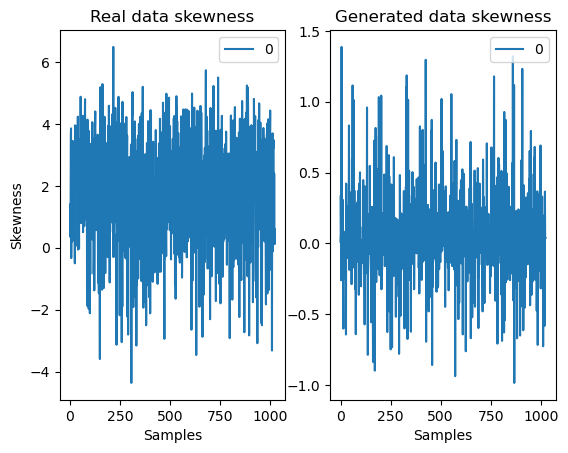

In [54]:
#define subplot layout
fig, axes = plt.subplots(nrows=1, ncols=2)
#Plot for training sample skewness
real_data_skew = skew(train_data,axis=1)
#print(train_data_skew)
ax5 = pd.DataFrame(real_data_skew).plot(ax=axes[0], title='Real data skewness')

#Plot for generated data skewness
gen_data_skew = skew(generated_samples,axis=1)
#print(gen_data_skew)
ax6 = pd.DataFrame(gen_data_skew).plot(ax=axes[1], title='Generated data skewness')

ax5.set_xlabel("Samples")
ax6.set_xlabel("Samples")
ax5.set_ylabel("Skewness")
plt.savefig('skew_r_g.png')
plt.show()

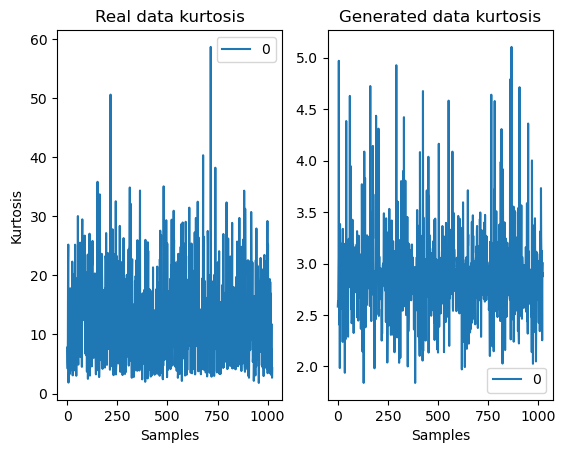

In [55]:
#define subplot layout
fig, axes = plt.subplots(nrows=1, ncols=2)
#Plot for training sample Kurtosis
real_data_kurtosis = kurtosis(train_data, fisher=False, axis=1)
#print(train_data_kurtosis)
ax7 = pd.DataFrame(real_data_kurtosis).plot(ax=axes[0], title='Real data kurtosis')

#Plot for generated data Kurtosis
gen_data_kurtosis = kurtosis(generated_samples, fisher=False, axis=1)
#print(gen_data_kurtosis)
ax8 = pd.DataFrame(gen_data_kurtosis).plot(ax=axes[1], title='Generated data kurtosis')

ax7.set_xlabel("Samples")
ax8.set_xlabel("Samples")
ax7.set_ylabel("Kurtosis")
plt.savefig('kurt_r_g.png')
plt.show()

In [56]:
#class JSD(nn.Module):
#    def __init__(self):
#        super(JSD, self).__init__()
#        self.kl = nn.KLDivLoss(reduction='batchmean', log_target=True)

#    def forward(self, p: torch.tensor, q: torch.tensor):
#        p, q = p.view(-1, p.size(-1)), q.view(-1, q.size(-1))
#        m = (0.5 * (p + q)).log()
#        return 0.5 * (self.kl(m, p.log()) + self.kl(m, q.log()))